In [7]:
import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
import pymc as pm
print(f"Running on PyMC v{pm.__version__}")
print(f"Running on ArviZ v{az.__version__}")
#import pytensor as pt
#import pytensor.tensor as ptt
import aesara.tensor as ptt
import aesara as pt
import matplotlib.dates as mdates
import xarray as xr

import os, datetime, pickle, shutil, bz2, scipy, math, tqdm, sys

Running on PyMC v4.4.0
Running on ArviZ v0.16.1


## 1. Prepare the data
The spec_id choosen here (`0` for aged 2-4, `1` for age 5+, and `2` for the full model with everyone.) only influence the test model, not the figures.

In [10]:
spec_id = 0
interactive = False
save = False
test_value = False  # wether to compute aesera test value
prefix = "cc-Fit-hist"

dynamics_specs = ["mvDynamics"]  # "inDynamics",
age_spec = ["U5", "adult", "all"]
model_specs = [f"{a}-{d}" for a in age_spec for d in dynamics_specs]
model_spec = model_specs[spec_id]
model_id = f"{prefix}_{model_spec}_{utils.get_git_revision_short_hash()}_{datetime.date.today()}"
model_folder = f"/work/users/c/h/chadi/calib_Fit-hist/{model_id}"
print(f">>> {spec_id} -> using model spec {model_spec} \n          >>> {model_specs}")
print(f">>> saving to {model_id}")

# can be modified 
titer_var = "titermax_log2" # var to model

# Load data
cases_df, serosurvey_df, ti, tf = utils.load_cases_and_serosurvey_clean()
age_spec = model_spec.split("-")[0]

population = 21131 # population from IHSI, 2009
# https://en.wikipedia.org/wiki/Demographics_of_Haiti for % under5 
# and age 2,3,4 should be roughly 3/5 of age 0,1,2,3,4
population2_4 = int(population * 12.53/100 * 3/5) 
population5_99 = int(population * (100-12.53)/100)
population2_99 = population2_4 + population5_99
probcase2_4 = 0.7394 # probability of a case being 2_4 the cases with MSF data Gonaives, Nov and Dec 2010

def get_gt_data(age_spec):
    if age_spec == "all":
        n_population = population2_99
        cases_gt = cases_df["cas_vus_lt5"] * probcase2_4 + cases_df["cas_vus_geq5"]
        serosurvey_gt = serosurvey_df
    elif age_spec == "U5":
        n_population = population2_4
        cases_gt = cases_df["cas_vus_lt5"] * probcase2_4
        serosurvey_gt = serosurvey_df[serosurvey_df["age"] == '2-4']
    elif age_spec == "adult":
        n_population = population5_99
        cases_gt = cases_df["cas_vus_geq5"]
        serosurvey_gt = serosurvey_df[serosurvey_df["age"] == '>=5']

    cases_arr = np.array(cases_gt)
    n_sampled = int(serosurvey_gt["n"].sum())
    cases_total = np.sum(cases_arr) 
    n_days = len(cases_arr)

    # get all bins, even if zero for this age
    observed_count_index = serosurvey_df.groupby(by=titer_var)[titer_var].agg("count")
    observed_count = serosurvey_gt[[titer_var, "n"]].groupby(titer_var).sum()
    observed_count = observed_count.reindex(observed_count_index.index, fill_value=0)
    observed_count = observed_count.astype(int)["n"] # important for pymc bug
    
    return cases_gt, serosurvey_gt, n_population, cases_arr, n_sampled, cases_total, n_days, observed_count


cases_gt, serosurvey_gt, n_population,\
    cases_arr, n_sampled, cases_total,\
    n_days, observed_count = get_gt_data(age_spec)

print(f">>> selected age_spec {age_spec} with population: {n_population}, n_case: {cases_total}, n_sampled: {n_sampled}")


# data for model:
bin_lower_lim = observed_count.index.values

# some constants for plots
bins_pretty = [f"1:{int(np.round(2**x))}" for x in bin_lower_lim]
bins_pretty[0] = "0"
bins_pretty[7:] = [f"{b[:-3]}'{b[-3:]}" for b in bins_pretty[7:]]
bins_pretty_wlog = [f"{t} ({lt:4.2f})" for t, lt in zip(bins_pretty, bin_lower_lim)]
to_plot_vars = ["rho", "sigma", "delta", "omega_p", "lambda"]
sns.set_style('ticks')
#sns.set_context("paper", font_scale=2)
plt.rcParams['figure.facecolor'] = 'white'
sns.set_palette("dark")


# solve the nested braket bug
#pt.config.gcc__cxxflags = pt.config.gcc__cxxflags + " -fbracket-depth=800"

>>> 0 -> using model spec U5-mvDynamics 
          >>> ['U5-mvDynamics', 'adult-mvDynamics', 'all-mvDynamics']
>>> saving to cc-Fit-hist_U5-mvDynamics_aaf01ea_2024-02-21
>>> ti: 2010-10-20, tf: 2011-04-06
>>> cases_df: (169, 4)
>>> serosurvey_df: (219, 6)
>>> selected age_spec U5 with population: 1588, n_case: 627.0111999999999, n_sampled: 124


In [5]:
observed_count

titermax_log2
0.000000     32
4.321928      6
5.321928      9
6.321928     10
7.321928     10
8.321928     15
9.321928      8
10.321928     5
11.321928     2
12.321928     2
13.321928     0
14.321928     0
15.321928     0
Name: n, dtype: int64

## PyMC Bayesian model

In [11]:
if test_value:
    pt.config.compute_test_value = 'warn'
else:
    pt.config.compute_test_value = 'off'

sampling_time_mean = np.round(np.average(serosurvey_gt['date_idx'], weights=serosurvey_gt['n'])) # np.round(serosurvey_gt["date_idx"].mean()) # mean sampling time.
sampling_time = np.array(np.repeat(serosurvey_gt['date_idx'], serosurvey_gt['n'])) # np.array(np.round(serosurvey_gt["date_idx"]))
# cases_df[-10:] is zeros, so no need to model the increase before exponential titer decay.
delay_report2peaktiter = 9 # days

# lower bins
lbins_tiled = np.tile(bin_lower_lim, [n_sampled,1]).T 

# remove the deterministic variable before run.
with pm.Model() as titer_indivdecay_model4:
    # reporting rate:
    # reporting rate is allowed of overreporting (above 1) and underreporting (below 1)
    rho =  pm.TruncatedNormal("rho", 
            mu = (cases_total/n_population+1.5)/2, 
            sigma = 1, 
            lower = cases_total/n_population, 
            upper = 1.5, 
            shape = 1)
    
    # decay parameters:
    dynamics_spec = model_spec.split("-")[1]
    if dynamics_spec == "inDynamics":
        print("using independent dynamics")
        omega_p = pm.TruncatedNormal("omega_p", 
                mu = 2+np.log2(5),#2+np.log2(5), 
                sigma = 1.75, 
                shape = n_sampled, 
                lower = 0,
                #upper=5+np.log2(5)
                )
        llambda = pm.TruncatedNormal("lambda", 
                mu = np.log2(45), # from Jones et al, table S3
                sigma = np.log2(40)/2,#np.log2((40+150)/100)/1.96, , 
                shape = n_sampled, 
                lower = np.log2(20)#,upper = np.log2(250)
                )
    elif dynamics_spec == "mvDynamics":
        print("Using multivariate dynamics")
        titer_params = pm.MvNormal("titer_params", 
                mu = [2.98825782+np.log2(5), np.log2(45)], 
                cov= np.array([[3.9655, -4.0231],
                                [-4.0231, 8.1027]]), 
                shape=(n_sampled, 2))
        
        # After review: ok to ignore negative here: commented the next 4 lines
        omega_p =  pm.Deterministic("omega_p",  titer_params[:,0])
        llambda =  pm.Deterministic("lambda", titer_params[:,1])
        
        # omega_p_t = pm.Deterministic("omega_p_t", titer_params[:,0])
        # llambda_t = pm.Deterministic("lambda_t", titer_params[:,1])
        # # force at the mean in case it is < 0
        # omega_p =  pm.Deterministic("omega_p", ptt.switch(omega_p_t>0, omega_p_t, 2.98825782+np.log2(5)))
        # llambda =  pm.Deterministic("lambda", ptt.switch(llambda_t>0, llambda_t, np.log2(45)))
    else:
        raise ValueError(f"dynamic_spec {dynamics_spec} not recognized for dynamics")
    
    delta = pm.TruncatedNormal("delta", 
            mu = np.log(2)/123,  # half life of 123
            sigma = .0005,
            shape = 1,
            lower = np.log(2)/250,
            upper = np.log(2)/20)

    # titer sd around mean
    sigma = pm.HalfNormal("sigma", 
            sigma = 1, 
            shape = 1)


    #sigma_p = pt.printing.Print('sigma')(sigma)
    #rho_p = pt.printing.Print('rho')(rho)
    #omega_p_p = pt.printing.Print('omega_p')(omega_p)
    #llambda_p = pt.printing.Print('lambda')(llambda)
    #delta_p = pt.printing.Print('delta')(delta)

    day_inf_reported = pm.Categorical("day_inf_reported", 
            p = cases_arr/cases_total, 
            shape = n_sampled)

    # TODO: this variable should be named if_infected only
    if_inf_reported = pm.Bernoulli("if_inf_reported",  
            p = (cases_total/rho)/n_population,
            shape = n_sampled)

    #if_inf_reported_p = pt.printing.Print('if_inf_reported')(if_inf_reported)
    #day_inf_reported_p = pt.printing.Print('day_inf_reported')(day_inf_reported)  # Warning: if I do sum or mean, the value is sent !!

    mean_titer_all = omega_p + if_inf_reported * llambda * ptt.exp(-delta * (sampling_time - (day_inf_reported + delay_report2peaktiter)))

    # 3. Measurement model: (exponential of the log) cumulative densitify function 
    # of the titer distribution around the mean titer evaluated on the measurement bins.
    titer_bins_per_event1 = ptt.exp(
        pm.logcdf(rv=pm.Normal.dist(
                        mu = mean_titer_all,
                        sigma = sigma+.2,  # added after review: so there not too much 0 SD... This is beneficial on the individual model
                        shape = n_sampled
                        ), 
                value=lbins_tiled[1:,:]))  # here important to exclude the first zero
    # bounds of the bined probabilities, and then diff to get the probability to 
    # be in each bin for each event.
    titer_bins_per_event2 = ptt.concatenate([np.zeros((1,n_sampled)), titer_bins_per_event1, np.ones((1,n_sampled))], axis=0)
    titer_bins_per_event = pm.Deterministic("titer_bins_per_event", ptt.extra_ops.diff(titer_bins_per_event2, axis=0)) # 13 x 2622

    # bin probabilities weighted by the event probabilities
    #titer_bins_probs_weighted = pm.Deterministic("titer_bins_probs_weighted", event_prob_all * titer_bins_per_event)  # 13 x 2622
    
    titer_bin_probs = titer_bins_per_event.sum(axis=1)/n_sampled
    # titer_bin_probs_p = pt.printing.Print('titer_bin_probs')(titer_bin_probs)
    #titer_bin_probs_p = pt.printing.Print('titer_bin_probs')(titer_bin_probs)

    # observed counts as a Multinomial of the sum of all events prob_per_bin
    modeled_count = pm.Multinomial("modeled_count", 
                p = titer_bin_probs, 
                n = observed_count.sum(), 
                observed = observed_count.to_numpy())

model_catcount = titer_indivdecay_model4

Using multivariate dynamics


## Model debug and investigation

In [ ]:
if False:
    model_catcount.point_logps()

In [ ]:
if test_value:
    print(titer_bin_probs.get_test_value())

In [ ]:
if test_value:
    print(modeled_count.get_test_value())

In [ ]:
if test_value:
    fig, ax = plt.subplots(figsize=(7,7))
    ax.plot(bin_lower_lim, titer_bins_per_event.get_test_value()[:,:-1], marker = '.', lw=.4)
    ax.plot(bin_lower_lim, titer_bins_per_event.get_test_value()[:,-1], marker = 'o', lw=2, c='orange', label='not infected')
    ax.set_xticks(bin_lower_lim)
    ax.set_xticklabels(bins_pretty, rotation=90);
    ax.legend()
    ax.set_ylabel("bin probability")

### Test of the samplers

In [7]:
#interactive=True

In [8]:
if interactive:
    n_sample=1000
    with model_catcount:
        trace_raw = pm.sample_prior_predictive(samples=n_sample)

#az.plot_dist_comparison(samples, var_names=to_plot_vars);

Sampling: [day_inf_reported, delta, if_inf_reported, modeled_count, rho, sigma, titer_params]


In [13]:
#interactive=False
if interactive:
        chainlength = 150
        tunelength = 50
        nchains = 1
        with model_catcount:
                trace_raw = pm.sample(
                chainlength,
                tune = tunelength,
                chains = nchains,
        #        init = "adapt_full",
                initvals={
                        "lambda":np.random.uniform(4.5, 16, n_sampled), 
                        "if_inf_reported": np.random.binomial(n=1, p=.2, size=n_sampled),
                        "day_inf_reported": pm.Categorical.dist(p=cases_arr/cases_total, size=n_sampled).eval()
                        }
                #nuts_kwargs = dict(target_accept = 0.99)
        )

Only 150 samples in chain.
Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [rho, titer_params, delta, sigma]
>CategoricalGibbsMetropolis: [day_inf_reported]
>BinaryGibbsMetropolis: [if_inf_reported]


Sampling 1 chain for 50 tune and 150 draw iterations (50 + 150 draws total) took 32 seconds.
/Users/chadi/anaconda3/envs/haiti-sero_pymc4/lib/python3.11/site-packages/arviz/data/base.py:221: UserWarning: More chains (150) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


In [ ]:
if interactive:
    az.plot_trace(trace_raw);

In [ ]:
if interactive:
    az.plot_posterior(trace_raw, var_names=to_plot_vars);

In [ ]:
if False:
    trace_raw = az.from_netcdf("model_indivcat_max.nc")

    #trace_thinned = trace.sel(draw=slice(0, 100000, 10))
    trace_thinned = trace_raw

    with model_catcount:
        posterior_samples = pm.sample_posterior_predictive(trace_thinned,
            progressbar=True,
        var_names=['if_inf_reported', 'day_inf_reported', "modeled_count", "titer_bins_per_event", ]
        )

    trace_raw.extend(posterior_samples)

    n_sample=10000
    with model_catcount:
        prior_samples = pm.sample_prior_predictive(samples=n_sample)

    trace_raw.extend(prior_samples)


    trace_raw.extend(prior_samples)
    trace_raw.to_netcdf('calib_data/model_indivcat_max_ppc-incl-2.nc')

## Load the trace (obtained from calibration)
to get one pdf from all images:
```bash
convert *.png summary.pdf
```

In [ ]:
# fallback callibration
# file_path = "from_longleaf/calib_Fit-hist/fallback/calib_data2/cc-indecay_adult-mvDynamics_7be2a2c_2023-01-17/full_cc-indecay_adult-mvDynamics_7be2a2c_2023-01-17.nc"
# model_folder = "/".join(file_path.split("/")[:-1])
# model_id = "_".join(file_path.split("/")[-1].split("_")[1:]).split(".")[0]
# model_id.replace('adult', 'combined')
# trace_raw = {}
# trace_raw['adult'] = az.from_netcdf(filename=file_path)
# trace_raw['all'] = az.from_netcdf(filename=file_path.replace("adult", "all"))
# file_path = "from_longleaf/calib_Fit-hist/fallback/calib_data3/cc-indecay_U5-mvDynamics_7744910_2023-03-07/full_cc-indecay_U5-mvDynamics_7744910_2023-03-07.nc"
# trace_raw['U5'] = az.from_netcdf(filename=file_path.replace("adult", "U5"))

In [215]:
file_path = "from_longleaf/calib_Fit-hist/cc-Fit-hist_adult-mvDynamics_5117dfc_2023-03-28/full_cc-Fit-hist_adult-mvDynamics_5117dfc_2023-03-28.nc"
model_folder = "/".join(file_path.split("/")[:-1])
model_id = "_".join(file_path.split("/")[-1].split("_")[1:]).split(".")[0]
model_id.replace('adult', 'combined')
trace_raw = {}
trace_raw['adult'] = az.from_netcdf(filename=file_path)
trace_raw['all'] = az.from_netcdf(filename=file_path.replace("adult", "all").replace("28", "29"))
trace_raw['U5'] = az.from_netcdf(filename=file_path.replace("adult", "U5"))

In [454]:
if False: # not this one in the paper
    file_path = "from_longleaf3/full_cc-Fit-hist_adult-mvDynamics_5117dfc_2023-05-24.nc"
    model_folder = "/".join(file_path.split("/")[:-1])
    model_id = "_".join(file_path.split("/")[-1].split("_")[1:]).split(".")[0]
    model_id.replace('adult', 'combined')
    trace_raw = {}
    trace_raw['adult'] = az.from_netcdf(filename=file_path)
    trace_raw['all'] = az.from_netcdf(filename=file_path.replace("adult", "all"))
    trace_raw['U5'] = az.from_netcdf(filename=file_path.replace("adult", "U5"))

In [ ]:
#az.summary(trace_raw['adult'])

In [ ]:
plt.plot(trace_raw["adult"].posterior["rho"][:,:,0].T);

Below we choose what to plot in the figures (prior or posterior ppc)

In [204]:
to_plot = "posterior"
predictive_checks = {}
trace = {}
if to_plot == "prior":
    for k, v in trace_raw.items():
        trace[k] = trace_raw[k].prior
        predictive_checks[k] = trace_raw[k].prior_predictive
    #predictive_checks = trace_raw.prior_predictive
    #trace = trace_raw.prior
elif to_plot == "posterior":
    for k, v in trace_raw.items():
        trace[k] = trace_raw[k].posterior
        predictive_checks[k] = trace_raw[k].posterior_predictive
    #predictive_checks = trace_raw.posterior_predictive
    #trace = trace_raw.posterior

In [205]:
predictive_checks['all']

<xarray.Dataset>
Dimensions:                     (chain: 4, draw: 2000,
                                 if_inf_reported_dim_0: 2622,
                                 day_inf_reported_dim_0: 2622,
                                 modeled_count_dim_0: 13,
                                 titer_bins_per_event_dim_0: 13,
                                 titer_bins_per_event_dim_1: 2622)
Coordinates:
  * chain                       (chain) int64 0 1 2 3
  * draw                        (draw) int64 0 1 2 3 4 ... 1996 1997 1998 1999
  * if_inf_reported_dim_0       (if_inf_reported_dim_0) int64 0 1 ... 2620 2621
  * day_inf_reported_dim_0      (day_inf_reported_dim_0) int64 0 1 ... 2620 2621
  * modeled_count_dim_0         (modeled_count_dim_0) int64 0 1 2 3 ... 10 11 12
  * titer_bins_per_event_dim_0  (titer_bins_per_event_dim_0) int64 0 1 ... 11 12
  * titer_bins_per_event_dim_1  (titer_bins_per_event_dim_1) int64 0 1 ... 2621
Data variables:
    if_inf_reported             (chain, draw, if_inf_reported_dim_0) int64 ...
    day_inf_reported            (chain, draw, day_inf_reported_dim_0) int64 ...
    modeled_count               (chain, draw, modeled_count_dim_0) int64 ...
    titer_bins_per_event        (chain, draw, titer_bins_per_event_dim_0, titer_bins_per_event_dim_1) float64 ...
Attributes:
    created_at:                 2023-04-01T20:13:57.862984
    arviz_version:              0.12.1
    inference_library:          pymc
    inference_library_version:  4.2.0

## Figures

In [216]:
colors_age = {"adult": "lightcoral", "U5": "teal", "all":"darkblue"}
#colors_age = {"adult": "lightcoral", "U5": "slategray"}
legend_age = {"adult": "≥5 years", "U5": "2-4 years", "all": "All ≥ 2 years"}

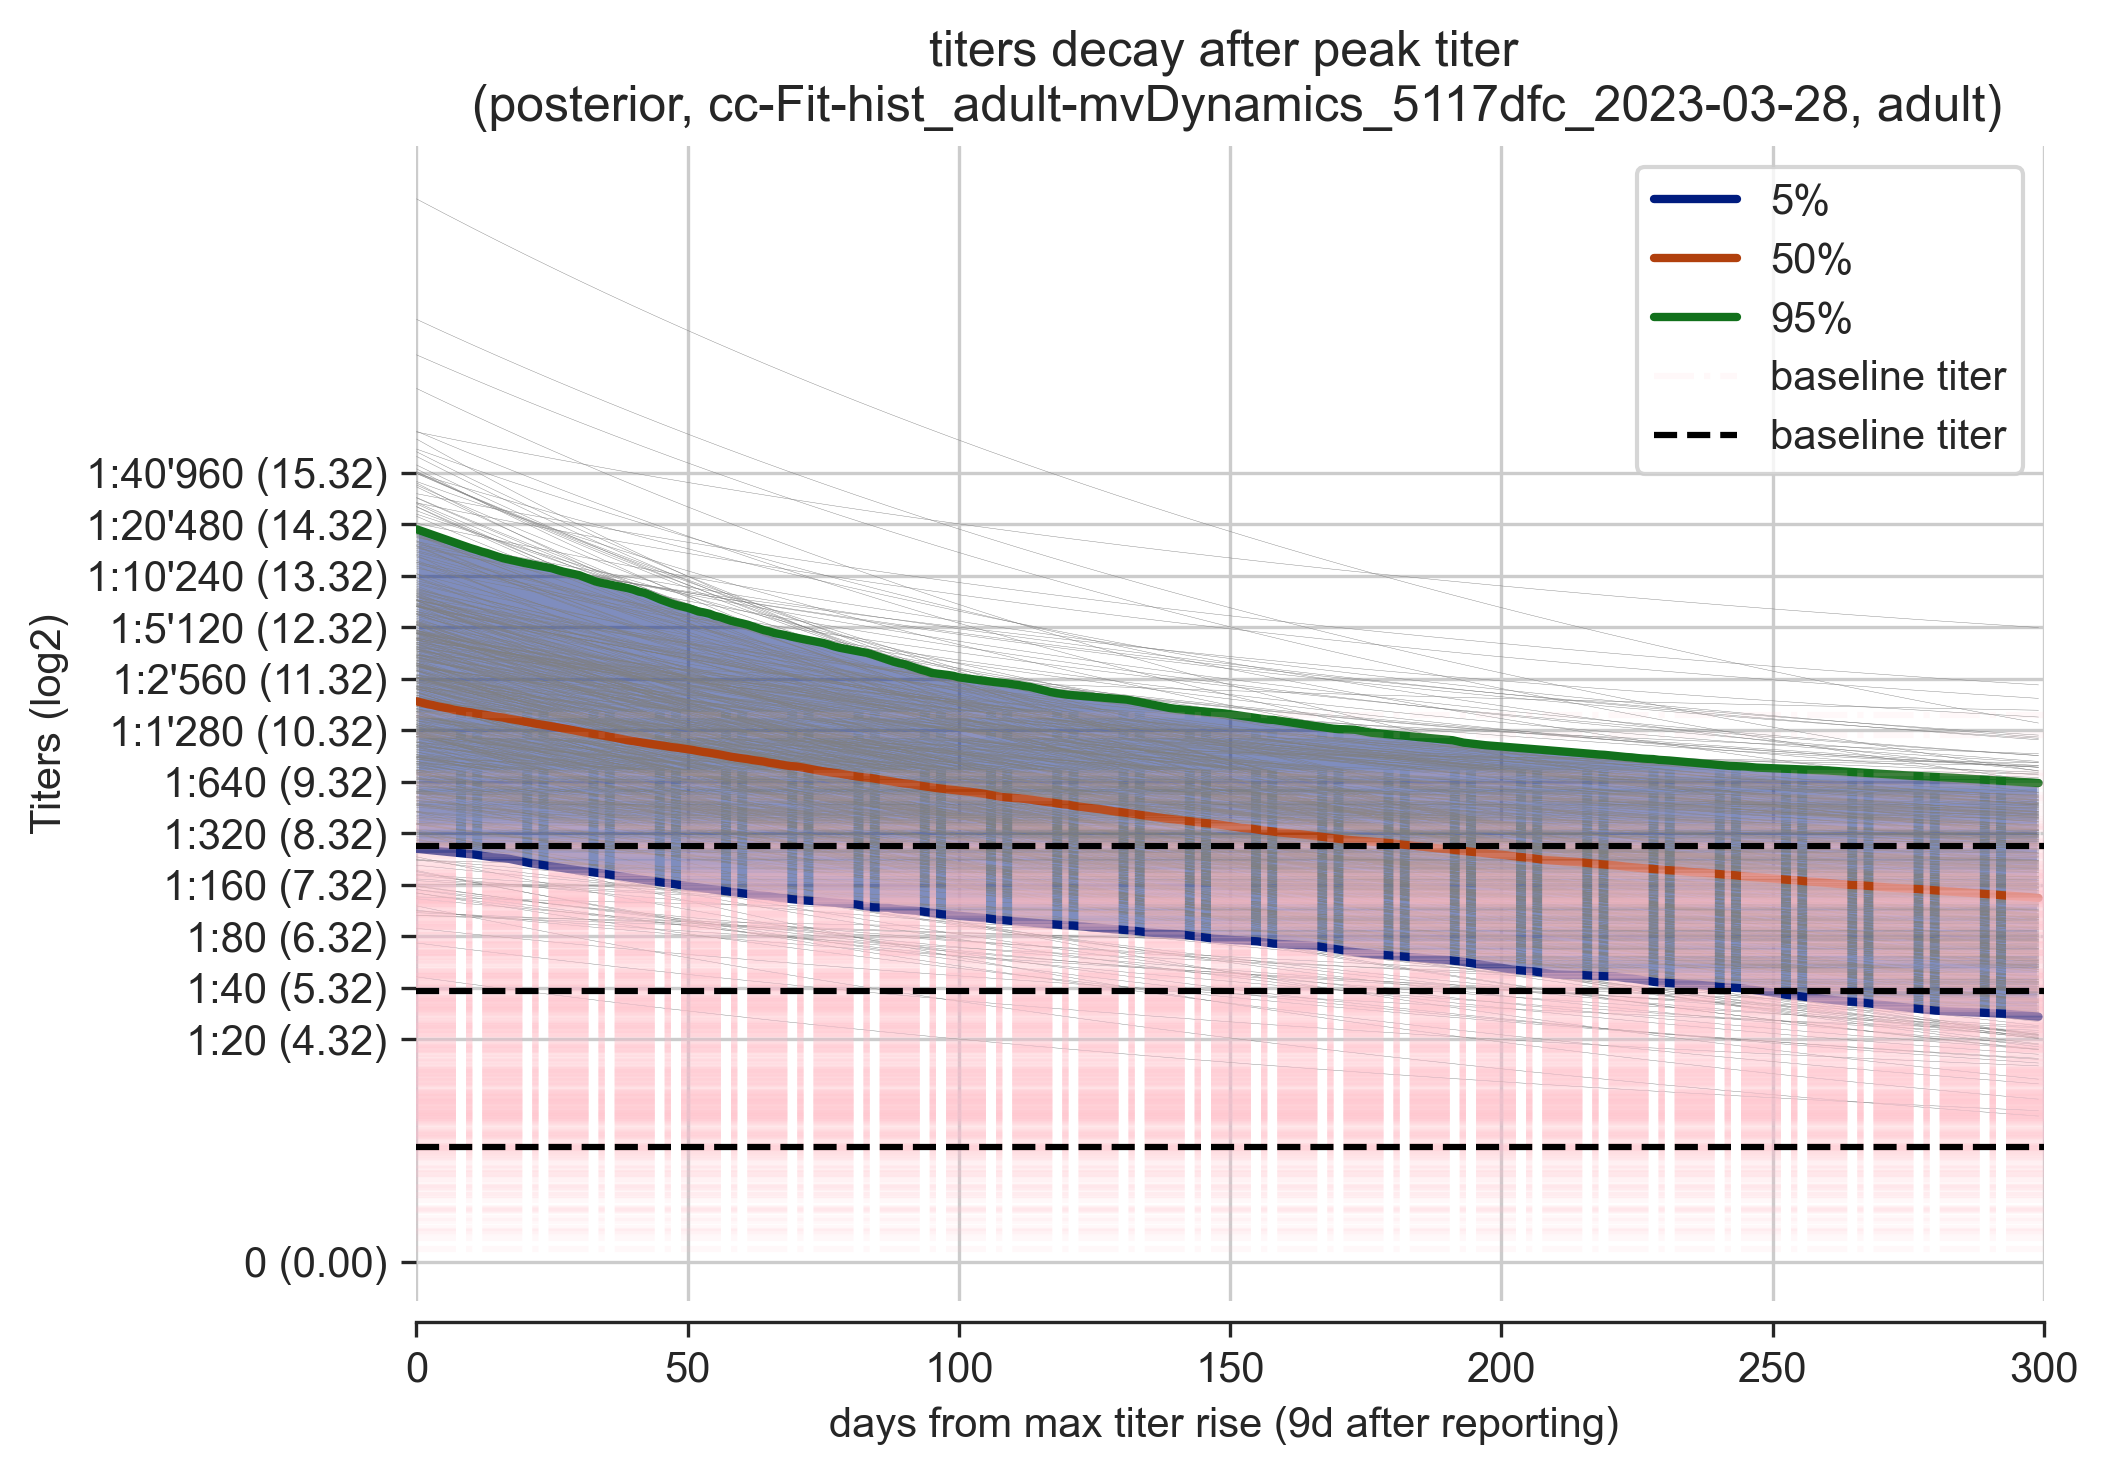

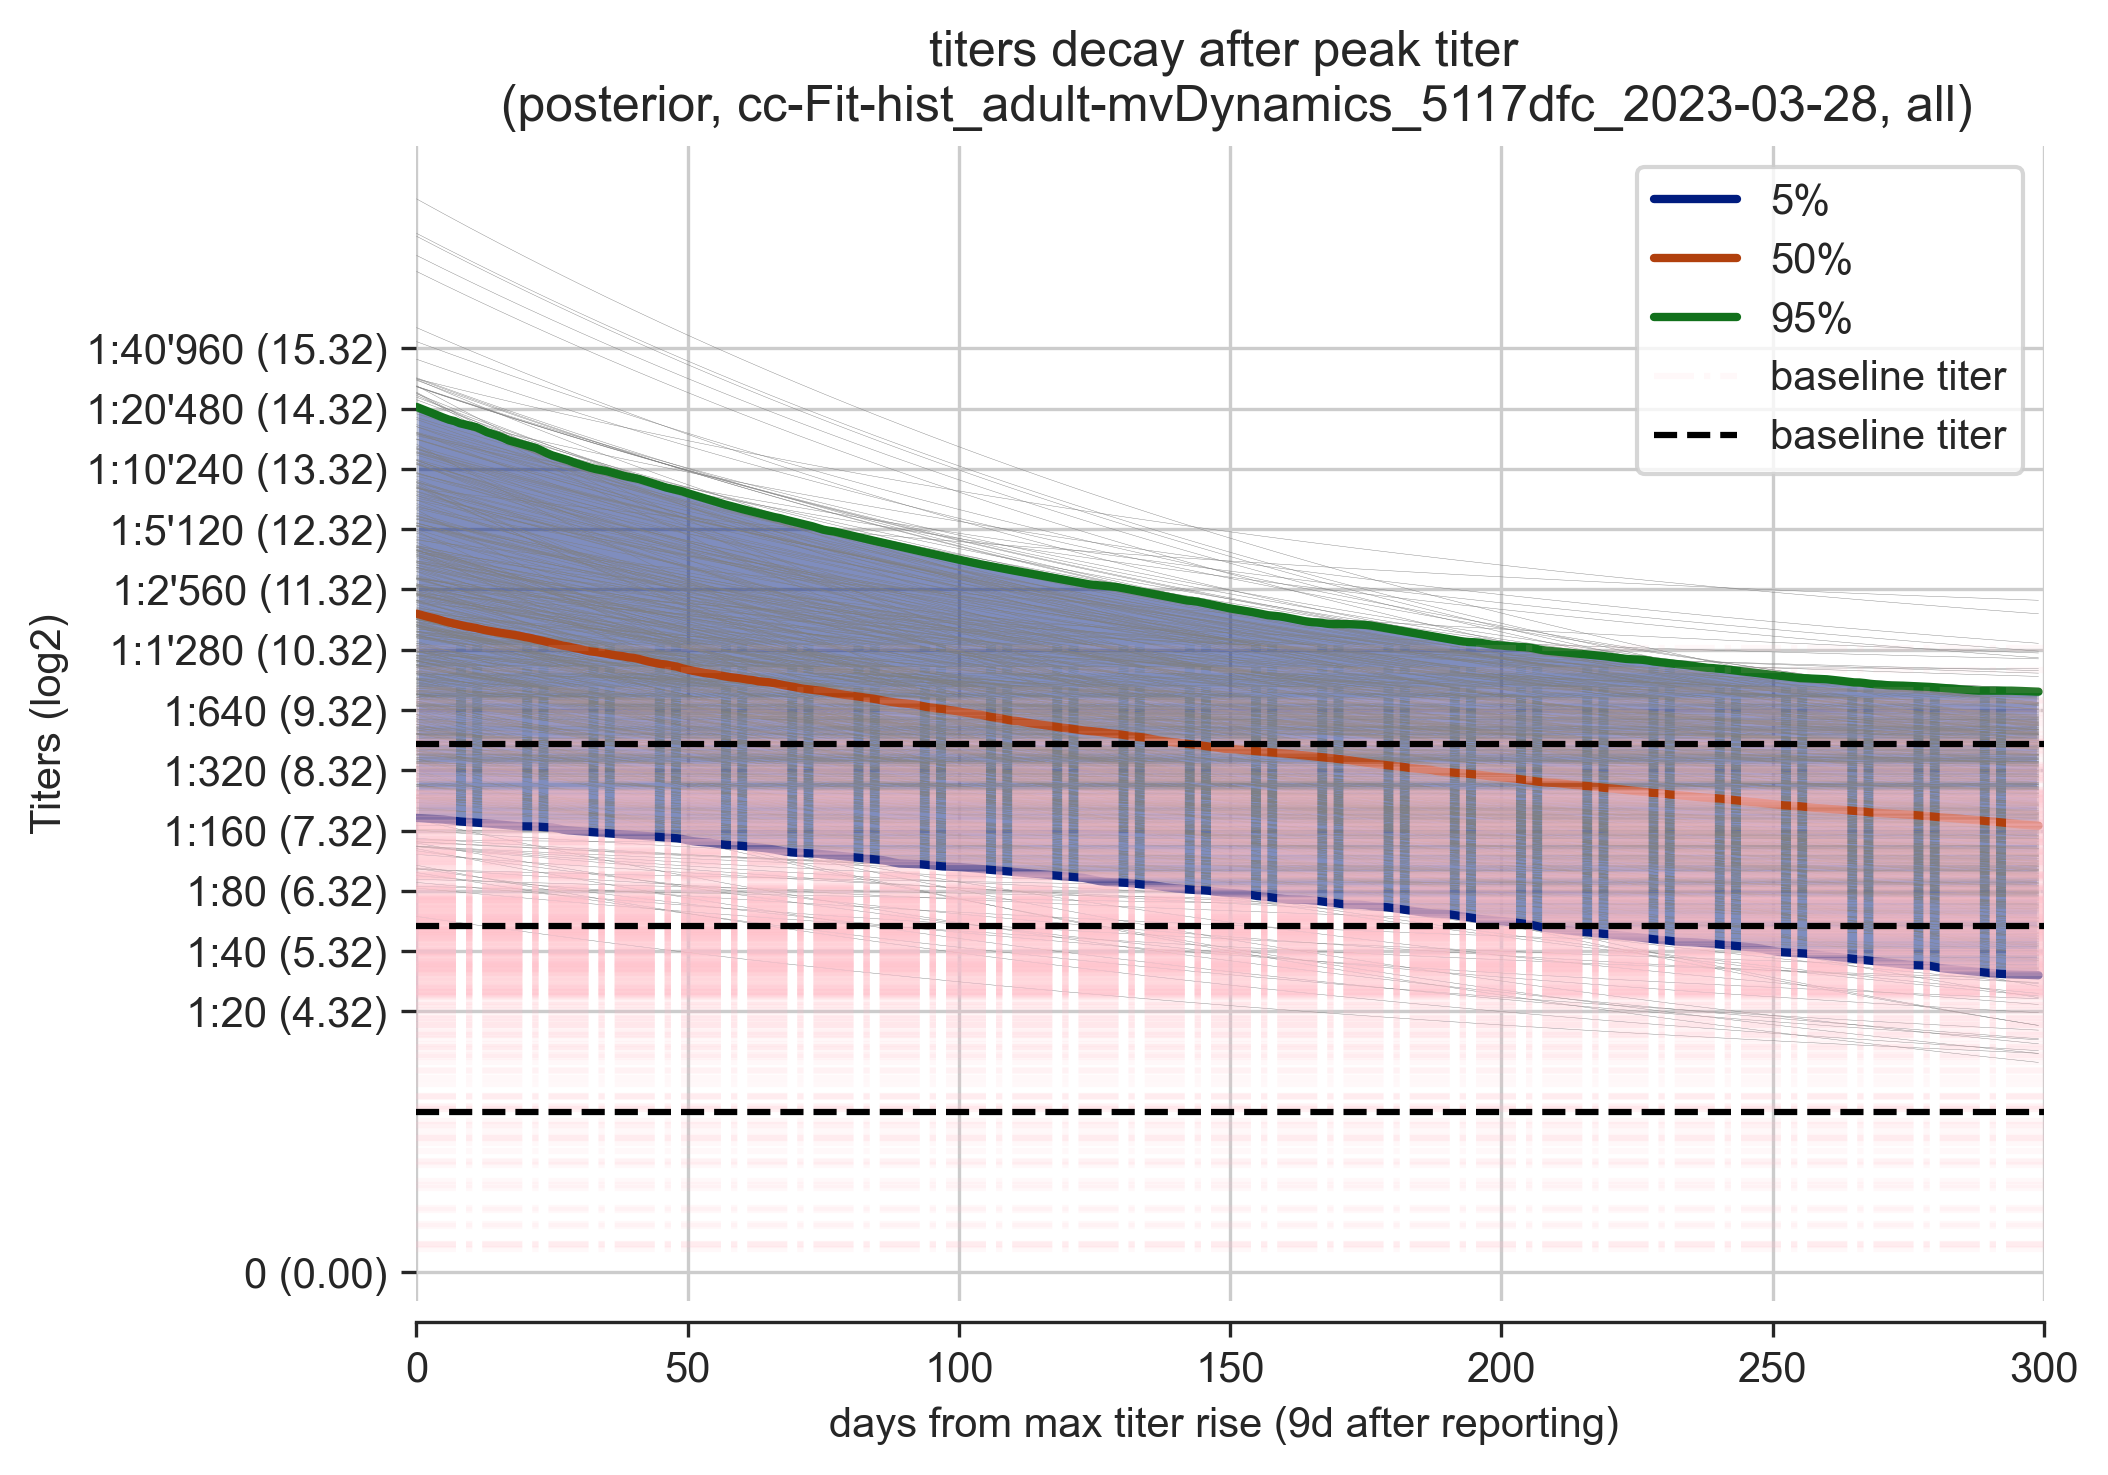

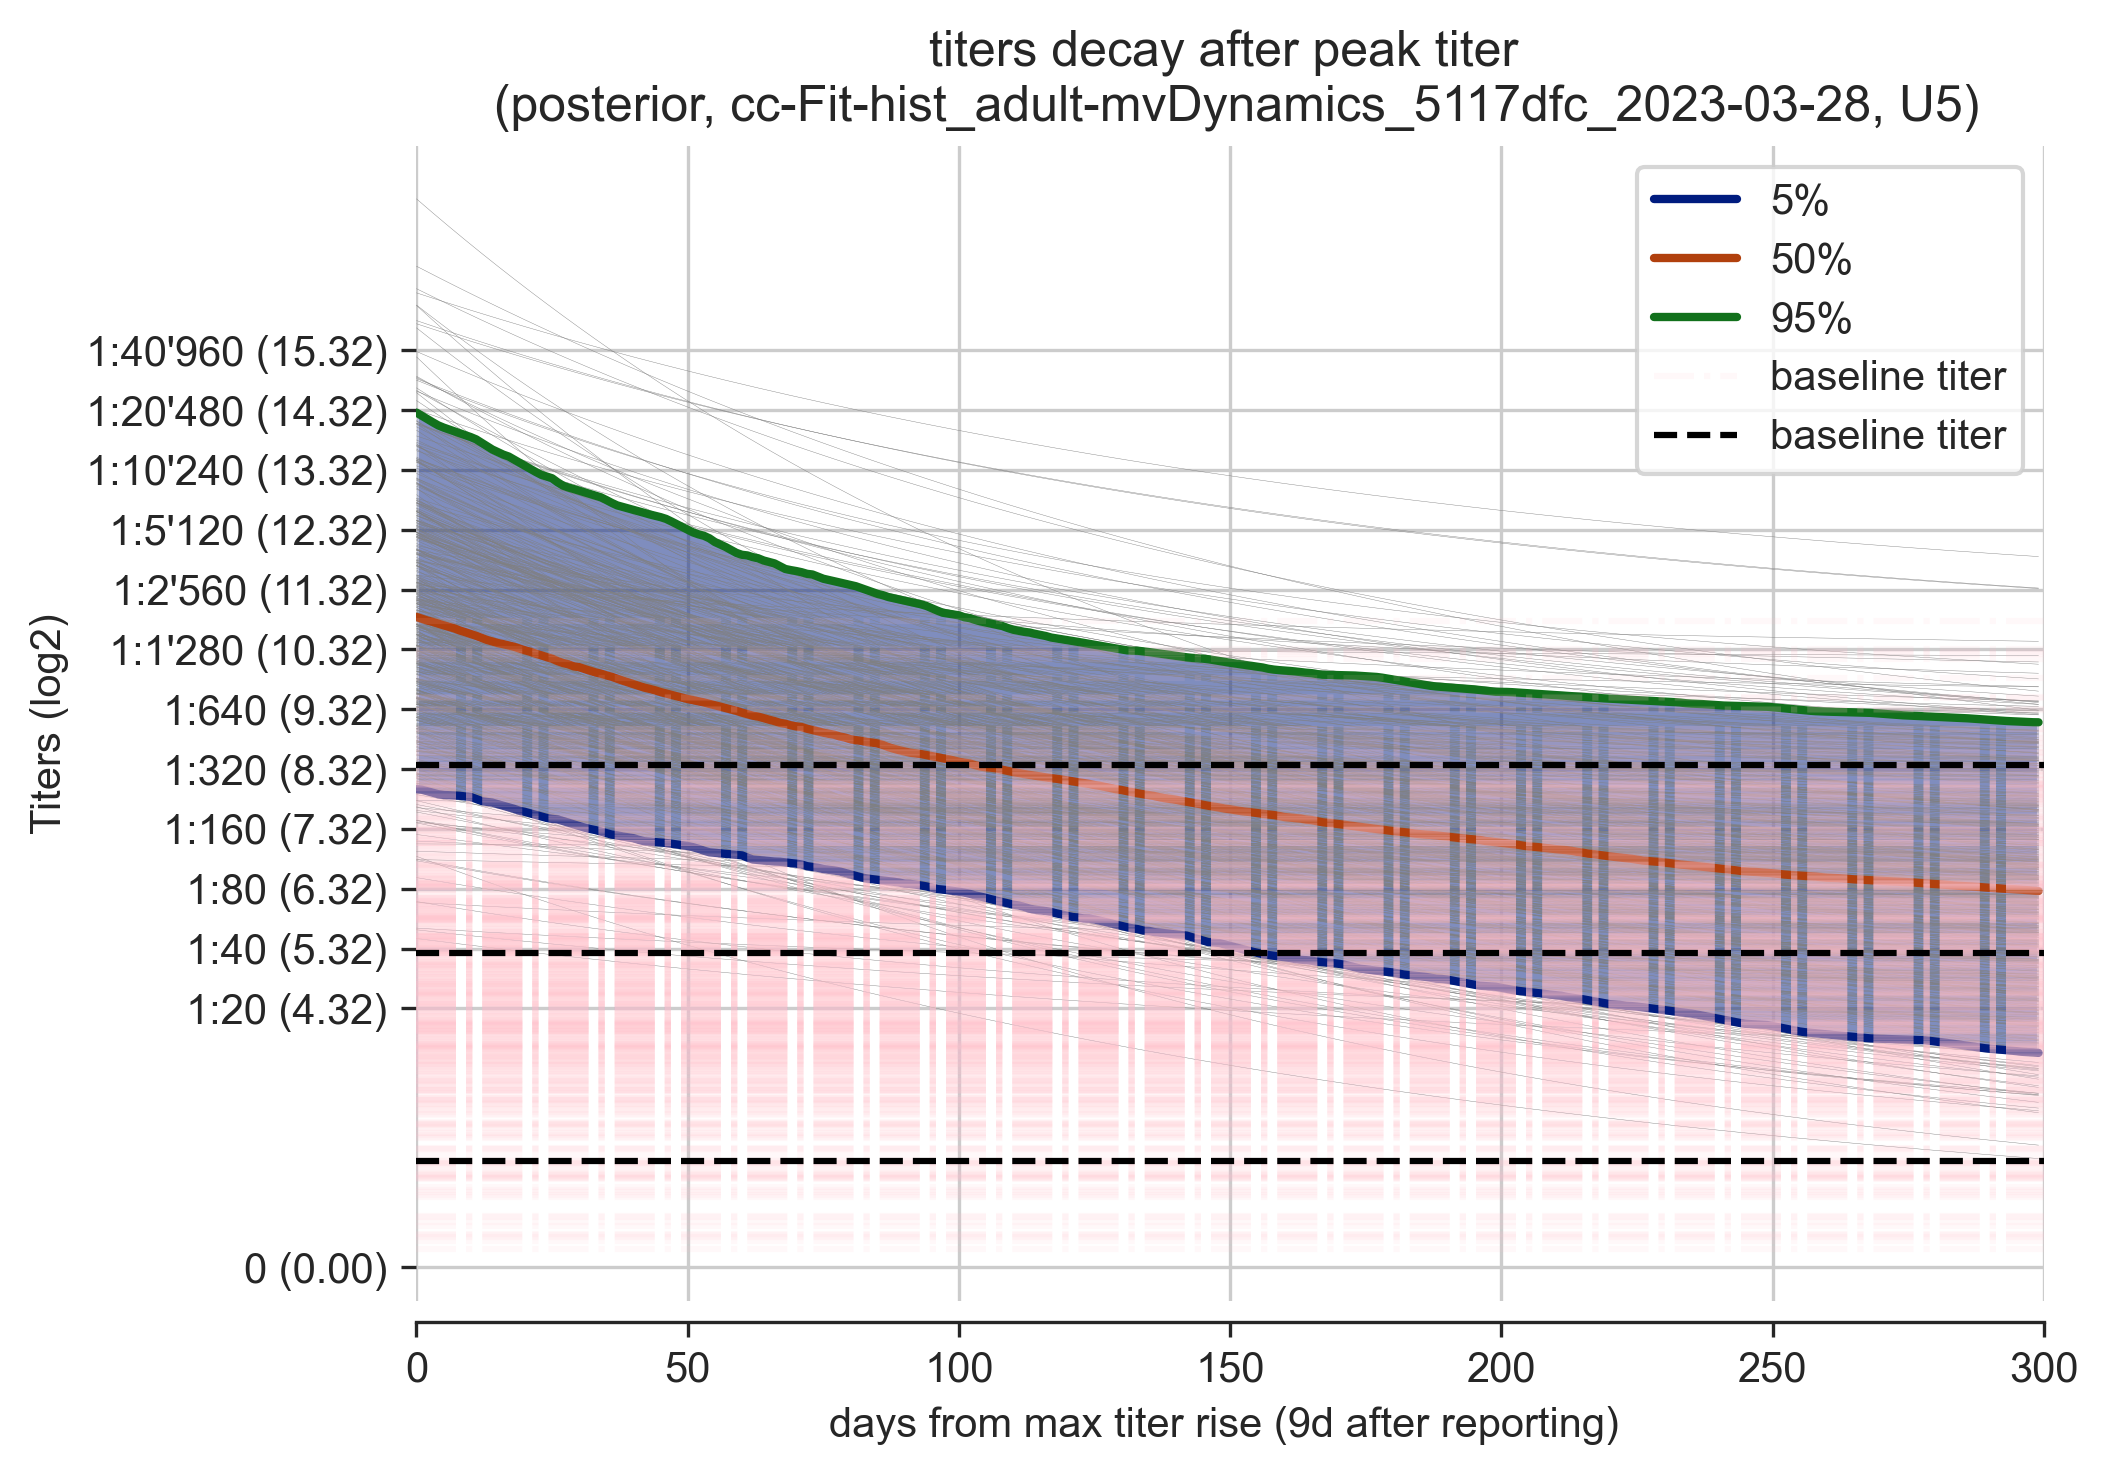

In [206]:
for age_to_plot in predictive_checks.keys():
    cases_gt, serosurvey_gt, n_population,\
        cases_arr, n_sampled, cases_total,\
        n_days, observed_count = get_gt_data(age_to_plot)

    llambda = trace[age_to_plot]["lambda"].values.ravel()
    #llambda = trace["titer_params"].sel(chain=slice(None), draw=slice(None), titer_params_dim_0=slice(None), titer_params_dim_1=1).values.ravel()
    omega_bar = trace[age_to_plot]["omega_p"].values.ravel()
    #omega_bar = trace["titer_params"].sel(chain=slice(None), draw=slice(None), titer_params_dim_0=slice(None), titer_params_dim_1=0).values.ravel()
    delta = trace[age_to_plot]["delta"].values.ravel().repeat(n_sampled)

    if len(llambda) > 1000:
        subsampling=len(llambda)//1000
        llambda = llambda[::subsampling]
        omega_bar = omega_bar[::subsampling]
        delta = delta[::subsampling]

    t_max= 300
    t_days = np.tile(np.arange(0, t_max), [len(llambda),1]).T  # todo should start at -7 ?

    max_lines_plotted = 500

    titers = omega_bar + llambda * np.exp(-delta * (t_days))
    titers_q = np.quantile(titers, q=[0.05, 0.5, 0.95], axis=1)

    fig, ax = plt.subplots(1, 1, figsize = (7,5), dpi=300)
    ax.plot(titers[:,:max_lines_plotted], c='grey', lw=0.1) # only the first 300 sims
    ax.fill_between(t_days[:,0], titers_q.T[:,0], titers_q.T[:,2], alpha=0.5)
    ax.plot(titers_q.T, label = ["5%", "50%", "95%"], lw=2)

    sns.despine(ax = ax, offset = 5, left = True, trim = True)
    ax.hlines(omega_bar[:max_lines_plotted], 0, t_max, linestyles = "-.", color='pink', alpha=0.1, label = "baseline titer",)
    ax.hlines(np.quantile(omega_bar, q=[0.05, 0.5, 0.95]), 0, t_max, linestyles = "dashed", color='k', label = "baseline titer",)
    ax.grid()
    ax.legend()
    ax.set_xlim(0, t_max)
    #ax.set_ylim(0)
    ax.set_xlabel(f"days from max titer rise ({delay_report2peaktiter}d after reporting) ")
    ax.set_ylabel("Titers (log2)") #  fontdict={'fontsize': 'small'}
    ax.set_title(f"titers decay after peak titer \n ({to_plot}, {model_id}, {age_to_plot})")
    ax.set_yticks(bin_lower_lim)
    ax.set_yticklabels(bins_pretty_wlog);
    #ax.xaxis.set_tick_params(labelsize=8)
    plt.savefig(f"{model_folder}/titers_decay_{to_plot}_{model_id}_{age_to_plot}.png", dpi=300, bbox_inches='tight')

/var/folders/pj/15hxgl0j1wg2w_t5k7bvnq5c0000gn/T/ipykernel_56359/3150985642.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_scatter = serosurvey_gt[~serosurvey_df["DateDiar"].isna()]
/var/folders/pj/15hxgl0j1wg2w_t5k7bvnq5c0000gn/T/ipykernel_56359/3150985642.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_scatter.loc[:,"offset"] = (data_scatter["date"]-data_scatter["DateDiar"]).dt.days
/var/folders/pj/15hxgl0j1wg2w_t5k7bvnq5c0000gn/T/ipykernel_56359/3150985642.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_scatter = serosurvey_gt[~serosurvey_df["DateDiar"].isna()]
/var/folders/pj/15hxgl0j1wg2w_t5k7bvnq5c0000gn/T/ipykernel_56359/3150985642.py:63: Setting

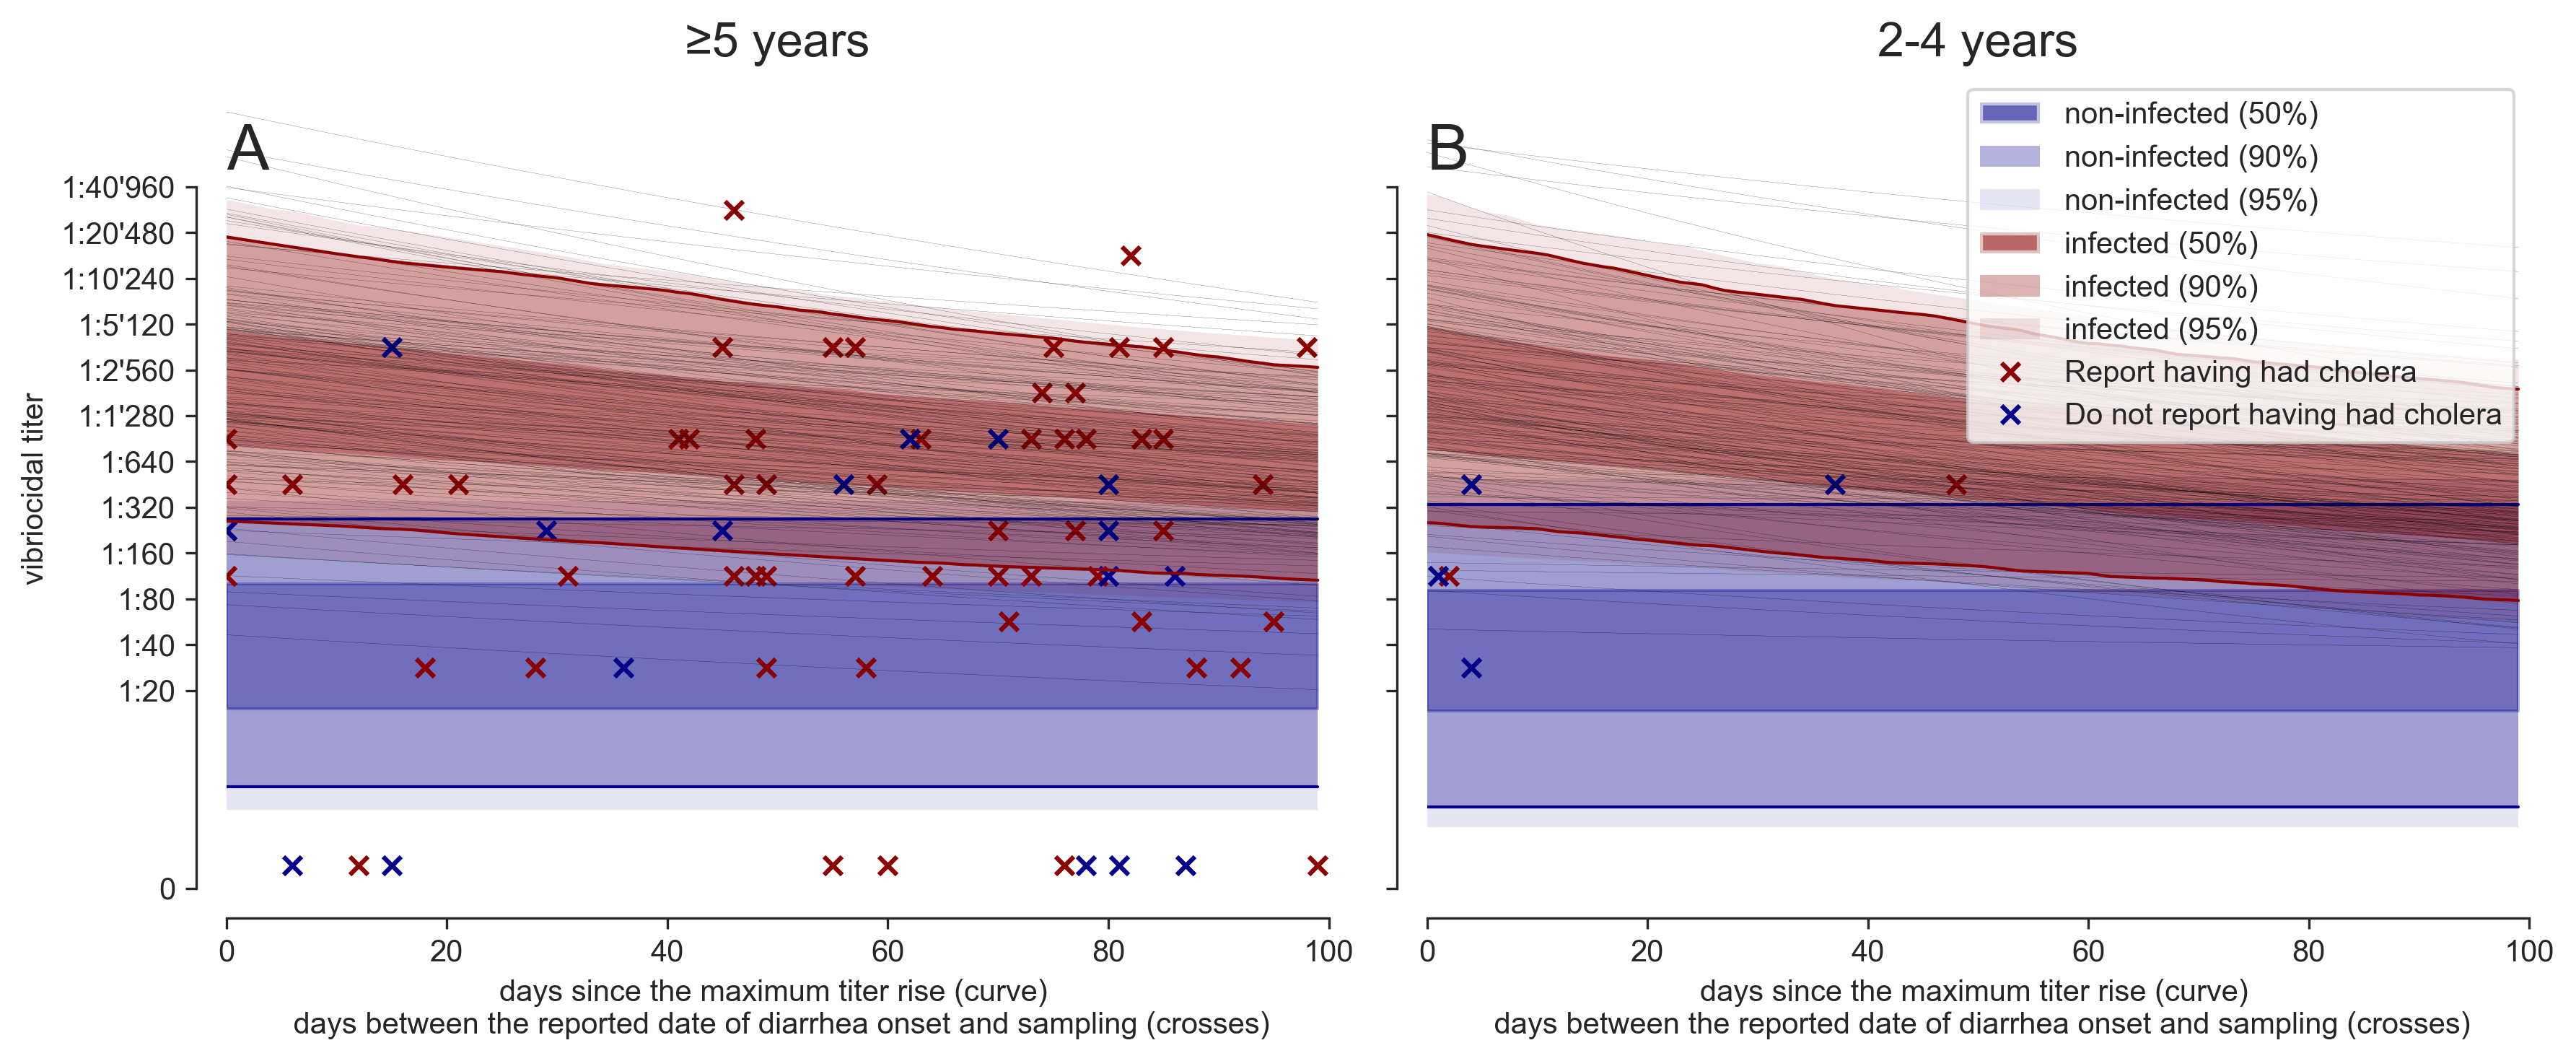

In [209]:
fig, axes = plt.subplots(1, 2, figsize = (12,5), dpi=300, sharey=True)

for i, age_to_plot in enumerate(["adult", "U5"]):
    ax =axes.flat[i]
    cases_gt, serosurvey_gt, n_population,\
        cases_arr, n_sampled, cases_total,\
        n_days, observed_count = get_gt_data(age_to_plot)

    llambda = trace[age_to_plot]["lambda"].values.ravel()
    #llambda = trace["titer_params"].sel(chain=slice(None), draw=slice(None), titer_params_dim_0=slice(None), titer_params_dim_1=1).values.ravel()
    omega_bar = trace[age_to_plot]["omega_p"].values.ravel()
    #omega_bar = trace["titer_params"].sel(chain=slice(None), draw=slice(None), titer_params_dim_0=slice(None), titer_params_dim_1=0).values.ravel()
    delta = trace[age_to_plot]["delta"].values.ravel().repeat(n_sampled)

    if len(llambda) > 1000:
        subsampling=len(llambda)//1000
        llambda = llambda[::subsampling]
        omega_bar = omega_bar[::subsampling]
        delta = delta[::subsampling]

    color_noinf="darkblue"
    color_inf = "darkred"

    t_max= 100
    t_days = np.tile(np.arange(0, t_max), [len(llambda),1]).T  # todo should start at -7 ?

    max_lines_plotted = 200

    baseline_q = np.quantile(omega_bar, q=[0.025, 0.5, 0.975])
    ax.fill_between(np.array([0, t_max-1]), 
                    np.array([baseline_q.T[0], baseline_q.T[0]]), 
                    np.array([baseline_q.T[2], baseline_q.T[2]]), alpha=0.1, color=color_noinf, lw=0)
    baseline_q = np.quantile(omega_bar, q=[0.05, 0.5, 0.95])
    ax.fill_between(np.array([0, t_max-1]), 
                    np.array([baseline_q.T[0], baseline_q.T[0]]), 
                    np.array([baseline_q.T[2], baseline_q.T[2]]), alpha=0.3, color=color_noinf, lw=0)
    ax.plot(np.array([0, t_max-1]),np.array([baseline_q.T[0], baseline_q.T[0]]), c=color_noinf, lw=1)
    ax.plot(np.array([0, t_max-1]),np.array([baseline_q.T[2], baseline_q.T[2]]), c=color_noinf, lw=1)
    baseline_q = np.quantile(omega_bar, q=[0.25, 0.5, 0.75])
    ax.fill_between(np.array([0, t_max-1]), 
                np.array([baseline_q.T[0], baseline_q.T[0]]), 
                np.array([baseline_q.T[2], baseline_q.T[2]]), alpha=0.3, color=color_noinf, lw=1)

    titers = omega_bar + llambda * np.exp(-delta * (t_days))
    ax.plot(titers[:,:max_lines_plotted], c='black', lw=0.05, label="infected titer draws") # only the first 300 sims


    titers_q = np.quantile(titers, q=[0.025, 0.5, 0.975], axis=1)
    ax.fill_between(t_days[:,0], titers_q.T[:,0], titers_q.T[:,2], alpha=0.1, color=color_inf, lw=0)
    titers_q = np.quantile(titers, q=[0.05, 0.5, 0.95], axis=1)
    ax.fill_between(t_days[:,0], titers_q.T[:,0], titers_q.T[:,2], alpha=0.3, color=color_inf, lw=0)
    ax.plot(titers_q.T[:,0], c=color_inf, lw=1)
    ax.plot(titers_q.T[:,2], c=color_inf, lw=1)
    titers_q = np.quantile(titers, q=[0.25, 0.5, 0.75], axis=1)
    ax.fill_between(t_days[:,0], titers_q.T[:,0], titers_q.T[:,2], alpha=0.3, color=color_inf, lw=0)
    #ax.plot(titers_q.T, label = ["5%", "50%", "95%"], lw=2)

    
    #ax.hlines(omega_bar[:max_lines_plotted], 0, t_max, linestyles = "-.", color='pink', alpha=0.1, label = "baseline titer",)
    #ax.hlines(np.quantile(omega_bar, q=[0.05, 0.5, 0.95]), 0, t_max, linestyles = "dashed", color='k', label = "baseline titer",)

    data_scatter = serosurvey_gt[~serosurvey_df["DateDiar"].isna()]
    data_scatter.loc[:,"offset"] = (data_scatter["date"]-data_scatter["DateDiar"]).dt.days

    split = "Cholera"
    ds = data_scatter[data_scatter[split]==1]
    ax.scatter(x=ds["offset"], y=ds["titermax_log2"]+.5, marker='x', color="darkred")
    ds = data_scatter[data_scatter[split]==0]
    ax.scatter(x=ds["offset"], y=ds["titermax_log2"]+.5, marker='x', color="darkblue")


    #p1 = ax.plot(x, y, color='b', linewidth=3)
    p1 = ax.fill(np.NaN, np.NaN, facecolor=color_noinf, alpha=0.6, lw=2)#, edgecolor=color_noinf)
    p2 = ax.fill(np.NaN, np.NaN, color_noinf, alpha=0.3, lw=0)
    p3 = ax.fill(np.NaN, np.NaN, color_inf, alpha=0.6, lw=2)#, edgecolor=color_inf,)
    p4 = ax.fill(np.NaN, np.NaN, color_inf, alpha=0.3, lw=0)
    from matplotlib.lines import Line2D
    p5 = Line2D([0], [0], marker='x', color='darkred',lw=0,
                            markerfacecolor='darkred', markersize=6, markeredgewidth=1.5)
    p6 = Line2D([0], [0], marker='x', color='darkblue',lw=0,
                            markerfacecolor='darkblue', markersize=6, markeredgewidth=1.5)
    p7 = ax.fill(np.NaN, np.NaN, color_noinf, alpha=0.1, lw=0)
    p8 = ax.fill(np.NaN, np.NaN, color_inf, alpha=0.1, lw=0)

    if i==1:
        ax.legend(  [(p1[0],),(p2[0],),(p7[0],),(p3[0],),(p4[0],),(p8[0],),(p5,),(p6,) ], 
                    ['non-infected (50%)', 'non-infected (90%)','non-infected (95%)', 
                    'infected (50%)', 'infected (90%)','infected (95%)', 
                    'Report having had cholera', 'Do not report having had cholera'], 
                    frameon=True, loc="upper right" )

    #ax.legend()
    ax.set_xlim(0, t_max)
    #ax.set_ylim(0)
    ax.set_xlabel(f"days since the maximum titer rise (curve) \n days between the reported date of diarrhea onset and sampling (crosses)")
    if i == 0:ax.set_ylabel("vibriocidal titer") #  fontdict={'fontsize': 'small'}
    #ax.set_title(f"titers decay after peak titer \n ({to_plot}, {model_id}, {age_to_plot})")
    ax.set_yticks(bin_lower_lim)
    ax.set_yticklabels(bins_pretty);
    sns.despine(offset = {"left" : 10, "bottom" : 5}, trim = True, ax=ax)
    ax.set_title(legend_age[age_to_plot], fontsize = 16)
fig.tight_layout()
    #ax.xaxis.set_tick_params(labelsize=8)
for i, letter in enumerate("AB"): # C
      axes[i].text(0, .94, letter, transform=axes[i].transAxes,
      fontsize = 21, va='top')
plt.savefig(f"supp_decay.png", dpi=300, bbox_inches='tight')
plt.savefig(f"supp_decay.pdf", dpi=300, bbox_inches='tight')

### Posterior Predictive Checks

96 NA on 2622 elements
71 NA on 2495 elements
25 NA on 124 elements


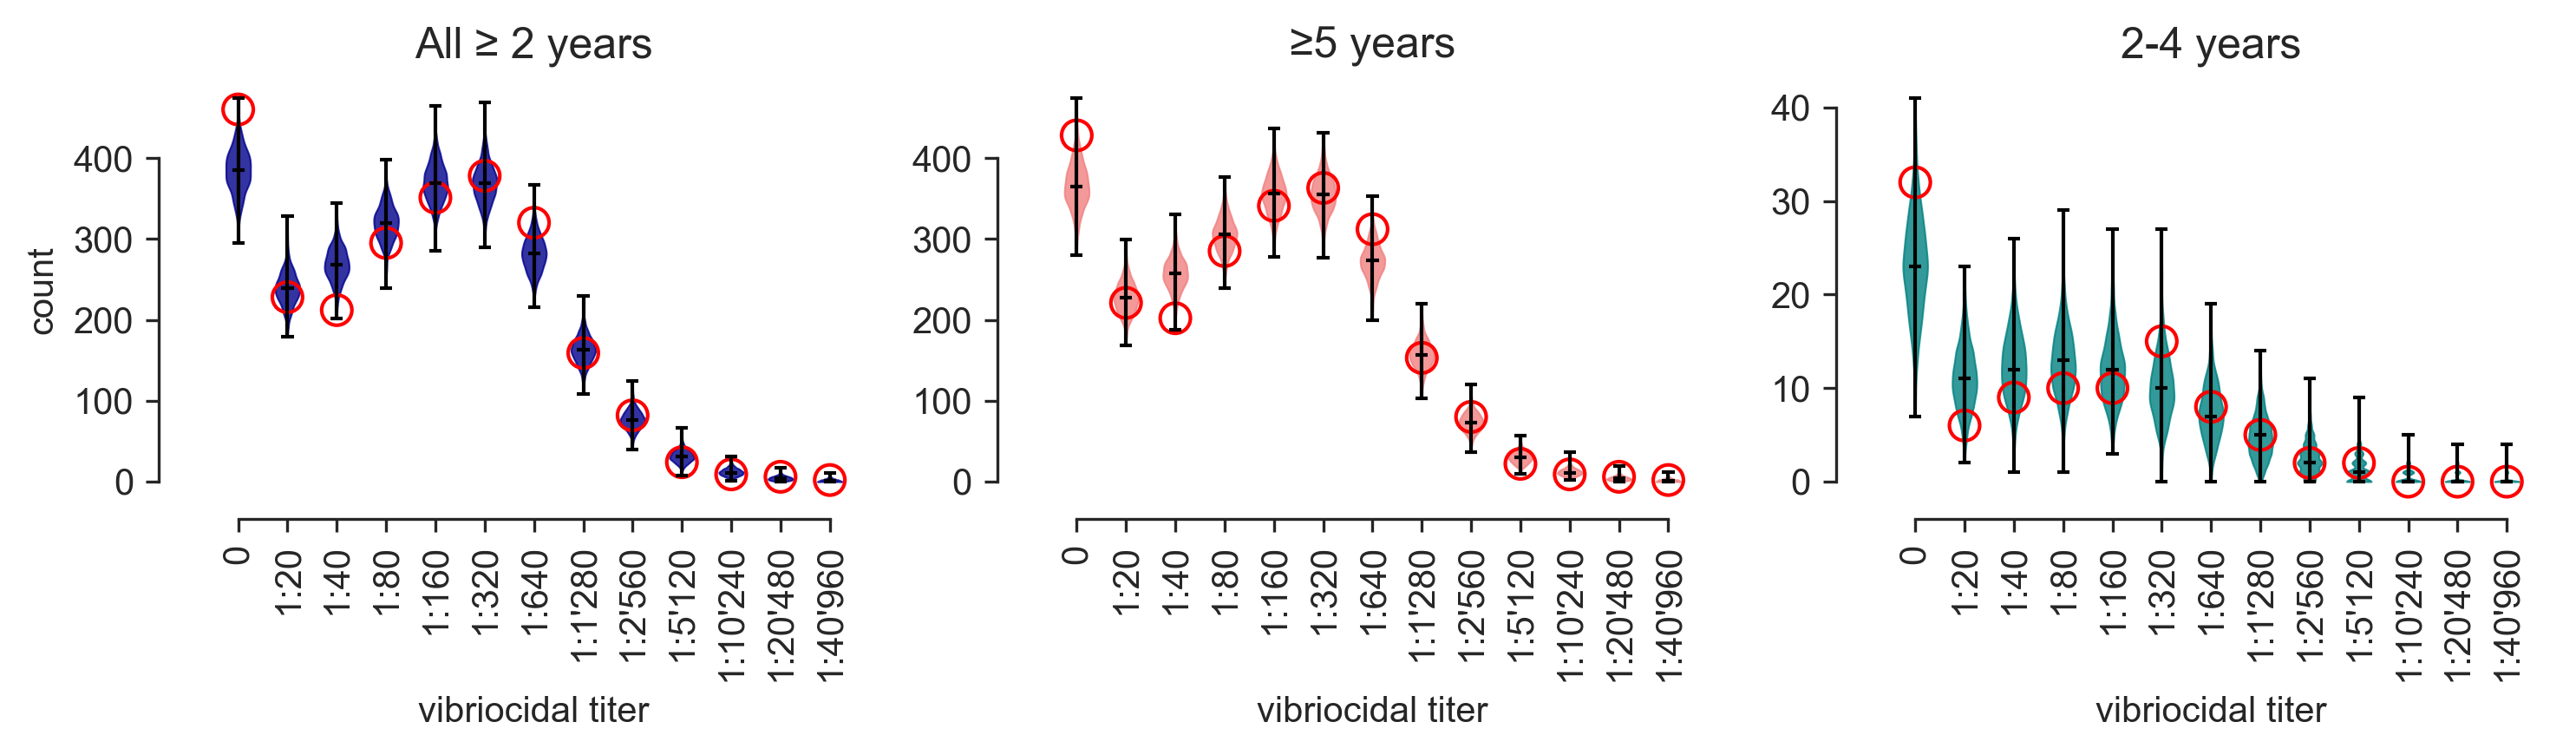

In [211]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3), dpi=300, sharex=True)
for k, age_to_plot in enumerate([ 'all','adult', 'U5']):
    cases_gt, serosurvey_gt, n_population,\
        cases_arr, n_sampled, cases_total,\
        n_days, observed_count = get_gt_data(age_to_plot)

    indiv_bin_df = serosurvey_gt[titer_var].copy()  # for plots: to which bin belong each file
    for i, bn in enumerate(bin_lower_lim):
        indiv_bin_df[indiv_bin_df == bn] = i
    print(indiv_bin_df.isna().sum(), "NA on", len(indiv_bin_df), "elements") 
    # ok so the difference between observed and observed is that the are missing 
    # values in the observed data

    ax = axes.flat[k]
    # Study 1 ----------------------------------------------------------------
    # !TODO! This is just the first chain, should mix !!! TODO
    # Plot observed bin counts
    
    #observed_count.plot(kind="bar", ax=ax, color = colors_age[age_to_plot], label = age_to_plot, alpha=0.3)

    # Plot posterior predictive
    #for i in range(predictive_checks["modeled_count"].shape[1]):
    #        plt.scatter(np.arange(0,13), predictive_checks["modeled_count"][0,i], alpha=1, s = .7)
    #plt.scatter(np.arange(0,), predictive_checks["modeled_count"][0].mean(axis=0), alpha=1, s = 90, c='k', marker='_')
    violin_parts = ax.violinplot(predictive_checks[age_to_plot]["modeled_count"][0,:], 
            positions=np.arange(0,len(bins_pretty)), showextrema=True, 
            showmedians=True, widths=0.5)
    for pc in violin_parts['bodies']:
        pc.set_facecolor(colors_age[age_to_plot])
        pc.set_alpha(.8)
        pc.set_linewidth(.5)
        pc.set_edgecolor(colors_age[age_to_plot])
    for partname in ('cbars','cmins','cmaxes','cmedians'):
        vp = violin_parts[partname]
        vp.set_edgecolor("black")
        vp.set_linewidth(1)
    ax.scatter(np.arange(0,len(bins_pretty)), observed_count, alpha=1, s = 70, facecolors='none', edgecolors='r', marker='o', label = "observed")

    # Formatting
    #ax.set_xticklabels([f"bin {n}" for n in range(len(cat_))])
    #ax.set_title(f"{to_plot} predictive samples {age_to_plot} \n ({model_id}, {age_to_plot})")
    
    #ax.legend()
   
    ax.set_xticks(np.arange(0,len(bins_pretty)))
    ax.set_xticklabels(bins_pretty,  rotation=90, fontdict={'fontsize': 'small'})
    ax.xaxis.set_tick_params( rotation=90)
    ax.set_xlabel("vibriocidal titer")
    if k==0: ax.set_ylabel("count")
    ax.set_title(legend_age[age_to_plot])


sns.despine(offset = {"left" : 10, "bottom" : 5}, trim = True)
fig.tight_layout()
plt.savefig(f"{model_folder}/predictive_checks_{to_plot}_{model_id}_{age_to_plot}.png", dpi=300, bbox_inches='tight')
plt.savefig(f"supp_ppc.png", dpi=300, bbox_inches='tight')
plt.savefig(f"supp_ppc.pdf", dpi=300, bbox_inches='tight')

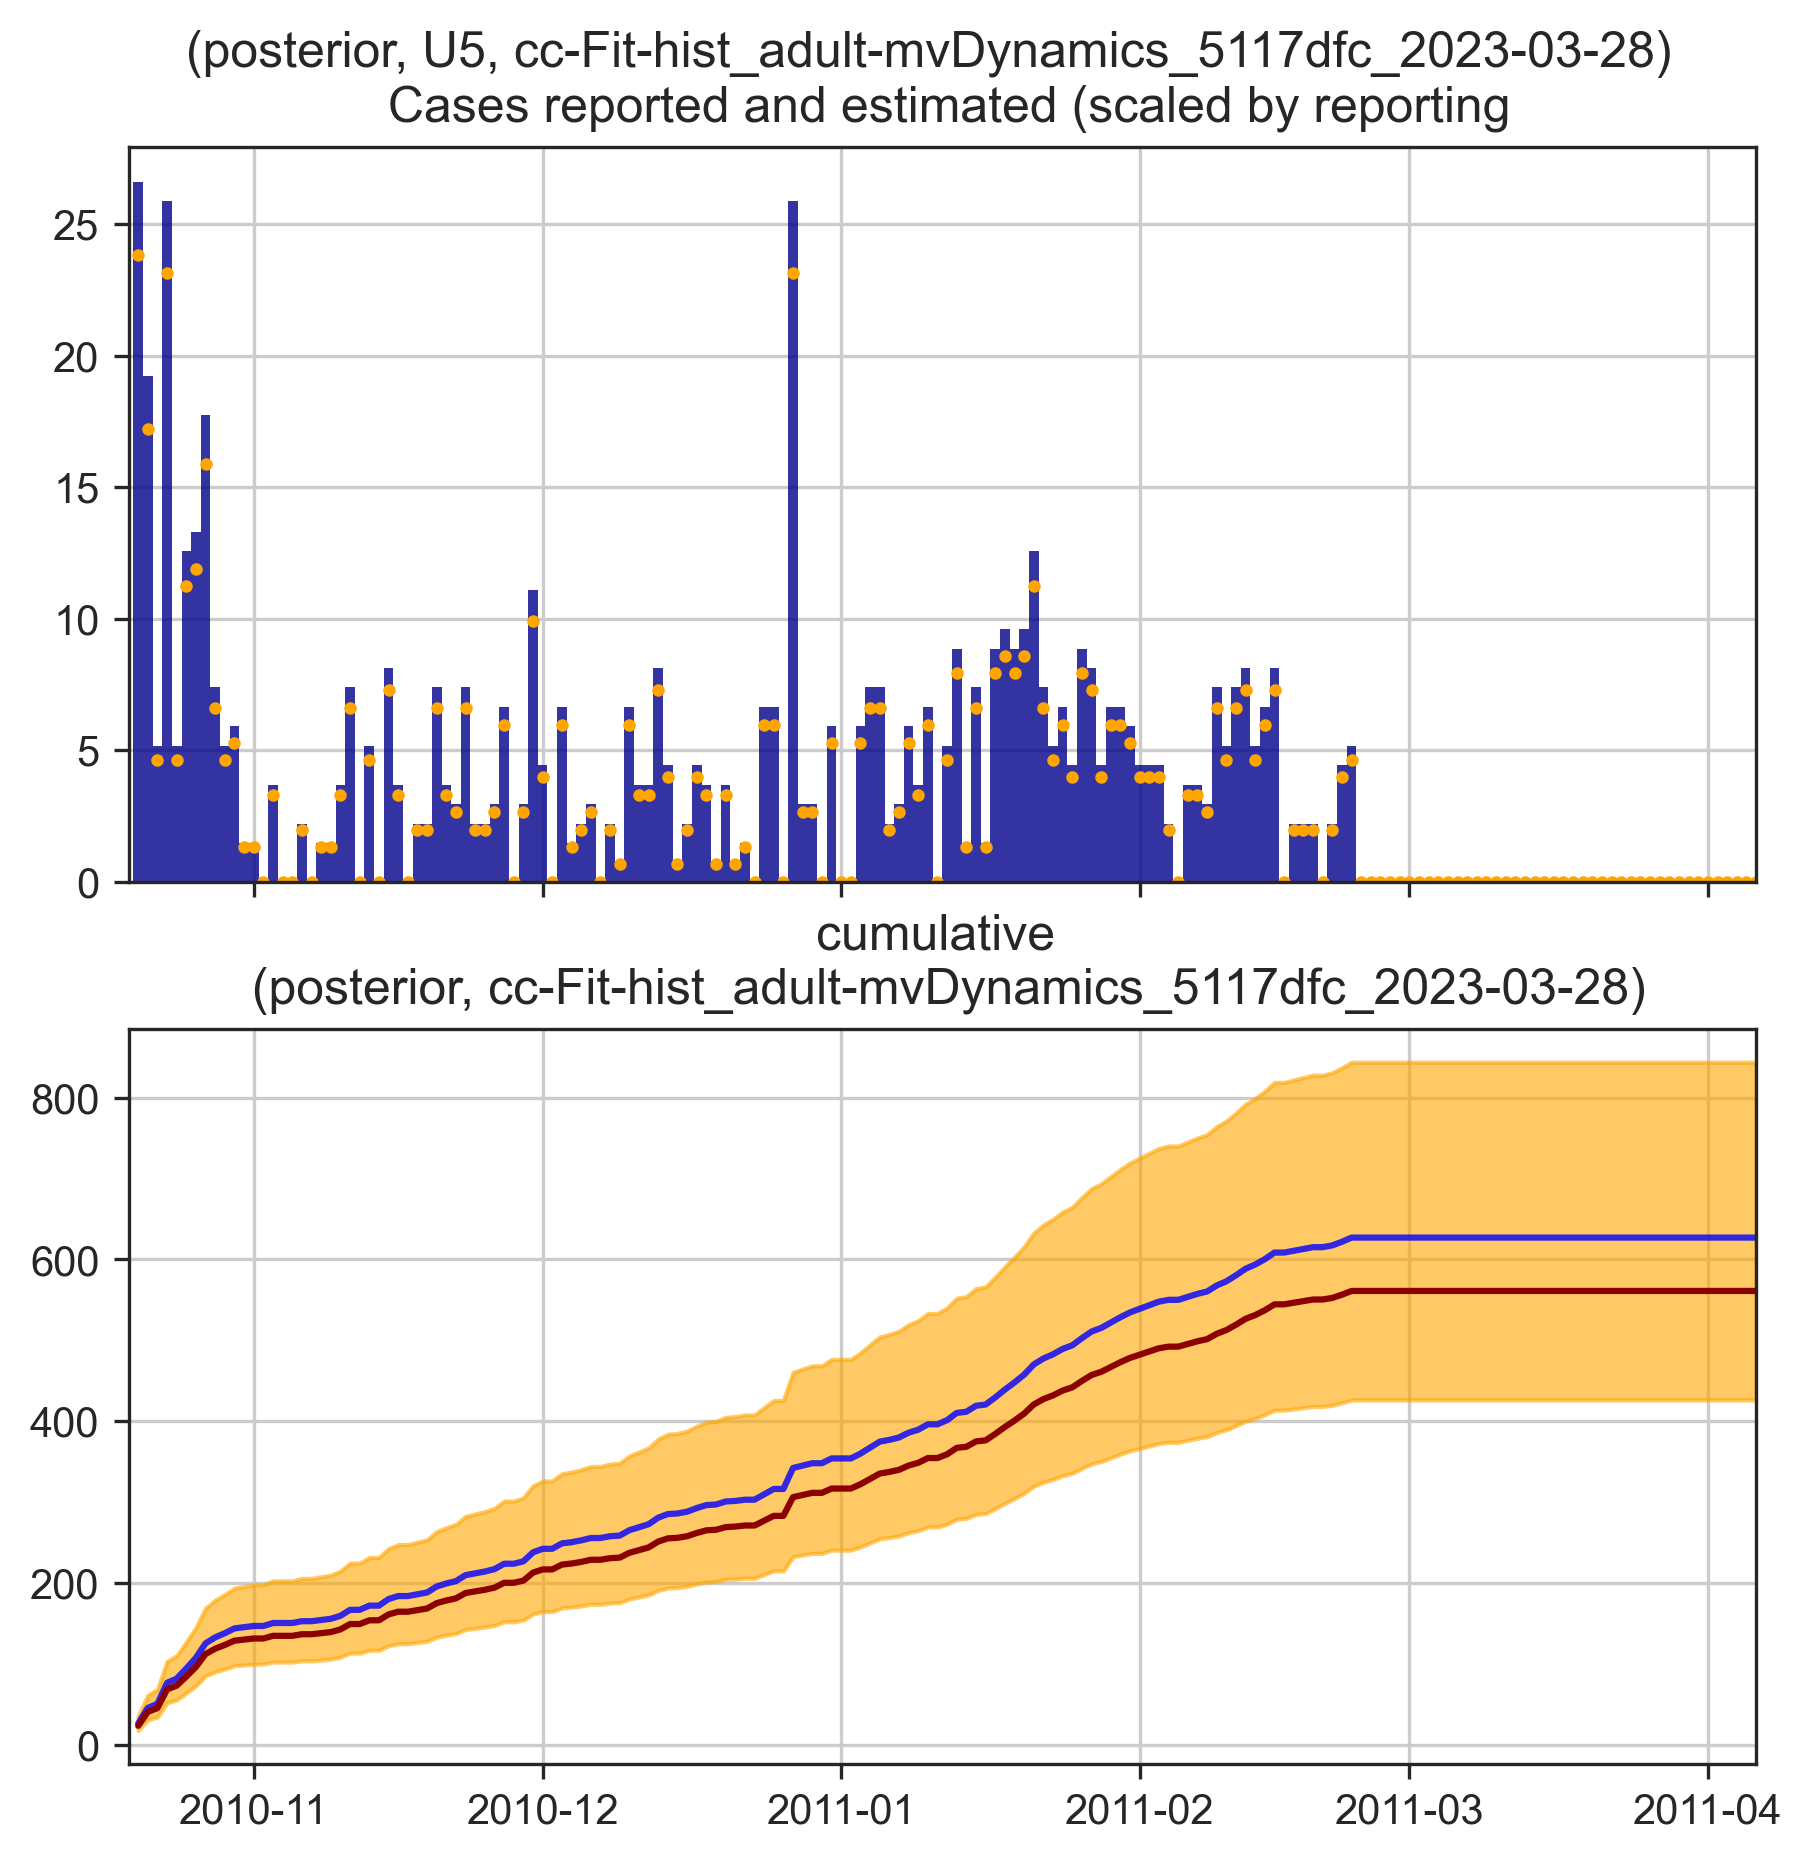

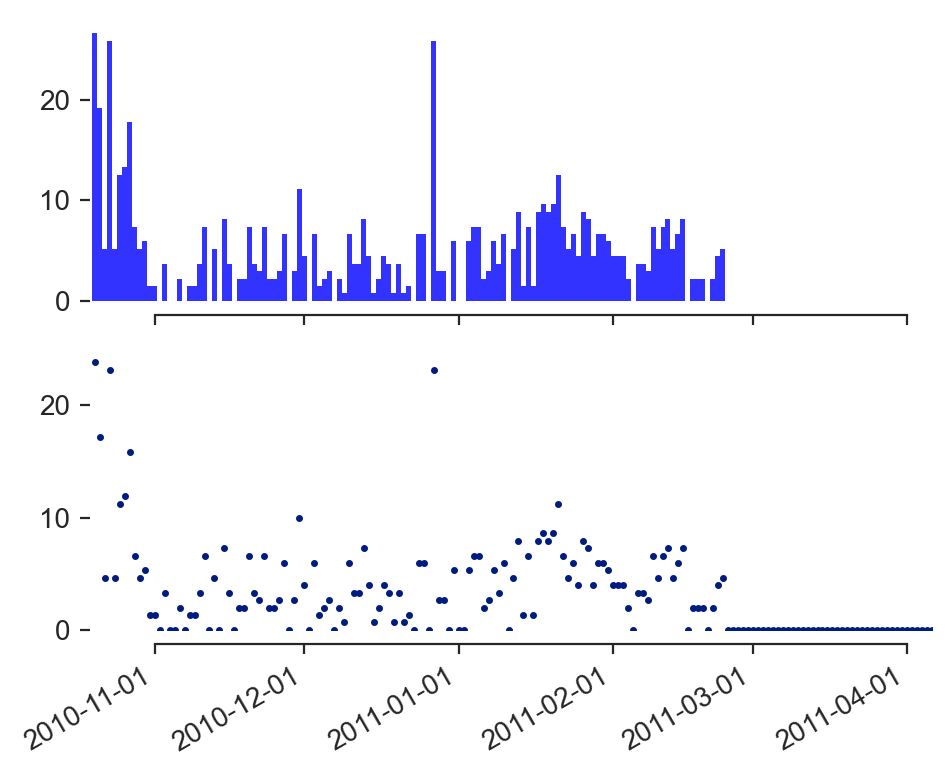

In [212]:
# TODO: Here posterior predictive or posterior ? TODO REDO THIS CELL !
age_to_plot = "adult"

for age_to_plot in predictive_checks.keys():
    cases_gt, serosurvey_gt, n_population,\
        cases_arr, n_sampled, cases_total,\
        n_days, observed_count = get_gt_data(age_to_plot)

quantiles = np.quantile(trace[age_to_plot].rho, q=[0.025, .5, 0.975])

median = 1/quantiles[1]*cases_gt.values
q025 = 1/quantiles[0]*cases_gt.values
q975 = 1/quantiles[2]*cases_gt.values

fig, axes = plt.subplots(2, 1, figsize = (7,7), dpi=300, sharex=True)
ax = axes.flat[0]
ax.bar(cases_gt.index, cases_gt.values, color='darkblue', alpha=0.8, width=pd.Timedelta(days=1), lw=0)
yerr=[median-q025, q975-median]
yerr[0][yerr[0]<0] = 0
yerr[1][yerr[1]<0] = 0
ax.errorbar(cases_gt.index,
		median,
		yerr=yerr,
		fmt = ".",
		markersize = 4,
		color='orange')
ax.grid()
ax.set_title(f"({to_plot}, {age_to_plot}, {model_id})  \n Cases reported and estimated (scaled by reporting")

ax = axes.flat[1]
ax.plot(cases_gt.index, cases_gt.values.cumsum(), color='blue', alpha=0.8)
ax.fill_between(cases_gt.index, q025.cumsum(), q975.cumsum(), alpha=.6, color='orange')
ax.plot(cases_gt.index, median.cumsum(), color='darkred', alpha=1)
ax.grid()
ax.set_title(f"cumulative \n ({to_plot}, {model_id})")
ax.set_xlim(cases_gt.index[0]-datetime.timedelta(days=1), cases_gt.index[-1])
plt.savefig(f"{model_folder}/cases_{to_plot}_{model_id}.png", dpi=300, bbox_inches='tight')

fig, axes = plt.subplots(2, 1, figsize = (5,4), dpi=200, sharex=True)
ax = axes.flat[0]
ax.bar(cases_gt.index, cases_gt.values, color='blue', alpha=0.8, width=pd.Timedelta(days=1), lw=0)
ax.set_ylim(0)
sns.despine(ax = ax, offset = 5, left = True, trim = True)
ax = axes.flat[1]
yerr=[median-q025, q975-median]
yerr[0][yerr[0]<0] = 0
yerr[1][yerr[1]<0] = 0
ax.errorbar(cases_gt.index,
		median,
		yerr=yerr,
		fmt = ".",
		markersize = 3)

sns.despine(ax = ax, offset = 5, left = True, trim = True)
ax.set_xlim(cases_gt.index[0]-datetime.timedelta(days=1), cases_gt.index[-1])
ax.set_ylim(0)
fig.tight_layout()
fig.autofmt_xdate()
plt.savefig(f"{model_folder}/cases2_{to_plot}_{model_id}.png", dpi=300, bbox_inches='tight')

### Reporting and attack rate

There are two way of computing the attack & reporting rates:
- from if_inf_reported: mean of the draws --> capture better the uncertainties ?
  - **Yes, especially in `trace`(the posterior) as it really can be different (the draws that are selected do not always obey the property)**
- from rho, as `(cases_total/rho)/n_population`
as in the model, we use
```python
if_inf_reported = pm.Bernoulli("if_inf_reported",  
            p = (cases_total/rho)/n_population)
```

It's ok, it's quite consistent (as it was hinted by the pretty good posterior predictive plot of the data), see the two sanity check below:

In [213]:
print("Rho, from infected flag and directly from rho")
for age_to_plot in predictive_checks.keys():
    cases_gt, serosurvey_gt, n_population,\
        cases_arr, n_sampled, cases_total,\
        n_days, observed_count = get_gt_data(age_to_plot)
    print(f"mean of rho for {age_to_plot:<10} is {trace[age_to_plot]['rho'].values.ravel().mean():.2f} ", end="")
    p= trace[age_to_plot]["if_inf_reported"].values.sum(axis=2).ravel()/n_sampled
    p = p.mean()
    print(f"vs {cases_total/(p*n_population):.2f} from the if_infected vector")

print("Attack rate, from variable if_inf_reported  and from rho (comparison)")
for age_to_plot in predictive_checks.keys():
    cases_gt, serosurvey_gt, n_population,\
        cases_arr, n_sampled, cases_total,\
        n_days, observed_count = get_gt_data(age_to_plot)
    print(f"{age_to_plot:<10} % attack rate: {float(trace[age_to_plot].if_inf_reported.sum(axis=2).mean()/n_sampled):.2f} ", end="")
    print(f"vs {float((cases_total/trace[age_to_plot].rho.mean())/n_population):.2f} from rho")

Rho, from infected flag and directly from rho
mean of rho for adult      is 0.31 vs 0.31 from the if_infected vector
mean of rho for all        is 0.35 vs 0.35 from the if_infected vector
mean of rho for U5         is 1.12 vs 1.08 from the if_infected vector
Attack rate, from variable if_inf_reported  and from rho (comparison)
adult      % attack rate: 0.53 vs 0.53 from rho
all        % attack rate: 0.53 vs 0.53 from rho
U5         % attack rate: 0.36 vs 0.35 from rho


In [214]:
print("Reporting rate, from variable rho, for paper")
for age_to_plot in predictive_checks.keys():
    q = np.quantile(trace[age_to_plot]["rho"].values.ravel(), [0.5, 0.025, 0.975])
    print(f"{age_to_plot:<10} reporting rate: {q[0]:.1f} ({q[1]:.1f}-{q[2]:.1f})   :0.5 (0.025 -- 0.975)")

print("Attack rate, from variable if_inf_reported, for paper")
to_compare = {}
for age_to_plot in predictive_checks.keys():
    cases_gt, serosurvey_gt, n_population,\
        cases_arr, n_sampled, cases_total,\
        n_days, observed_count = get_gt_data(age_to_plot)
    quantiles_attack_rate = np.quantile(trace[age_to_plot]["if_inf_reported"].values.sum(axis=2).ravel()/n_sampled, [0.5 ,0.025, 0.975])
    to_compare[age_to_plot] = trace[age_to_plot]["if_inf_reported"].values.sum(axis=2).ravel()/n_sampled
    

    print(f"{age_to_plot:<10} % attack rate: {quantiles_attack_rate[0]*100:.1f}% (95%CrI {quantiles_attack_rate[1]*100:.1f}-{quantiles_attack_rate[2]*100:.1f})   :0.5 (0.025 -- 0.975)")

Reporting rate, from variable rho, for paper
adult      reporting rate: 0.3 (0.3-0.3)   :0.5 (0.025 -- 0.975)
all        reporting rate: 0.3 (0.3-0.4)   :0.5 (0.025 -- 0.975)
U5         reporting rate: 1.1 (0.7-1.5)   :0.5 (0.025 -- 0.975)
Attack rate, from variable if_inf_reported, for paper
adult      % attack rate: 53.1% (95%CrI 50.1-56.4)   :0.5 (0.025 -- 0.975)
all        % attack rate: 52.6% (95%CrI 49.4-55.7)   :0.5 (0.025 -- 0.975)
U5         % attack rate: 35.5% (95%CrI 24.2-51.6)   :0.5 (0.025 -- 0.975)


In [217]:
a = np.quantile(1-to_compare["U5"]/to_compare["adult"], [0.5 ,0.025, 0.975])*100
print(f"with young children (2-4 years old) having {a[0]:.1f}% (95% CrI {a[1]:.1f} to {a[2]:.1f}) lower infection risk than those 5 years and older,")

with young children (2-4 years old) having 32.5% (95% CrI 2.4 to 54.1) lower infection risk than those 5 years and older,


/Users/chadi/anaconda3/envs/haiti-sero_pymc4/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chadi/anaconda3/envs/haiti-sero_pymc4/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/chadi/anaconda3/envs/haiti-sero_pymc4/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chadi/anaconda3/envs/haiti-sero_pymc4/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na 

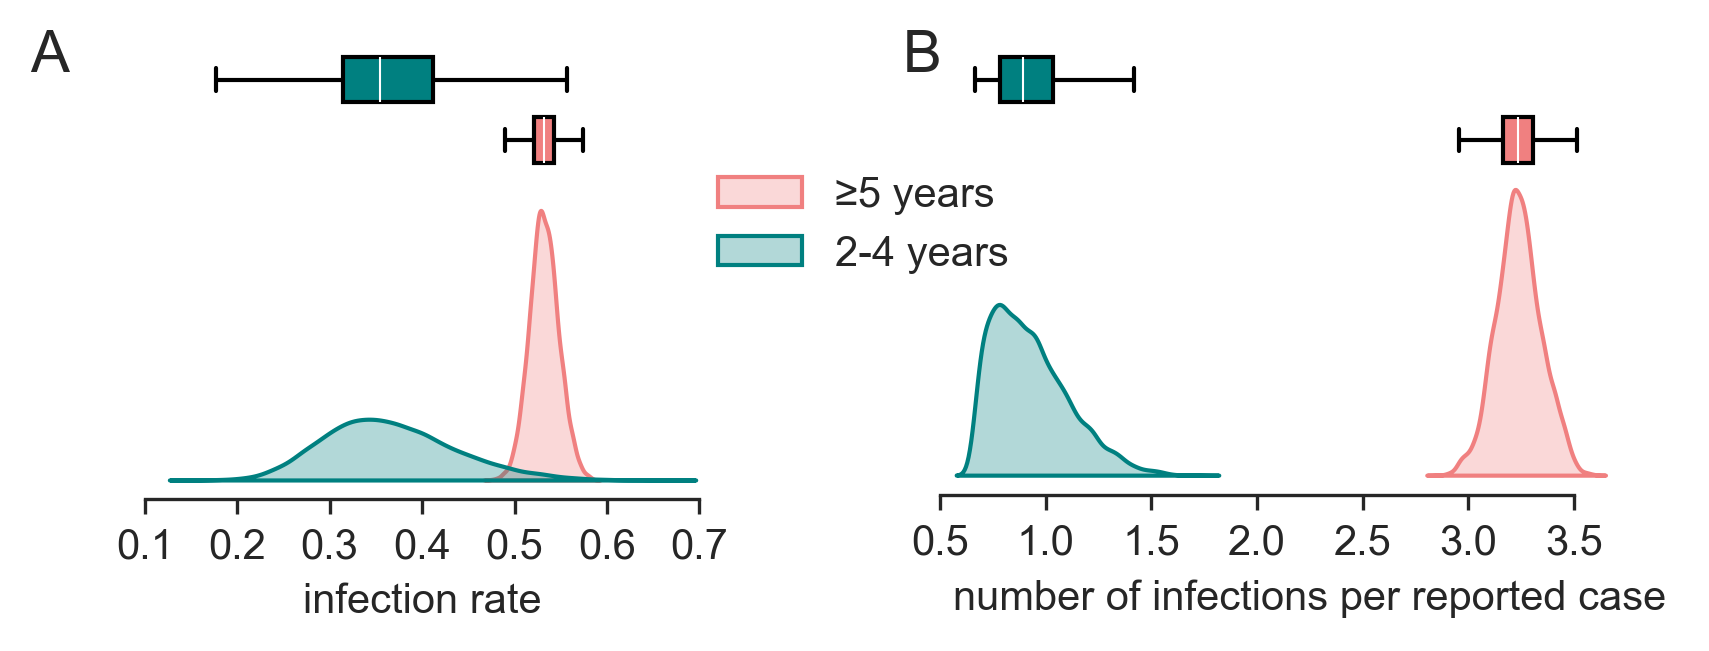

In [218]:
to_plot_on_this_graph = ["adult","U5"]
fig, axes = plt.subplots(1, 2, figsize = (7,2), dpi=300)
ax = axes[0]
colors_age = {"adult": "lightcoral", "U5": "teal"}
#colors_age = {"adult": "lightcoral", "U5": "slategray"}
legend_age = {"adult": "≥5 years", "U5": "2-4 years", "all": "All ≥ 2 years"}
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Reporting rate
divider = make_axes_locatable(ax)
ax2 = divider.append_axes("top", size="30%", pad=-.2)
fig.add_axes(ax2)
a = []
for k, age_to_plot in enumerate(to_plot_on_this_graph):
    cases_gt, serosurvey_gt, n_population,\
        cases_arr, n_sampled, cases_total,\
        n_days, observed_count = get_gt_data(age_to_plot)
    #ax.hist
    sns.kdeplot(trace[age_to_plot]["if_inf_reported"].values.sum(axis=2).ravel()/n_sampled, 
        #density = True, bins=15, 
        label=legend_age[age_to_plot],
        color=colors_age[age_to_plot], 
        fill=True,
        alpha=.3,
        lw=1,
        ax=ax)
    a.append(trace[age_to_plot]["if_inf_reported"].values.sum(axis=2).ravel()/n_sampled)
bplot = ax2.boxplot(a,
        vert=False,
        showfliers=False,
        #color=colors_age[age_to_plot],
        #ax=ax2,
        #linewidth=1,
        #dodge=True,
        #fliersize=0
        patch_artist=True,
        widths=0.75,
        medianprops={"color": "white", "linewidth":.5 },
        )
# fill with colors (insane that this is necessary, https://matplotlib.org/stable/gallery/statistics/boxplot_color.html#sphx-glr-gallery-statistics-boxplot-color-py)
for patch, color in zip(bplot['boxes'], to_plot_on_this_graph):
    patch.set_facecolor(colors_age[color])
ax2.set_yticklabels("")
ax2.set_xticklabels("")
ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')
sns.despine(ax = ax2, bottom=True, left = True)

ax.set_xlabel("infection rate")
ax.set_xticks(np.arange(.1,.71,0.1))
ax.set_yticklabels("")
ax.set_ylabel("")
ax.set_xlim(0.0,0.8)
ax2.set_xlim(0.0,0.8)
ax.set_ylim(-3,35)
sns.despine(ax = ax,  offset = -3, left = True, trim = True)
ax.yaxis.set_ticks_position('none')
#sns.despine(ax = ax, offset = 5, left = True, trim = True)
# add the ticks to the lower axes:
ax2s = [ax2]


# Attack rate
ax = axes[1]
for age_to_plot in to_plot_on_this_graph:
    sns.kdeplot(1/trace[age_to_plot]["rho"].values.ravel(), 
        #density = True,  bins=30, 
        color=colors_age[age_to_plot],
        label=legend_age[age_to_plot], 
        ax=ax, 
        fill=True,
        alpha=.3,
        lw=1,
    )
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
ax2 = divider.append_axes("top", size="30%", pad=-.2)
fig.add_axes(ax2)
a=[]
for age_to_plot in to_plot_on_this_graph:
    a.append(1/trace[age_to_plot]["rho"].values.ravel())

bplot = ax2.boxplot(a,
        vert=False,
        showfliers=False,
        #color=colors_age[age_to_plot],
        #ax=ax2,
        #linewidth=1,
        #dodge=True,
        #fliersize=0
        patch_artist=True,
        widths=0.75,
        medianprops={"color": "white", "linewidth":.5 },
        )
# fill with colors (insane that this is necessary, https://matplotlib.org/stable/gallery/statistics/boxplot_color.html#sphx-glr-gallery-statistics-boxplot-color-py)
for patch, color in zip(bplot['boxes'], to_plot_on_this_graph):
    patch.set_facecolor(colors_age[color])
ax2.set_yticklabels("")
ax2.set_xticklabels("")
ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')
sns.despine(ax = ax2, bottom=True, left = True)
sns.despine(ax = ax2, bottom=True, left = True)
ax2.set_xticklabels("")
# if not plotting the inverse
#ax2.set_xlim(.1,1.7)
#ax.set_xlim(.1,1.7)
#ax.set_xticks(np.arange(.2,1.65,0.2))
#ax.set_ylim(-4,50)
#if plotting the inverse
ax2.set_xlim(.5,4)
ax.set_xlim(.5,4)
ax.set_xticks(np.arange(.5,4,.5))
ax.set_ylim(-.5,5)
ax.set_xlabel("number of infections per reported case")
ax.set_yticklabels("")
ax.set_ylabel("")
sns.despine(ax = ax,  offset = -4, left = True, trim = True)
ax.yaxis.set_ticks_position('none')
ax2s.append(ax2)

ax.legend(loc="lower left", frameon=False, bbox_to_anchor=(-.35,.5))

for i, letter in enumerate("AB"):
    if letter=="B":
      ax2s[i].text(-.05, 1.2, letter, transform=axes[i].transAxes,
      fontsize = 14, va='top')
    else:
        ax2s[i].text(-0.03, 1.2, letter, transform=axes[i].transAxes,
      fontsize = 14, va='top')
plt.savefig(f"{model_folder}/reporting_params_{to_plot}_{model_id}.png", dpi=300, bbox_inches='tight')
plt.savefig(f"fig2.png", dpi=300, bbox_inches='tight')
plt.savefig(f"fig2.pdf", dpi=300, bbox_inches='tight')

### Probability of infection

This is harder than before because I don't exactly know, for each individual which bin it has been sampled into. 
So I need to do a bit of fractional repartition according to titer_bin_per_event, which contain the probability that each individual ends up in each bin
For each bin we want the probabilty of someone being in that bin that has been infected
- if_inf_reported contains if individual is infected or not in this sample
- titer_bin_per_event: for each bin and each individual, probability that bin i is measured for individual x

In [219]:
# let's shrink the 4 chains together
titer_bins_per_event = {}
day_inf_reported = {}
if_inf_reported = {}
peak_titer = {}
baseline_titer = {}
masked_infected = {}
masked_infected_bin = {}
titer_bins_per_event_masked4inf = {}
prob_infect = {}

for age_to_plot in predictive_checks.keys():
    titer_bins_per_event[age_to_plot] = utils.combine_dims(np.array(predictive_checks[age_to_plot].titer_bins_per_event))  # (8000, 13, n_sampled)  for each bin and each individual, probability that bin i is measured for individual x
    day_inf_reported[age_to_plot] = utils.combine_dims(np.array(predictive_checks[age_to_plot].day_inf_reported))          # (8000, n_sampled)
    if_inf_reported[age_to_plot] = utils.combine_dims(np.array(predictive_checks[age_to_plot].if_inf_reported))            # (8000, n_sampled) 
    peak_titer[age_to_plot] = utils.combine_dims(np.array(trace[age_to_plot]["lambda"]))                                   # (8000, n_sampled)
    baseline_titer[age_to_plot] = utils.combine_dims(np.array(trace[age_to_plot]["omega_p"]))                              # (8000, n_sampled)

    # a mask to single-out infected individuals
    # 2**x%2 invert the binary array: https://stackoverflow.com/questions/39164786/invert-0-and-1-in-a-binary-array
    masked_infected[age_to_plot] = 2**if_inf_reported[age_to_plot]%2                                                       # size 80000 X n_sampled. Here it is 0 for infected and 1 for non-infected (numpy mask: 1 is masked, 0 is not masked)
    masked_infected_bin[age_to_plot] = np.repeat(masked_infected[age_to_plot][:,:, np.newaxis], len(bins_pretty), axis=2)  # the same mask but repeated for each bin size 80000 X n_sampled X 13

    # multiply titer_bins_per_event (reshaped to n_draw, n_sampled, n_bins) X
    #          if_inf_reported (repeated to n_draw, n_sampled, *n_bin*) 
    #   --> titer_bins_per_event_masked4inf is masked to only contain as valid the titer bins probabilities of infected individual.
    titer_bins_per_event_masked4inf[age_to_plot] = np.ma.masked_array(np.swapaxes(titer_bins_per_event[age_to_plot], 1,2), masked_infected_bin[age_to_plot])  # size 80000 X n_sampled X 13

    # sum across sampled individuals  --> this means that the error bar represent inter-individual variability (desirable to have both inter-individual and inter-draw variability?)
    prob_infect[age_to_plot] = np.sum(titer_bins_per_event_masked4inf[age_to_plot], axis=1)

    # normalize by the total individual in each bin (both infected and non-infected individuals, size 13 and sum to n_sampled)
    prob_infect[age_to_plot] = prob_infect[age_to_plot] / np.sum(titer_bins_per_event[age_to_plot], axis=2)

/Users/chadi/anaconda3/envs/haiti-sero_pymc4/lib/python3.11/site-packages/numpy/lib/function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


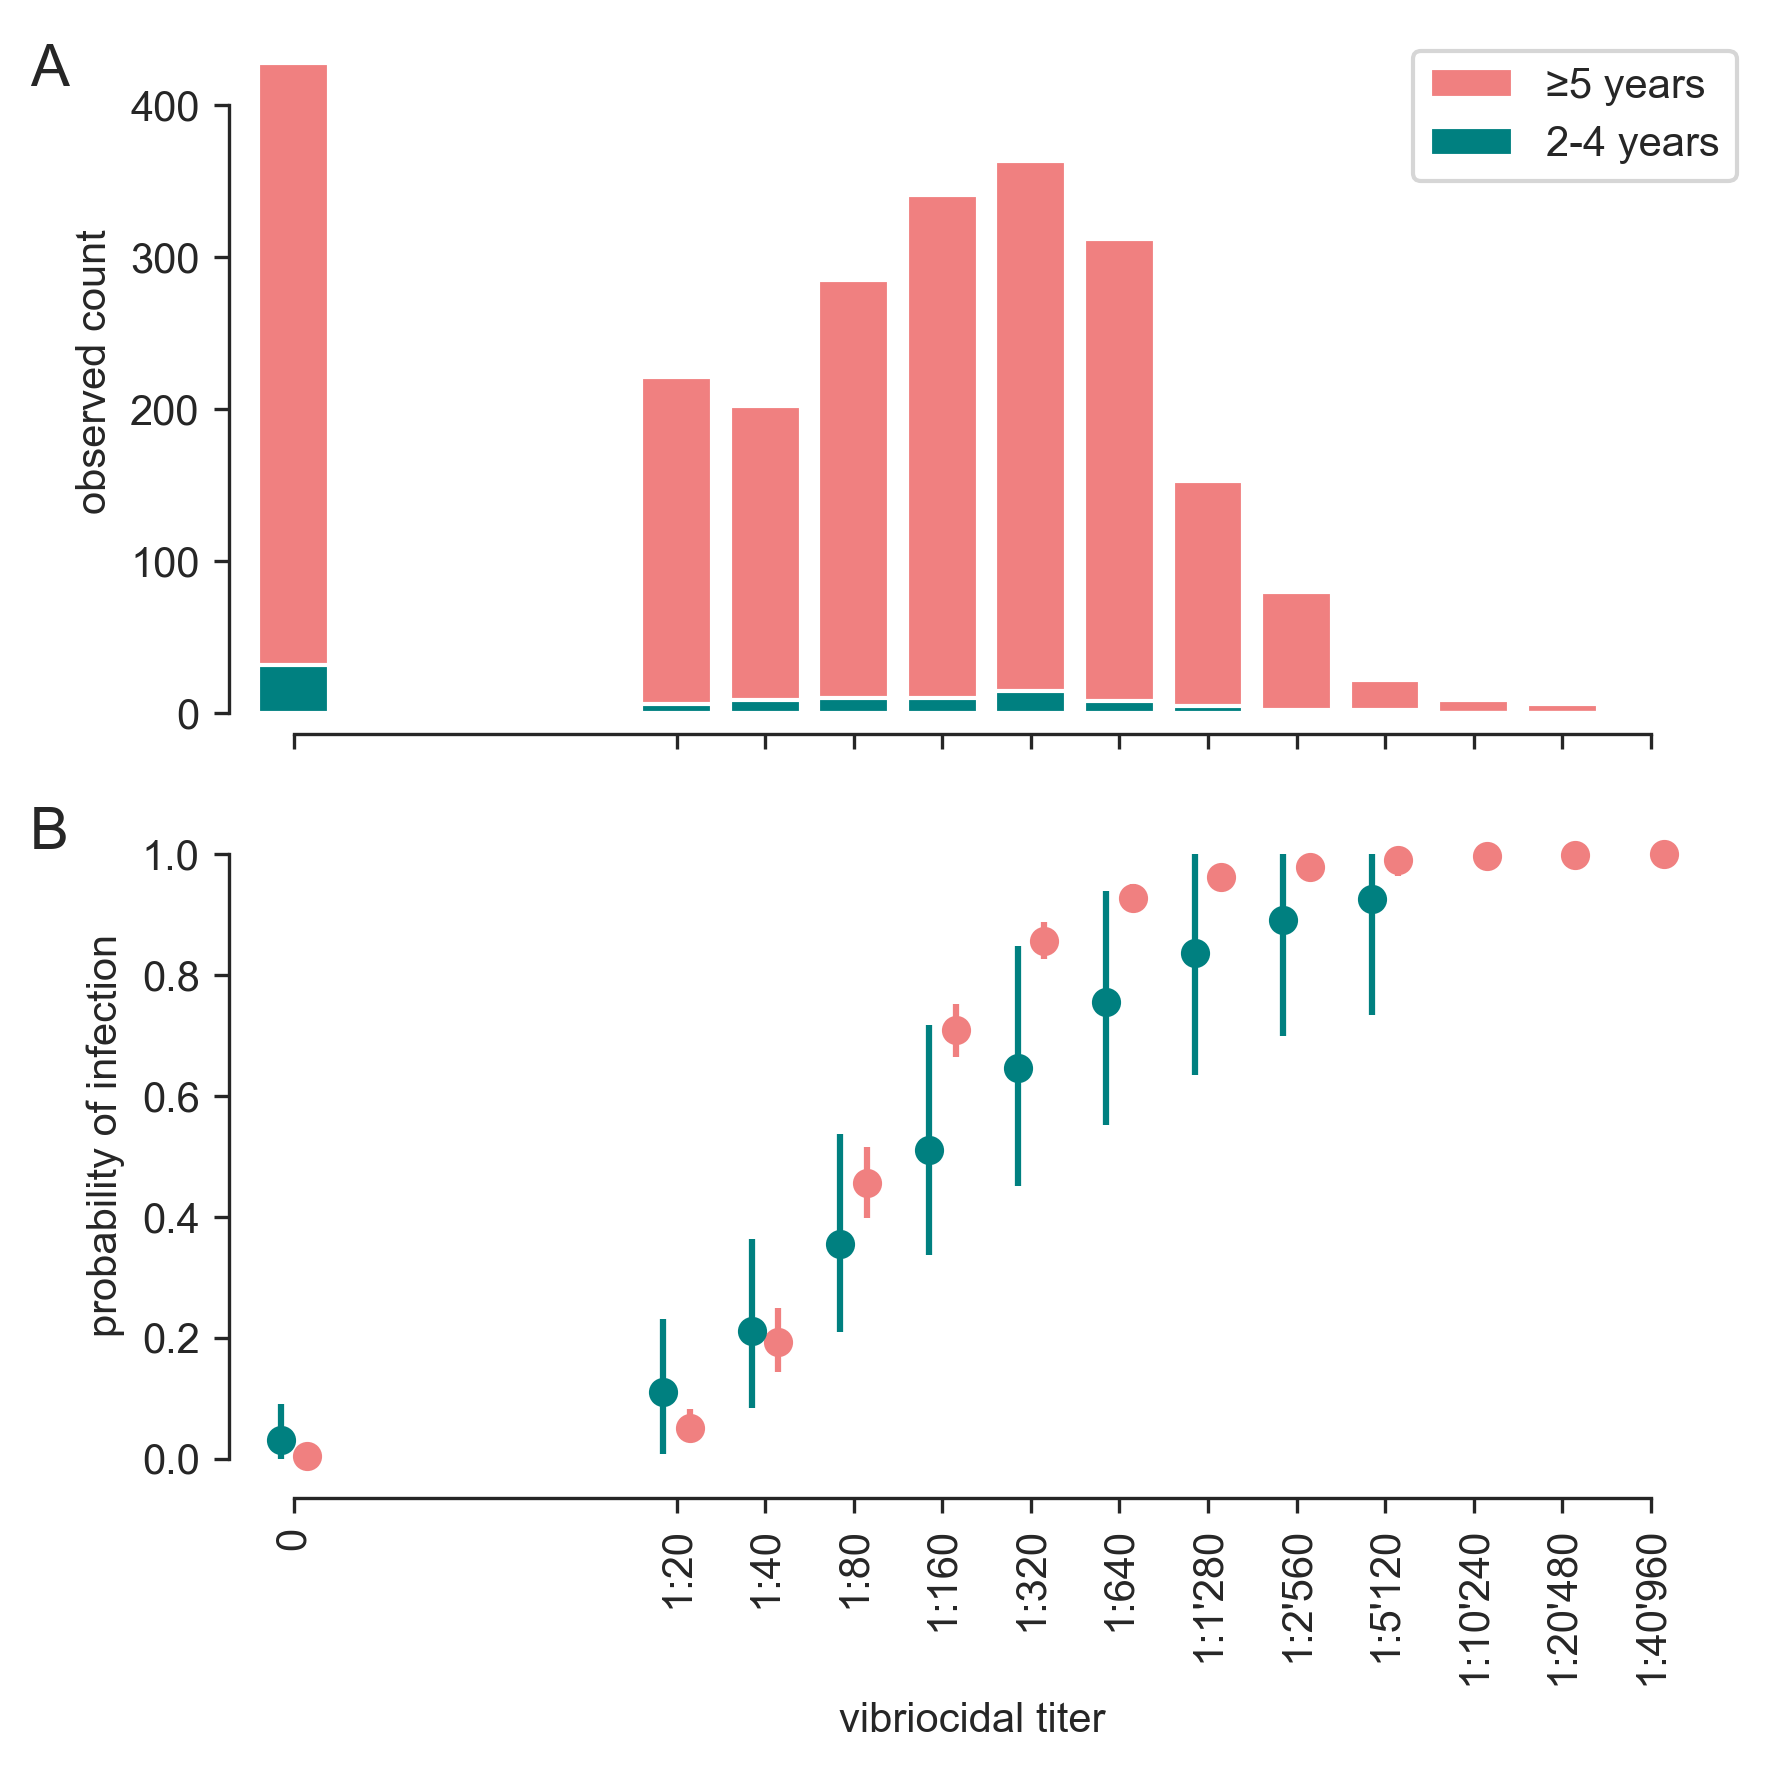

In [220]:
fig, axes = plt.subplots(2, 1, figsize = (6, 6), sharex = True, sharey = False, dpi=300)

to_plot_on_this_graph = ["adult", "U5"]

ax = axes[0]
for age_to_plot in to_plot_on_this_graph:
      cases_gt, serosurvey_gt, n_population,\
        cases_arr, n_sampled, cases_total,\
        n_days, observed_count = get_gt_data(age_to_plot)
      ax.bar(bin_lower_lim, observed_count, color = colors_age[age_to_plot], 
      alpha = 1, label = legend_age[age_to_plot])
ax.set_ylabel("observed count")
ax.legend()

ax = axes[1]
for age_to_plot in to_plot_on_this_graph:
      x = bin_lower_lim


      y = prob_infect[age_to_plot].mean(axis=0)
      yerr = [prob_infect[age_to_plot].mean(axis=0) - np.quantile(prob_infect[age_to_plot], q=0.05,axis=0), 
                           np.quantile(prob_infect[age_to_plot], q=0.95,axis=0) - prob_infect[age_to_plot].mean(axis=0)]

      if age_to_plot == "U5":
          x = bin_lower_lim-0.15 # jitter the x axis to the side to make it easier to see
          y[-3:] = np.nan # remove the last 3 bins (no measurement)
          yerr[0][-3:] = np.nan # remove the last 3 bins (no measurement)
          yerr[1][-3:] = np.nan # remove the last 3 bins (no measurement)
      elif age_to_plot == "adult":
          x = bin_lower_lim+0.15
      yerr[0][yerr[0]<0] = 0
      yerr[1][yerr[1]<0] = 0
          

      ax.errorbar(x = x, 
                  y = y, 
                  yerr =  yerr, 
                  fmt = ".", markersize = 12, color=colors_age[age_to_plot], label = age_to_plot)
ax.set_ylim(-0.03, 1.1)
ax.set_ylabel("probability of infection")
ax.set_xticks(bin_lower_lim)
ax.set_xticklabels(bins_pretty,  rotation=90) # fontdict={'fontsize': 'small'},
ax.xaxis.set_tick_params( rotation=90)
ax.set_xlabel("vibriocidal titer")


for i, letter in enumerate("AB"):
      axes[i].text(-.1, 0.98, letter, transform=axes[i].transAxes,
      fontsize = 14, va='top')
sns.despine(offset = {"left" : -10, "bottom" : 5}, trim = True)

plt.tight_layout()
plt.savefig(f"{model_folder}/mainfig1_{model_id}.png", dpi=300, bbox_inches='tight')
plt.savefig(f"fig1.png", dpi=300, bbox_inches='tight')
plt.savefig(f"fig1.pdf", dpi=300, bbox_inches='tight')

In [221]:
for age_to_plot in ["all"]:
    for i in range(13):
      print(f"{age_to_plot} : {bins_pretty[i]} : {prob_infect[age_to_plot].mean(axis=0)[i]*100:.1f}% (95%CrI {np.quantile(prob_infect[age_to_plot], q=0.05,axis=0)[i]*100:.1f}-{np.quantile(prob_infect[age_to_plot], q=0.95,axis=0)[i]*100:.1f})")
      y = prob_infect[age_to_plot].mean(axis=0)
      yerr = [prob_infect[age_to_plot].mean(axis=0) - np.quantile(prob_infect[age_to_plot], q=0.05,axis=0), 
                           np.quantile(prob_infect[age_to_plot], q=0.95,axis=0) - prob_infect[age_to_plot].mean(axis=0)]

all : 0 : 0.5% (95%CrI 0.0-1.1)
all : 1:20 : 4.8% (95%CrI 2.4-7.7)
all : 1:40 : 18.5% (95%CrI 13.2-24.1)
all : 1:80 : 44.6% (95%CrI 38.3-50.7)
all : 1:160 : 70.4% (95%CrI 65.7-74.8)
all : 1:320 : 85.8% (95%CrI 82.6-88.9)
all : 1:640 : 93.0% (95%CrI 90.6-95.3)
all : 1:1'280 : 96.5% (95%CrI 94.4-98.4)
all : 1:2'560 : 98.1% (95%CrI 95.9-100.0)
all : 1:5'120 : 99.1% (95%CrI 96.6-100.0)
all : 1:10'240 : 99.6% (95%CrI 97.0-100.0)
all : 1:20'480 : 99.9% (95%CrI 100.0-100.0)
all : 1:40'960 : 100.0% (95%CrI 100.0-100.0)


/Users/chadi/anaconda3/envs/haiti-sero_pymc4/lib/python3.11/site-packages/numpy/lib/function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


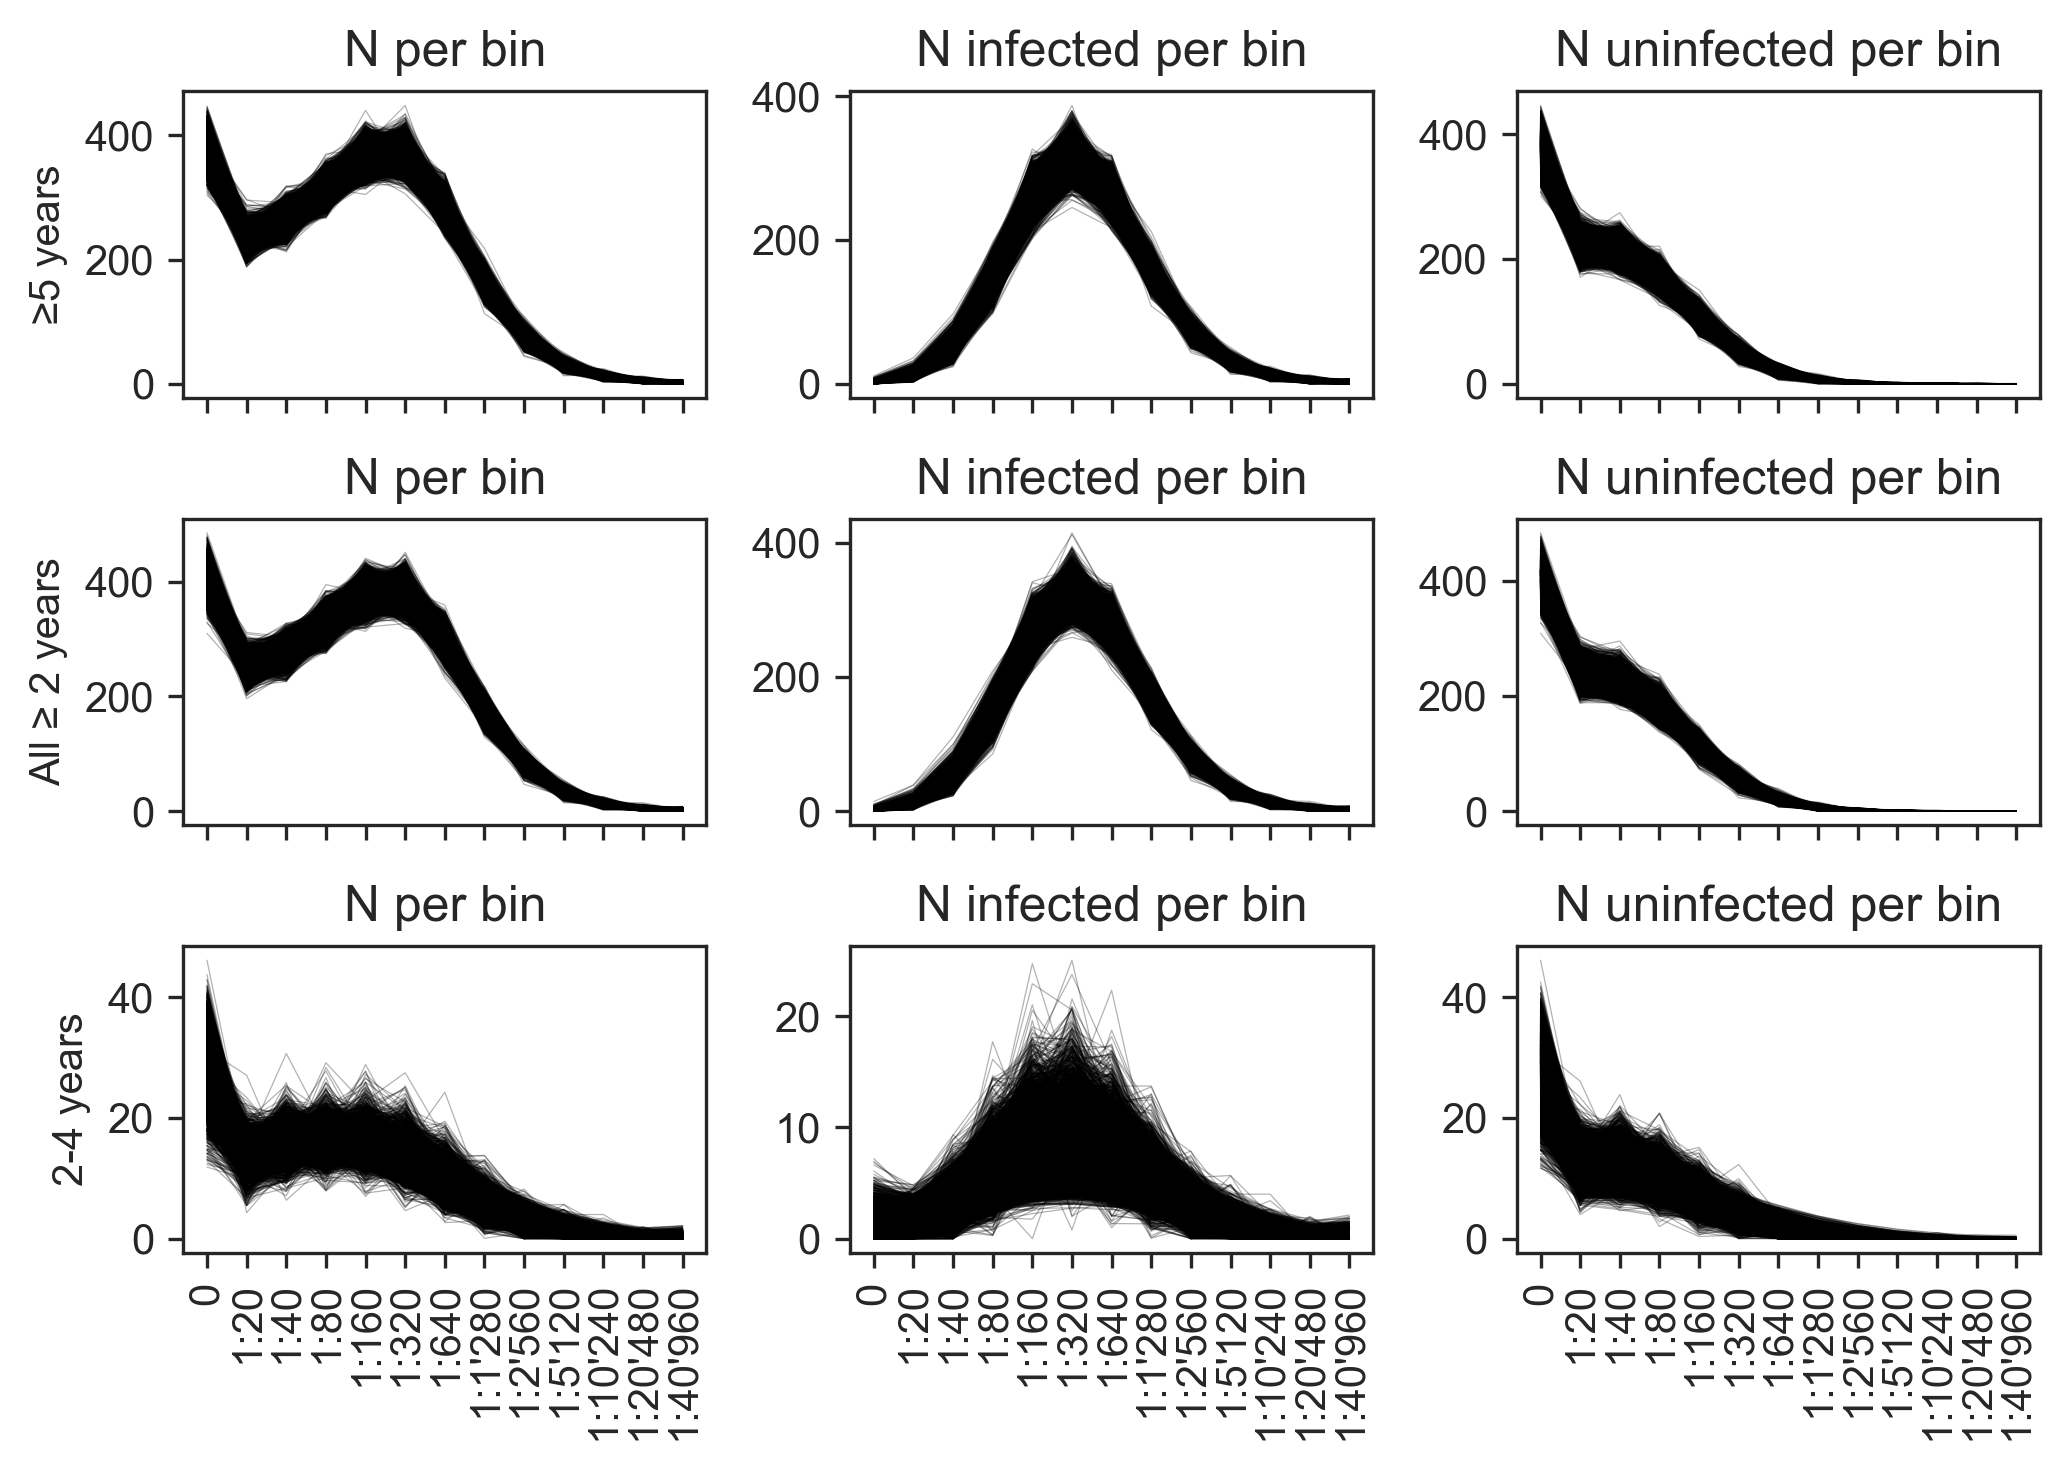

In [222]:
fig, axes = plt.subplots(len(predictive_checks.keys()), 3, figsize = (7,5), dpi=300, sharex=True)
for k, age_to_plot in enumerate(predictive_checks.keys()):
    ax=axes[k,0]
    ax.plot(bins_pretty, 
            np.sum(titer_bins_per_event[age_to_plot], axis=2).T, lw=.3, alpha=.3, c='k')
    ax.set_title("N per bin")
    ax.tick_params(axis='x', labelrotation = 90)
    ax.set_ylabel(legend_age[age_to_plot])

    ax=axes[k,1]
    ax.plot(bins_pretty, np.sum(titer_bins_per_event_masked4inf[age_to_plot], axis=1).T, lw=.3, alpha=.3, c='k')
    ax.set_title("N infected per bin")
    ax.tick_params(axis='x', labelrotation = 90)

    ax=axes[k,2]
    ax.plot(bins_pretty, np.sum(titer_bins_per_event[age_to_plot], axis=2).T-np.sum(titer_bins_per_event_masked4inf[age_to_plot], axis=1).T, lw=.3, alpha=.3, c='k')
    ax.set_title("N uninfected per bin")
    ax.tick_params(axis='x', labelrotation = 90)
fig.tight_layout()
plt.savefig(f"{model_folder}/bins-event_{to_plot}_{model_id}.png", dpi=300, bbox_inches='tight')

In [223]:
#example_titer_bin = titer_bins_per_event[0] 
#example_titer_bin.sum(axis=0)  # first (non-draw) axis sums to 1: accross all bin
#example_titer_bin.sum(axis=1)  # second (non-draw) axis sums to the number of individual in each bin

### Reconstruction of the epicurve

In [224]:
from statsmodels.stats.weightstats import DescrStatsW
day_inf_reported4inf = {}
date_inf_q0_05 = {}
date_inf_q0_50 = {}
date_inf_q0_95 = {}

for age_to_plot in predictive_checks.keys():
# weighted quantiles:
    day_inf_reported4inf[age_to_plot] = np.ma.masked_array(day_inf_reported[age_to_plot],  masked_infected[age_to_plot])
    # if day_inf_reported * if_inf_reported --> different results. Assuming masked is correct
    # because that's how it should work: non infected individuals should not contribute to
    # the day of infection

    quantiles_date_inf =  np.zeros((len(bins_pretty),3))
    for i in tqdm.tqdm(range(len(bins_pretty))):
        wq = DescrStatsW(data=day_inf_reported4inf[age_to_plot].flatten(), 
                        weights=titer_bins_per_event[age_to_plot][:,i,:].flatten())
        quantiles_date_inf[i,:] = wq.quantile(probs=np.array([0.05, 0.5, 0.95]), return_pandas=False)

    date_inf_q0_05[age_to_plot] = pd.to_datetime(quantiles_date_inf[:,0], unit='D', origin=pd.Timestamp(ti))
    date_inf_q0_50[age_to_plot] = pd.to_datetime(quantiles_date_inf[:,1], unit='D', origin=pd.Timestamp(ti))
    date_inf_q0_95[age_to_plot] = pd.to_datetime(quantiles_date_inf[:,2], unit='D', origin=pd.Timestamp(ti))

  0%|          | 0/13 [00:00<?, ?it/s]/Users/chadi/anaconda3/envs/haiti-sero_pymc4/lib/python3.11/site-packages/statsmodels/stats/weightstats.py:308: FutureWarning: The provided callable <function sum at 0x1208c6840> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  dfg = df.groupby("vec").agg(np.sum)
  8%|▊         | 1/13 [00:00<00:09,  1.23it/s]/Users/chadi/anaconda3/envs/haiti-sero_pymc4/lib/python3.11/site-packages/statsmodels/stats/weightstats.py:308: FutureWarning: The provided callable <function sum at 0x1208c6840> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  dfg = df.groupby("vec").agg(np.sum)
 15%|█▌        | 2/13 [00:01<00:06,  1.79it/s]/Users/chadi/anaconda3/envs/haiti-sero_pymc4/lib/python3.11/site-packages/statsmodels/stat

In [225]:
n_samples = day_inf_reported4inf[age_to_plot].shape[0]

reconstructed_epicurve = {}
for age_to_plot in predictive_checks.keys():
    reconstructed_epicurve[age_to_plot] = pd.DataFrame(index = pd.date_range(start=ti, end=tf, freq='D'), columns = np.arange(n_samples))
    for i in tqdm.tqdm(range(n_samples)):
        vc = pd.to_datetime(day_inf_reported4inf[age_to_plot][i,:], unit='D', origin=pd.Timestamp(ti)).value_counts().sort_index() 
        # masked values becomes  '1970-something'... why ?
        vc = vc.loc[vc.index>'2000-01-01']
        vc = vc.reindex(pd.date_range(start=ti, end=tf, freq='D'), fill_value=0)
        reconstructed_epicurve[age_to_plot][i] =  vc

100%|██████████| 8000/8000 [00:05<00:00, 1473.54it/s]


In [226]:
cases_both, serosurvey_both, n_population_both, _, n_sampled_both, _, _, _ = get_gt_data("all")
def add_rectangle(ax):
    from matplotlib import patches
    # Create rectangle x coordinates
    startTime = serosurvey_df['date'].min()
    endTime = serosurvey_df['date'].max()
    # convert to matplotlib date representation
    start = mdates.date2num(startTime)
    end = mdates.date2num(endTime)
    width = end - start
    ymin, ymax = ax.get_ylim()

    rectangle =  patches.Rectangle((start, ymin), width, ymax, color='grey', alpha=.2, lw=0)
    ax.add_patch(rectangle)
    rx, ry = rectangle.get_xy()
    cx = rx + rectangle.get_width()/2.0
    cy = ry + rectangle.get_height()/2.0
    ax.annotate("serosurvey", (cx, cy), color='black', fontsize=10, ha='center', va='center', rotation=90)

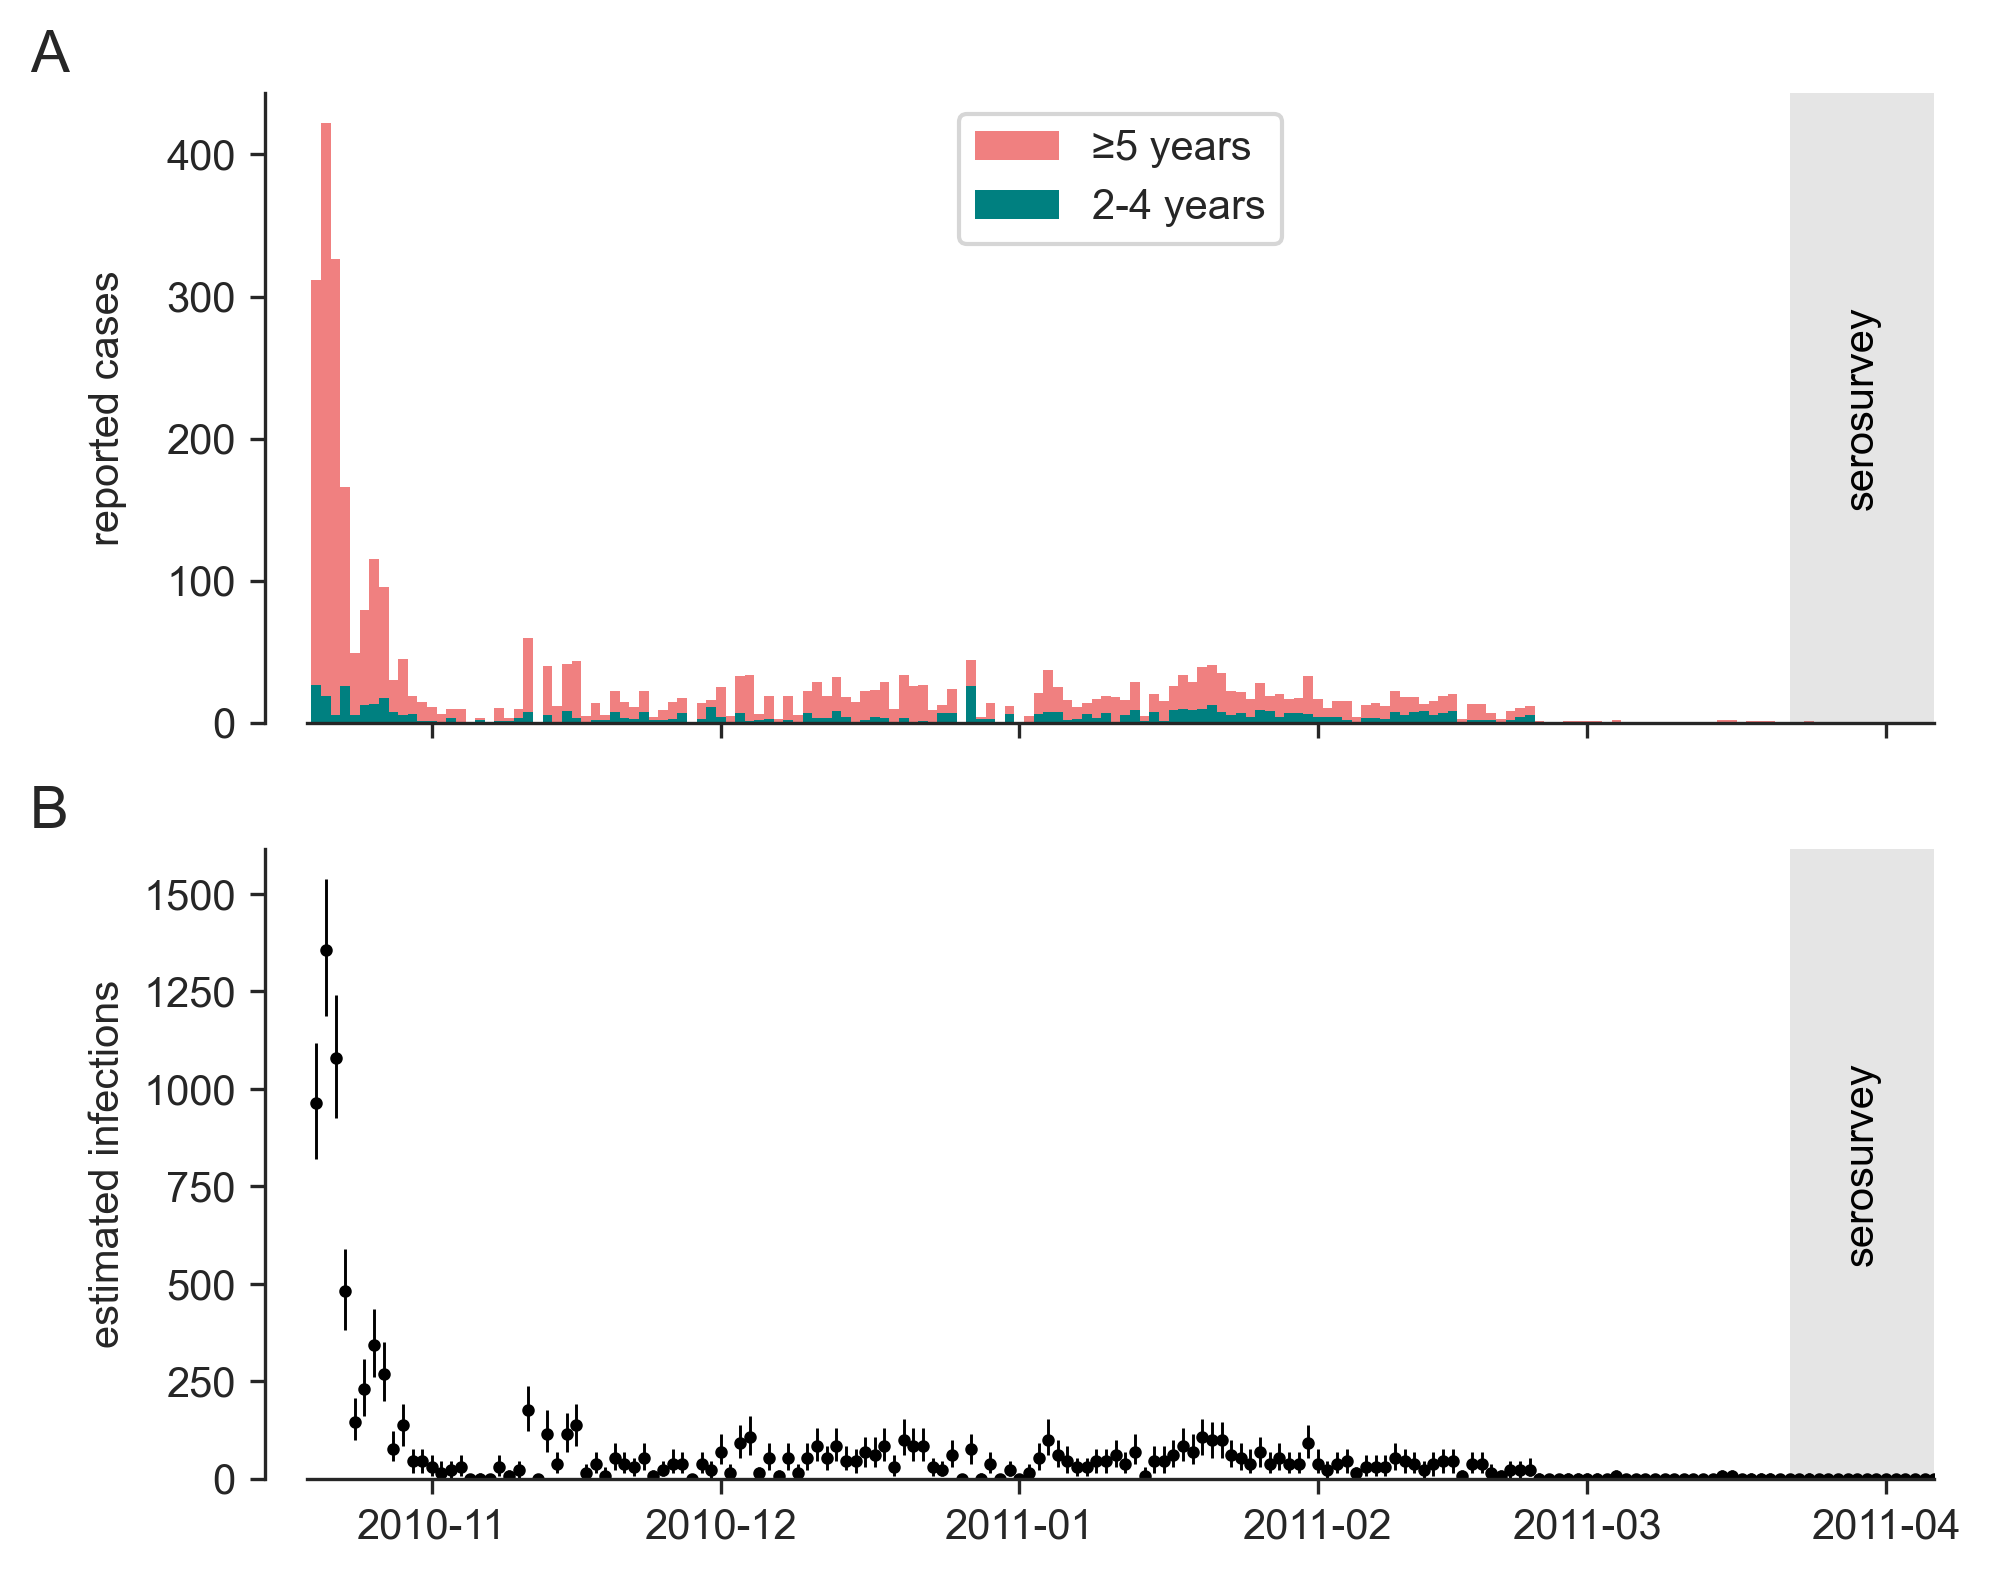

In [227]:
fig, axes = plt.subplots(2, 1, figsize = (7,6), dpi=300, sharex=True)
ax = axes.flat[0]

for age_to_plot in to_plot_on_this_graph:
    cases_gt, serosurvey_gt, n_population,\
        cases_arr, n_sampled, cases_total,\
        n_days, observed_count = get_gt_data(age_to_plot)
    if age_to_plot == "adult":
        bottom, _, _, _, _, _, _, _ = get_gt_data("U5")
    else:
        bottom = 0

    ax.bar(cases_gt.index, cases_gt.values, 
			color=colors_age[age_to_plot], 
			alpha=1, width=pd.Timedelta(days=1), bottom=bottom, label=legend_age[age_to_plot],
			lw=0)
ax.set_ylim(0)
ax.set_ylabel("reported cases")
ax.legend(loc='upper center',frameon=True)
add_rectangle(ax)


ax=axes.flat[1]
both_epicurve = (reconstructed_epicurve["U5"]+reconstructed_epicurve["adult"])*n_population_both/n_sampled_both
ax.errorbar(
        x = pd.date_range(start=ti, end=tf, freq='D'),
        y = both_epicurve.quantile(q=0.5, axis=1), 
        yerr = [both_epicurve.quantile(q=0.5, axis=1)-both_epicurve.quantile(q=0.05, axis=1),
                both_epicurve.quantile(q=0.95, axis=1)-both_epicurve.quantile(q=0.5, axis=1)],
        fmt = ".", markersize = 4, color="k", lw=.7)
ax.set_ylim(0)
ax.set_ylabel("estimated infections")
#ax.set_title(f"({to_plot}, {age_to_plot}, {model_id})  \n Cases reported and estimated (scaled by reporting")
add_rectangle(ax)

# ax = axes.flat[2]
# rep_frac = 1/(both_epicurve.T/cases_both).T # why is python so ugly
# 
# ax.fill_between(cases_gt.index, 
#                 rep_frac.quantile(q=0.975, axis=1),
#                 rep_frac.quantile(q=0.025, axis=1), 
#                 alpha=.6, color='lightskyblue', lw=0)
# ax.fill_between(cases_gt.index,
#                 rep_frac.quantile(q=0.25, axis=1), 
#                 rep_frac.quantile(q=0.75, axis=1),
#                 alpha=1, color='steelblue', lw=0)
# ax.plot(cases_gt.index, rep_frac.quantile(q=0.5, axis=1), color='k', alpha=1, lw=1)
#ax.plot(cases_gt.index, median.cumsum(), color='darkred', alpha=1)
#ax.set_ylim(0,1.5)
#ax.set_ylabel("estimated reporting ratio")


sns.despine(offset = {"left" : 10, "bottom" : 0}, trim = False)
#add_rectangle(ax)
ax.set_xlim(cases_gt.index[0]-datetime.timedelta(days=1), cases_gt.index[-1])
for i, letter in enumerate("AB"): # C
      axes[i].text(-.17, 1.1, letter, transform=axes[i].transAxes,
      fontsize = 14, va='top')
fig.align_ylabels(axes)
plt.savefig(f"fig3.png", dpi=300, bbox_inches='tight')
plt.savefig(f"fig3.pdf", dpi=300, bbox_inches='tight')

In [228]:
for age_to_plot in to_plot_on_this_graph:
    cases_gt, serosurvey_gt, n_population,\
        cases_arr, n_sampled, cases_total,\
        n_days, observed_count = get_gt_data(age_to_plot)
    # important to do quantiles of sum here, and not sum of quantiles
    n_inf_q0_05 = int(reconstructed_epicurve[age_to_plot].sum(axis=0).quantile(q=0.05)*n_population/n_sampled)
    n_inf_q0_5 = int(reconstructed_epicurve[age_to_plot].sum(axis=0).quantile(q=0.5)*n_population/n_sampled)
    n_inf_q0_95 = int(reconstructed_epicurve[age_to_plot].sum(axis=0).quantile(q=0.95)*n_population/n_sampled)

    print(f"{age_to_plot}, obs: {int(cases_gt.sum())}, sim : {n_inf_q0_5} ({n_inf_q0_05} - {n_inf_q0_95})")
    # multiplier for every x infection
    print(f"{age_to_plot} Ratio {n_inf_q0_5/int(cases_gt.sum()):.1f} (95% CrI {n_inf_q0_05/int(cases_gt.sum()):.1f}-{n_inf_q0_95/int(cases_gt.sum()):.1f})")

adult, obs: 3032, sim : 9808 (9215 - 10437)
adult Ratio 3.2 (95% CrI 3.0-3.4)
U5, obs: 627, sim : 563 (397 - 819)
U5 Ratio 0.9 (95% CrI 0.6-1.3)


In [229]:
# A recent meta-analysis suggested that, on average, 49% (95% CrI 43-54%) of suspected cholera cases are true cholera cases. 
# If this applies to Haiti during this time, we would then expect to have X infections per each confirmed clinical cholera 
# case reported across the full population and X infections per confirmed clinical case among 2-4 year olds.

# we have suscepted case/confirmed case
# we want infection / confirmed cases = infection/suspected case * suscepted case/confirmed case
# I produced infection/habitant and infection/suspected case (1/rho). 

# we have 3 infection per suspected case
# there are 0.5 confirmed case per suspected case
# we want 1.5 infection per confirmed cas
# 
for age_to_plot in ["all", "adult", "U5"]:
    rho_c = trace[age_to_plot]["rho"].values.ravel()
    a = np.array([1/np.mean(rho_c), np.percentile(1/rho_c, 2.5), np.percentile(1/rho_c, 97.5)])
    a= a/np.array([.49,.54,.43])
    #a= a*100
    print(f"{age_to_plot} {a[0]:.1f} (95% CrI {a[1]:.1f}-{a[2]:.1f})")

all 5.9 (95% CrI 5.0-7.2)
adult 6.6 (95% CrI 5.6-8.0)
U5 1.8 (95% CrI 1.3-3.1)


## Figure 4: Comparison with other methods

In [230]:
input_string = """type, 2-4 years, ≥5 years , All ≥2 years & clinical surveillance, 39.5% [37 - 41.9], 16.4% [15.9 - 16.9], 18.2% [17.7 - 18.8] & self reported cholera, 18.5% [12.1 - 26.5], 17.8% [16.3 - 19.3], 17.8% [16.3 - 19.3] & self reported watery diarrhea, 25% [17.7 - 33.6], 20.4% [18.9 - 22.1], 20.6% [19.1 - 22.2] & vibriocidal threshold\n(Bangladesh controls), 21% [4.1 - 36.2], 31.7% [15.1 - 46.9], 31.2% [14.7 - 46.4] & vibriocidal threshold\n(North American controls), 33.9% [NA - NA], 42.3% [NA - NA], 42% [NA - NA] & vibriocidal gaussian mixture, 65.2% [11.8 - 95], 31.8% [24.1 - 41.3], 32% [24.5 - 41.3] & vibriocidal decay model, 35.5% [24.2 - 51.6], 53.1% [49.4 - 56.4], 52.6% [49.4 - 55.7]"""

data = input_string
df = pd.DataFrame([x.split(',') for x in data.split('&')])
df = df.applymap(lambda x: x.strip())
df.columns = df.iloc[0]
df = df.drop(0)
df = df.iloc[::-1] # reverse order


df

/var/folders/pj/15hxgl0j1wg2w_t5k7bvnq5c0000gn/T/ipykernel_56359/3296142286.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip())


0                                              type            2-4 years  \
7                           vibriocidal decay model  35.5% [24.2 - 51.6]   
6                      vibriocidal gaussian mixture    65.2% [11.8 - 95]   
5  vibriocidal threshold\n(North American controls)      33.9% [NA - NA]   
4      vibriocidal threshold\n(Bangladesh controls)     21% [4.1 - 36.2]   
3                     self reported watery diarrhea    25% [17.7 - 33.6]   
2                             self reported cholera  18.5% [12.1 - 26.5]   
1                             clinical surveillance    39.5% [37 - 41.9]   

0             ≥5 years         All ≥2 years  
7  53.1% [49.4 - 56.4]  52.6% [49.4 - 55.7]  
6  31.8% [24.1 - 41.3]    32% [24.5 - 41.3]  
5      42.3% [NA - NA]        42% [NA - NA]  
4  31.7% [15.1 - 46.9]  31.2% [14.7 - 46.4]  
3  20.4% [18.9 - 22.1]  20.6% [19.1 - 22.2]  
2  17.8% [16.3 - 19.3]  17.8% [16.3 - 19.3]  
1  16.4% [15.9 - 16.9]  18.2% [17.7 - 18.8]

All ≥2 years
All ≥2 years 52.6
2-4 years
2-4 years 35.5
≥5 years
≥5 years 53.1


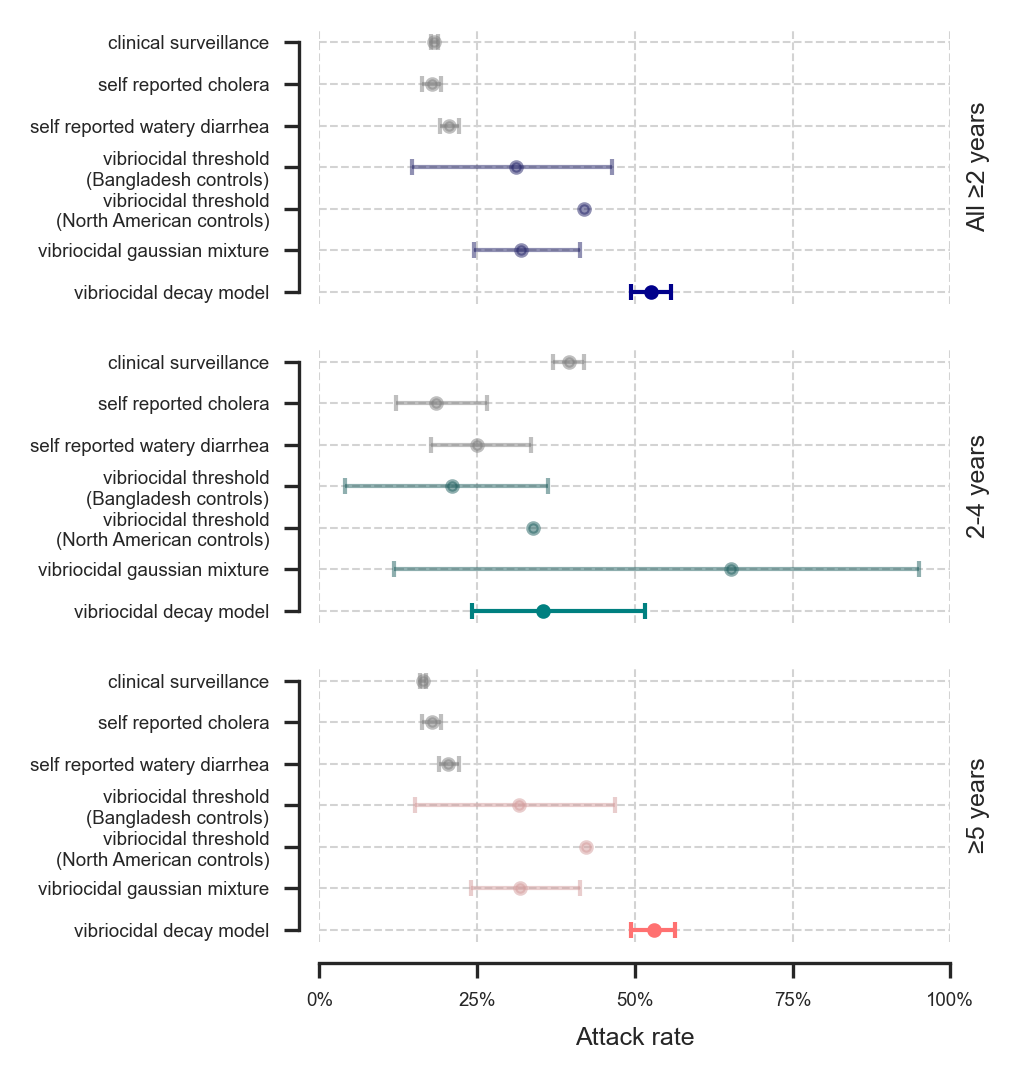

In [231]:
fig, axes = plt.subplots(3, 1, figsize = (3.5, 3.7), sharex = True, sharey = False, dpi=300)

to_plot_on_this_graph = ["All ≥2 years", "2-4 years", "≥5 years"]

fontsize = 4.5

def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])


for i, age_to_plot in enumerate(to_plot_on_this_graph):
      ax = axes.flat[i]
      print(age_to_plot)
      if age_to_plot == "All ≥2 years":
            color = "darkblue"
      elif age_to_plot == "2-4 years":
            color = "slategray"
            color = "teal"
      elif age_to_plot == "≥5 years":
            color = "lightcoral"

      parsed = df[age_to_plot].str.extract(r'\s*(\d+(?:\.\d+)?)%\s*\[([-\d\.]*\s*(?:NA)?\s*[-\d\.]*)\s*-\s*([-\d\.]*\s*(?:NA)?\s*[-\d\.]*)\]') # thanks GPT-4 !!


      y = parsed[0].str.replace('NA', 'NaN').astype(float)
      ylow = parsed[1].str.replace('NA', 'NaN').astype(float)
      yhigh = parsed[2].str.replace('NA', 'NaN').astype(float)
      yerr = np.array([y - ylow, yhigh - y])


      ax.errorbar(y = np.arange(1,4), 
                  x = y[1:4], 
                  xerr =  yerr[:,1:4], 
                  fmt = ".", markersize = 5, color=sns.desaturate(color,.5), label = age_to_plot, capsize=2, elinewidth=1, capthick=1, alpha =.5)

      ax.errorbar(y = np.arange(4,len(y)), 
                  x = y[4:], 
                  xerr =  yerr[:,4:], 
                  fmt = ".", markersize = 5, color= "gray", label = age_to_plot, capsize=2, elinewidth=1, capthick=1, alpha =.5)
      print(age_to_plot, y.iloc[0])
      ax.errorbar(y = [0], 
                  x = y.iloc[0], 
                  xerr =  np.array([yerr[:,0]]).T, 
                  fmt = ".", markersize = 5, color= sns.saturate(color), label = age_to_plot, capsize=2, elinewidth=1, capthick=1)
      ax.grid(color = "lightgray", linestyle = "--", linewidth = 0.5)
      ax.set_xlim(0, 100)
      # set a y label on the right
      ax.yaxis.set_label_position("right")

      ax.set_ylabel(f"{age_to_plot}", fontsize=6)
      ax.set_yticks(np.arange(len(y)))
      
#ax.xaxis.set_tick_params( rotation=90)
#ax.set_xlabel("vibriocidal titer")
      
      if i != 2:
            sns.despine(offset = {"left" : 5}, trim = True, ax = ax, bottom = True)
            ax.set_xticks([], [], color = "white")
            ax.tick_params(axis='x', colors='white')
            ax.set_yticklabels(df["type"], fontsize=5, fontdict={'fontsize': fontsize})
      else:
            sns.despine(offset = {"left" : 5, "bottom" : 5}, trim = True, ax = ax)
            ax.set_xticks([0, 25, 50, 75, 100])
            ax.set_xticklabels([f"{i}%" for i in [0, 25, 50, 75, 100]], fontsize=fontsize, fontdict={'fontsize': fontsize})
            ax.set_yticklabels(df["type"], fontsize=fontsize, fontdict={'fontsize': fontsize})
            ax.set_xlabel("Attack rate", fontsize=6)
            

plt.setp(axes.flat[0].get_xticklabels(), visible=False)
plt.setp(axes.flat[1].get_xticklabels(), visible=False)

plt.tight_layout()
#plt.savefig(f"{model_folder}/mainfig4_{model_id}.png", dpi=300, bbox_inches='tight')
plt.savefig(f"fig4.png", dpi=300, bbox_inches='tight')
plt.savefig(f"fig4.pdf", dpi=300, bbox_inches='tight')

### Quantiles of date of infection per bins

In [232]:
from statsmodels.stats.weightstats import DescrStatsW
day_inf_reported4inf = {}
date_inf_q0_05 = {}
date_inf_q0_50 = {}
date_inf_q0_95 = {}

for age_to_plot in predictive_checks.keys():
# weighted quantiles:
    day_inf_reported4inf[age_to_plot] = np.ma.masked_array(day_inf_reported[age_to_plot],  masked_infected[age_to_plot])
    # if day_inf_reported * if_inf_reported --> different results. Assuming masked is correct
    # because that's how it should work: non infected individuals should not contribute to
    # the day of infection

    quantiles_date_inf =  np.zeros((len(bins_pretty),3))
    for i in tqdm.tqdm(range(len(bins_pretty))):
        wq = DescrStatsW(data=day_inf_reported4inf[age_to_plot].flatten(), 
                        weights=titer_bins_per_event[age_to_plot][:,i,:].flatten())  # weigted quanties by the probabilites in each bin,.
        quantiles_date_inf[i,:] = wq.quantile(probs=np.array([0.05, 0.5, 0.95]), return_pandas=False)

    date_inf_q0_05[age_to_plot] = pd.to_datetime(quantiles_date_inf[:,0], unit='D', origin=pd.Timestamp(ti))
    date_inf_q0_50[age_to_plot] = pd.to_datetime(quantiles_date_inf[:,1], unit='D', origin=pd.Timestamp(ti))
    date_inf_q0_95[age_to_plot] = pd.to_datetime(quantiles_date_inf[:,2], unit='D', origin=pd.Timestamp(ti))

  0%|          | 0/13 [00:00<?, ?it/s]/Users/chadi/anaconda3/envs/haiti-sero_pymc4/lib/python3.11/site-packages/statsmodels/stats/weightstats.py:308: FutureWarning: The provided callable <function sum at 0x1208c6840> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  dfg = df.groupby("vec").agg(np.sum)
  8%|▊         | 1/13 [00:00<00:06,  1.73it/s]/Users/chadi/anaconda3/envs/haiti-sero_pymc4/lib/python3.11/site-packages/statsmodels/stats/weightstats.py:308: FutureWarning: The provided callable <function sum at 0x1208c6840> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  dfg = df.groupby("vec").agg(np.sum)
 15%|█▌        | 2/13 [00:00<00:04,  2.30it/s]/Users/chadi/anaconda3/envs/haiti-sero_pymc4/lib/python3.11/site-packages/statsmodels/stat

In [237]:
age_to_plot = "all"

<ErrorbarContainer object of 3 artists>

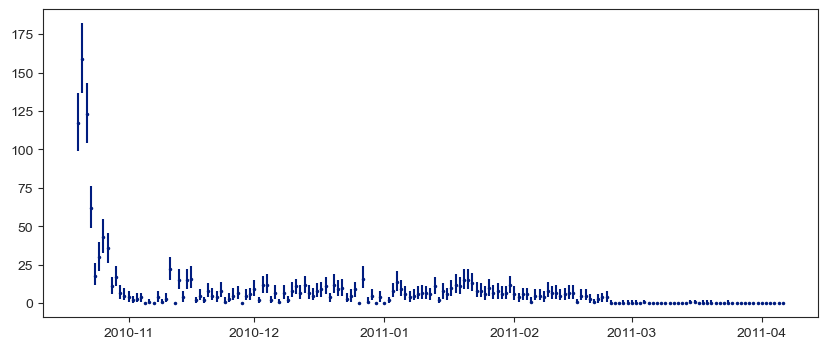

In [238]:
# plot the distribution of dates of infection
fig, ax = plt.subplots(1,1, figsize=(10,4), dpi=100)
ax.errorbar(x = pd.date_range(start=ti, end=tf, freq='D'),
                  y = reconstructed_epicurve[age_to_plot].quantile(q=0.5, axis=1), 
                  yerr = [reconstructed_epicurve[age_to_plot].quantile(q=0.5, axis=1)-reconstructed_epicurve[age_to_plot].quantile(q=0.05, axis=1),
                            reconstructed_epicurve[age_to_plot].quantile(q=0.95, axis=1)-reconstructed_epicurve[age_to_plot].quantile(q=0.5, axis=1)],
                  fmt = ".", markersize = 3)

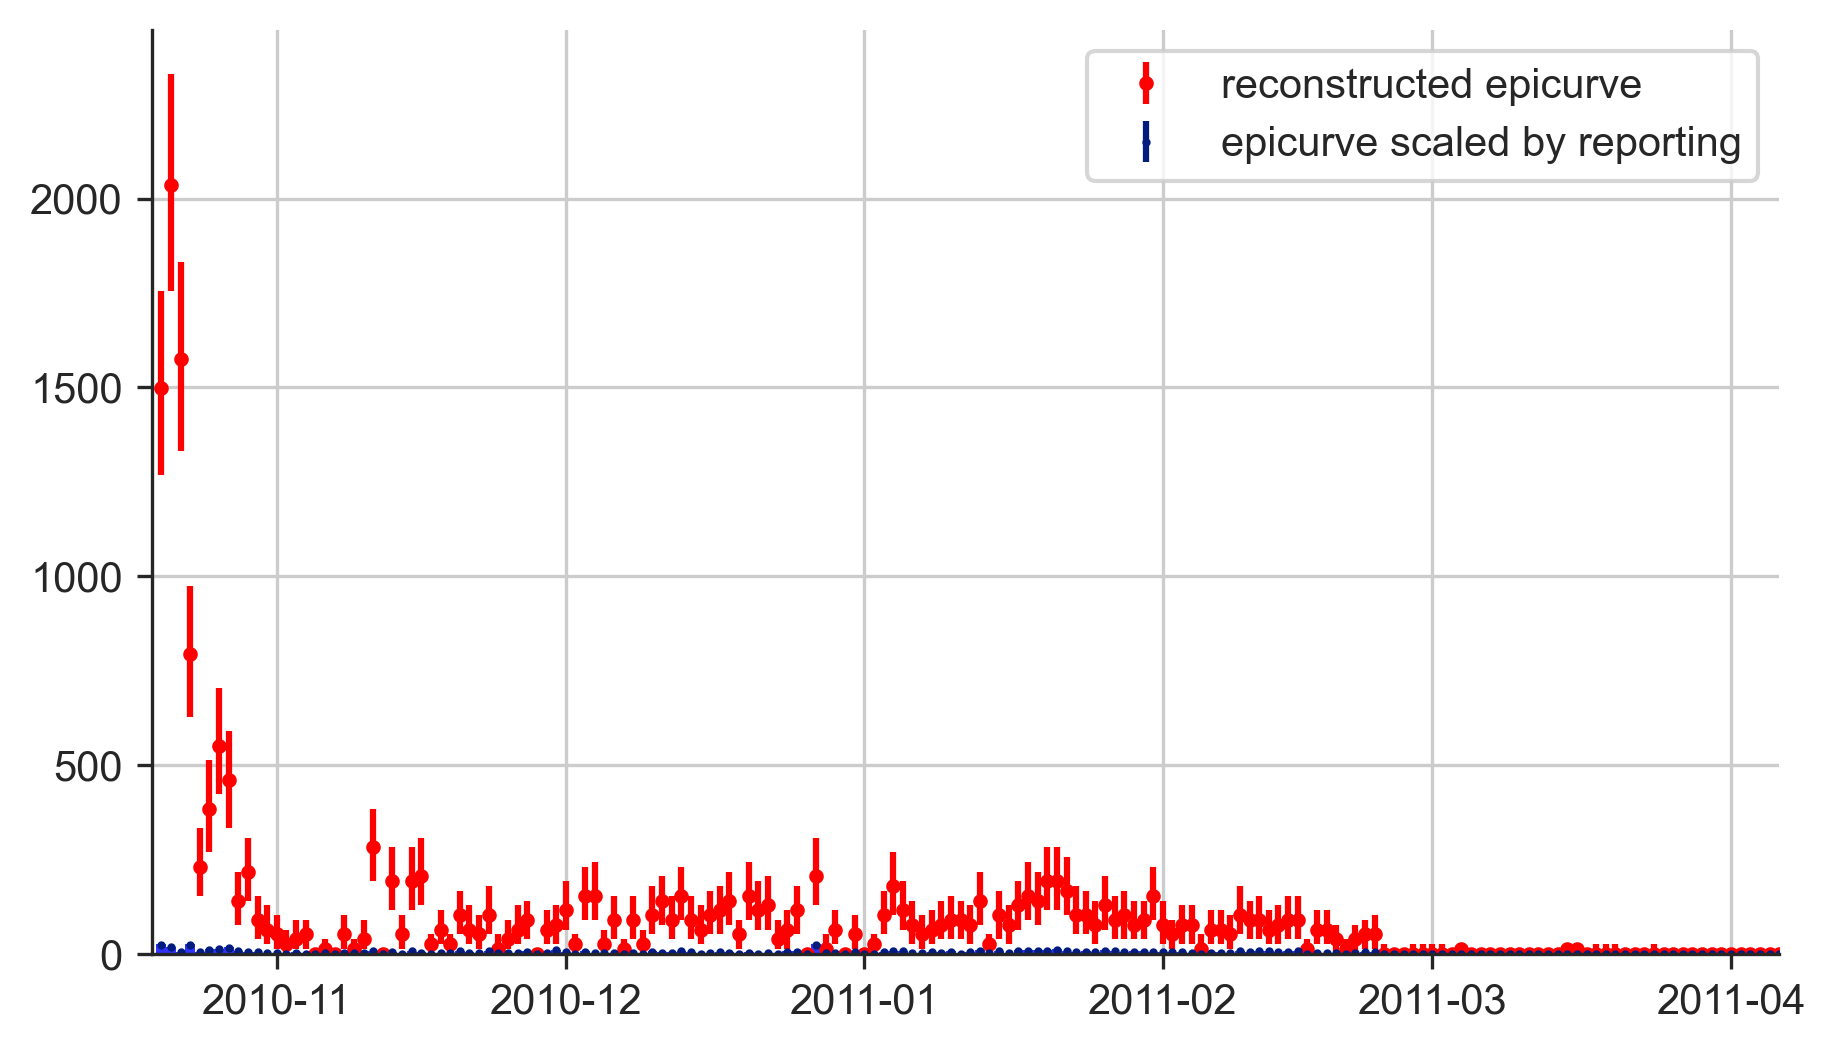

In [242]:
fig, ax = plt.subplots(1, 1, figsize = (7,4),dpi =300)
ax.bar(cases_gt.index, cases_gt.values, color='blue', alpha=0.8, width=pd.Timedelta(days=1), lw=0)

reconstructed_epicurve_scaled = reconstructed_epicurve[age_to_plot]*n_population/n_sampled
ax.errorbar(x = pd.date_range(start=ti, end=tf, freq='D'),
                  y = reconstructed_epicurve_scaled.quantile(q=0.5, axis=1), 
                  yerr = [reconstructed_epicurve_scaled.quantile(q=0.5, axis=1)-reconstructed_epicurve_scaled.quantile(q=0.05, axis=1),
                            reconstructed_epicurve_scaled.quantile(q=0.95, axis=1)-reconstructed_epicurve_scaled.quantile(q=0.5, axis=1)],
                  fmt = ".", markersize = 5, c='r', alpha=1, label='reconstructed epicurve')
ax.errorbar(cases_gt.index,
		median,
		yerr=[np.clip(median-q025,0, np.inf), np.clip(q975-median,0, np.inf)],
		fmt = ".",
		markersize = 2, label="epicurve scaled by reporting")
ax.grid()
ax.set_xlim(cases_gt.index[0]-datetime.timedelta(days=1), cases_gt.index[-1])
sns.despine()
ax.legend()
plt.savefig(f"{model_folder}/epicurve_{to_plot}_{model_id}.png", dpi=300, bbox_inches='tight')

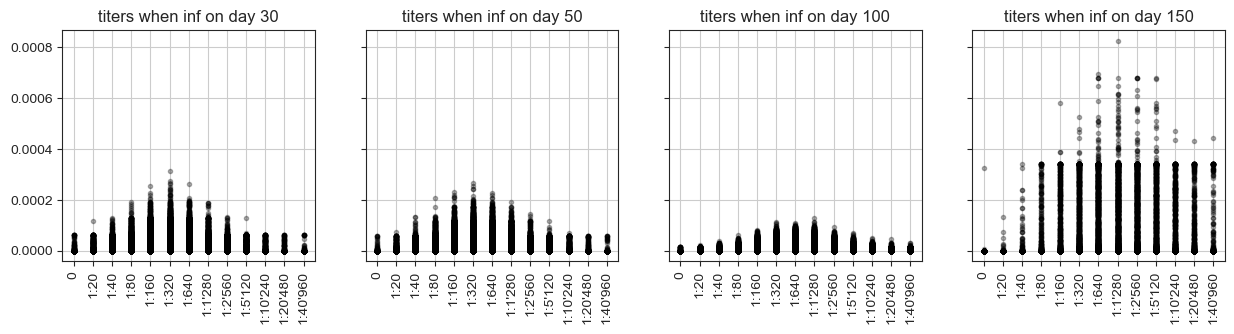

In [244]:
fig, axes = plt.subplots(1, 4, figsize = (15,3), sharex=True, sharey=True)

days = [30, 50, 100, 150]
for i, day in enumerate(days):
    # normalized so we don't see the absolute probabibity of being infected that day
    x = titer_bins_per_event_masked4inf[age_to_plot]*np.repeat((day_inf_reported4inf[age_to_plot] == day)[:,:, np.newaxis], 13, axis=2)
    axes.flat[i].plot(bins_pretty, x.sum(axis=1).T/x.sum(axis=1).T.sum(), lw=.3, alpha=.3, c='k',ls='', marker='.')
    axes.flat[i].set_title(f"titers when inf on day {day}")
    axes.flat[i].grid()
    axes.flat[i].tick_params(axis='x', labelrotation = 90)

#### quantiles of peak titer

In [246]:
peak_titer_inf = np.ma.masked_array(baseline_titer[age_to_plot]+peak_titer[age_to_plot], masked_infected[age_to_plot])
# if here we use baseline_titer+peak_titer * if_inf_reported, we get different results !! because puts a lot of zeros everywhere.
quantiles_peak_titer =  np.zeros((13,3))
for i in tqdm.tqdm(range(13)):
    wq = DescrStatsW(data=peak_titer_inf.flatten(), 
                     weights=titer_bins_per_event[age_to_plot][:,i,:].flatten())
    quantiles_peak_titer[i,:] = wq.quantile(probs=np.array([0.05, 0.5, 0.95]), return_pandas=False)

peak_titer_q0_05 = quantiles_peak_titer[:,0]
peak_titer_q0_50 = quantiles_peak_titer[:,1]
peak_titer_q0_95 = quantiles_peak_titer[:,2]

  0%|          | 0/13 [00:00<?, ?it/s]/Users/chadi/anaconda3/envs/haiti-sero_pymc4/lib/python3.11/site-packages/statsmodels/stats/weightstats.py:308: FutureWarning: The provided callable <function sum at 0x1208c6840> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  dfg = df.groupby("vec").agg(np.sum)
  8%|▊         | 1/13 [00:12<02:24, 12.03s/it]/Users/chadi/anaconda3/envs/haiti-sero_pymc4/lib/python3.11/site-packages/statsmodels/stats/weightstats.py:308: FutureWarning: The provided callable <function sum at 0x1208c6840> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  dfg = df.groupby("vec").agg(np.sum)
 15%|█▌        | 2/13 [00:24<02:13, 12.14s/it]/Users/chadi/anaconda3/envs/haiti-sero_pymc4/lib/python3.11/site-packages/statsmodels/stat

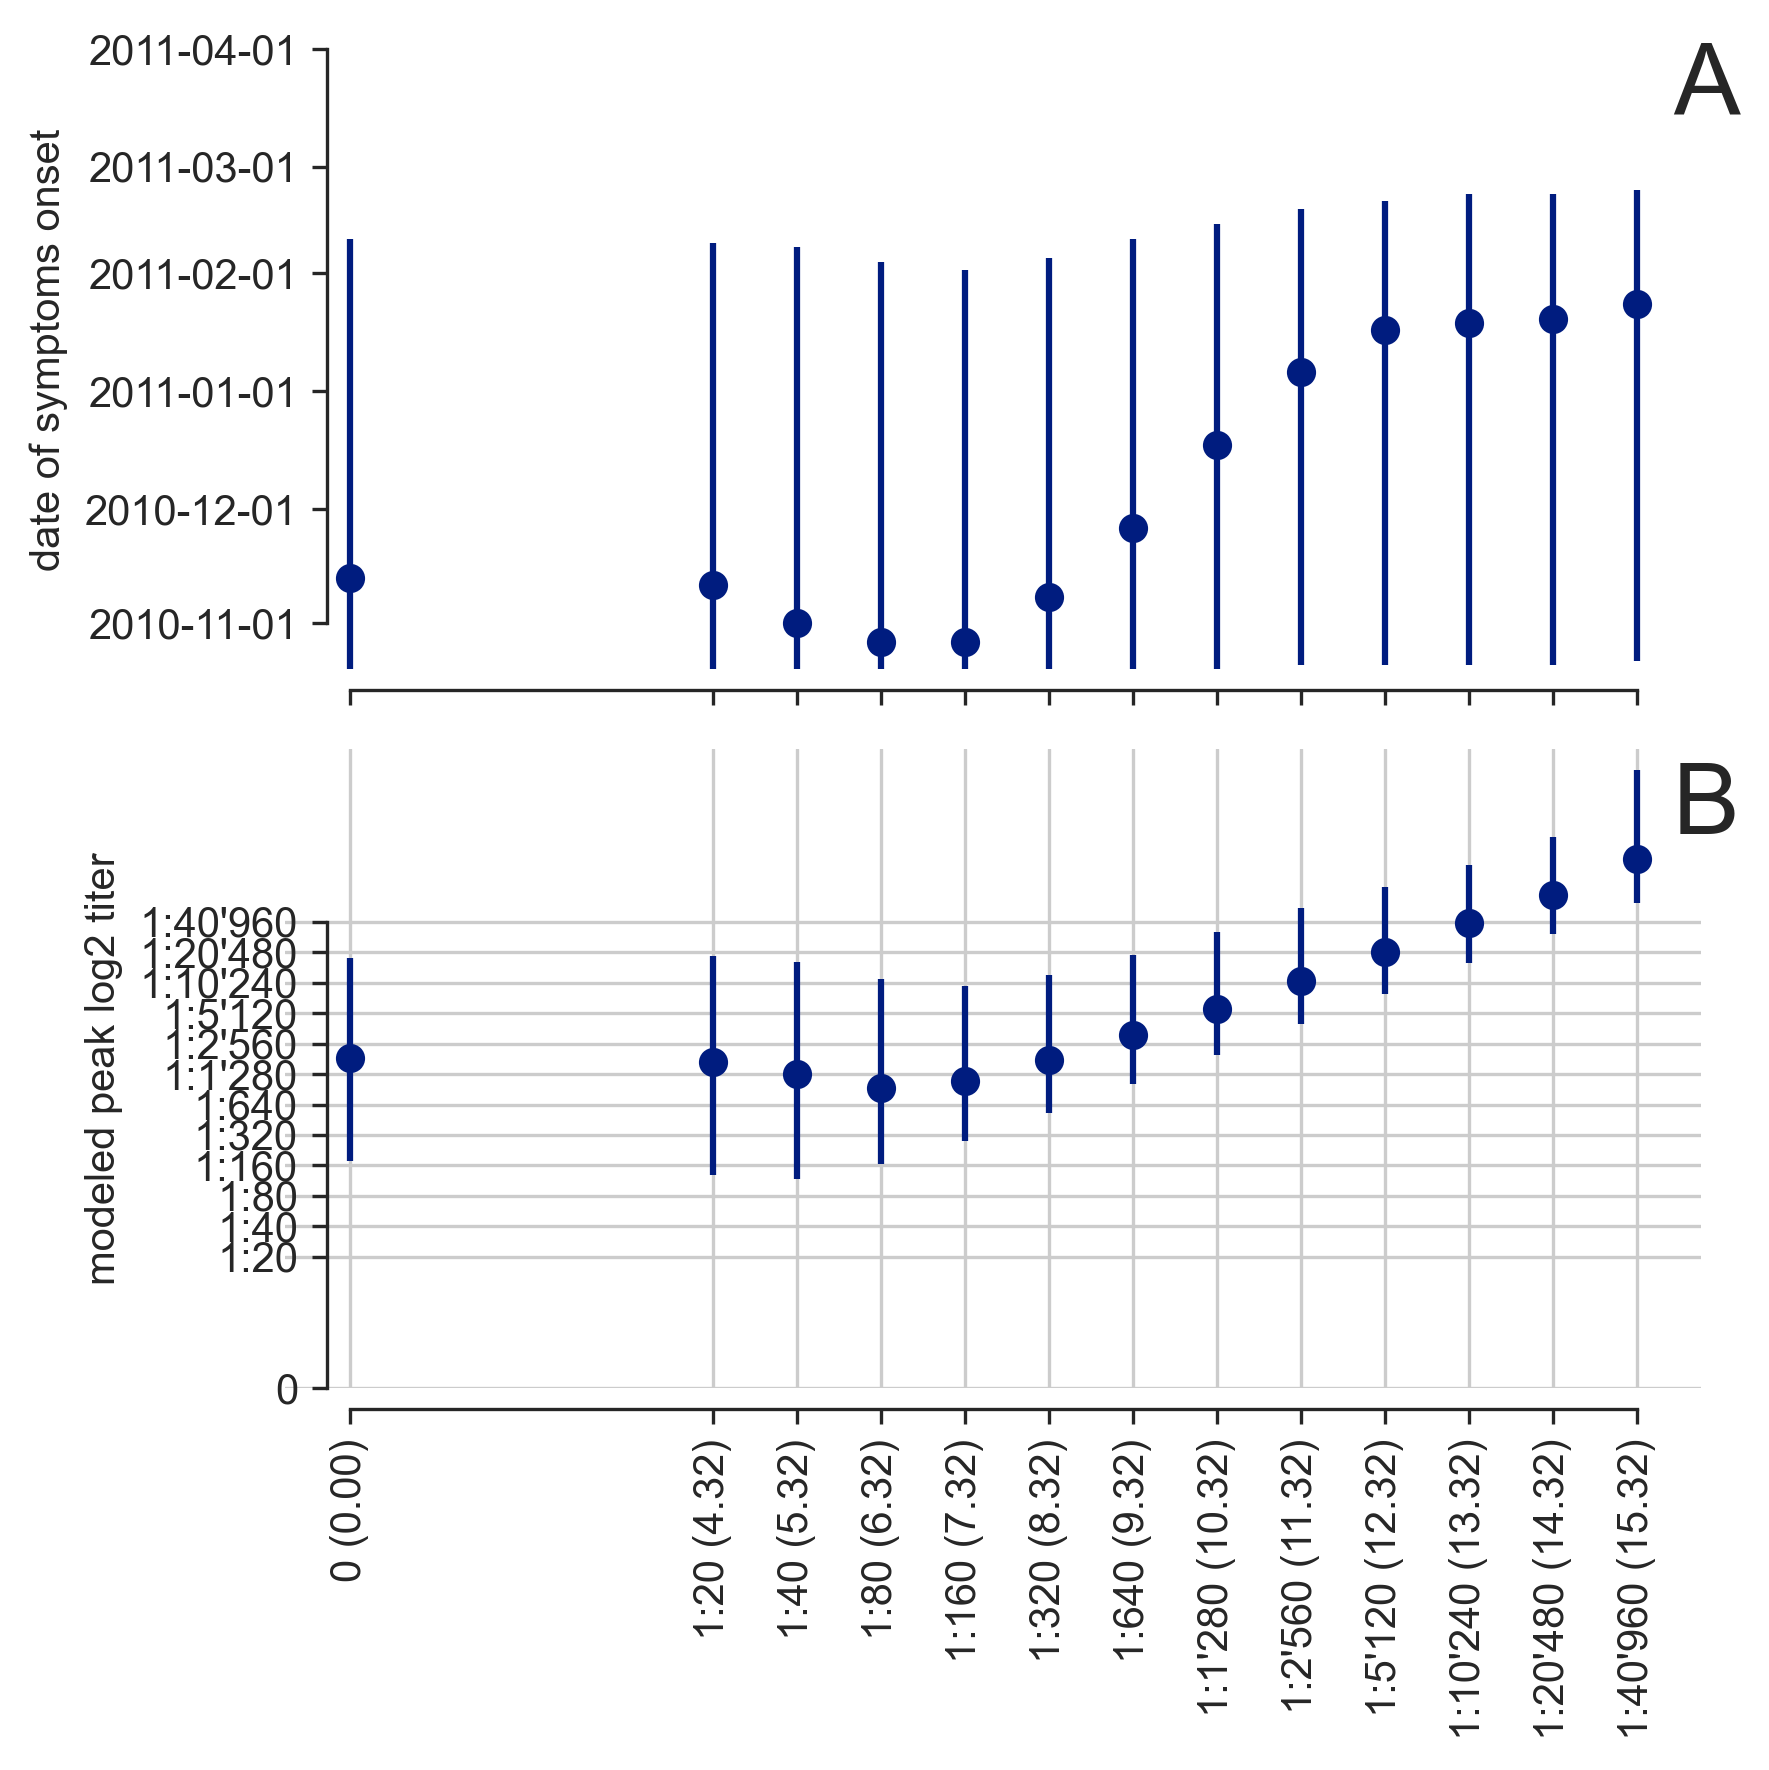

In [248]:
fig, axes = plt.subplots(2, 1, figsize = (6, 6), sharex = True, sharey = False, dpi=300)

ax = axes[0]
ax.set_xticks(bin_lower_lim)
ax.set_xticklabels(bins_pretty_wlog,  rotation=90) # fontdict={'fontsize': 'small'},
ax.xaxis.set_tick_params( rotation=90)
ax.errorbar(x = bin_lower_lim,
                  y = date_inf_q0_50[age_to_plot], 
                  yerr = [date_inf_q0_50[age_to_plot]-date_inf_q0_05[age_to_plot], date_inf_q0_95[age_to_plot]-date_inf_q0_50[age_to_plot]],
                  fmt = ".", markersize = 12)
ax.set_ylim(ti,tf)
ax.yaxis.set_tick_params()#labelsize=11)
ax.set_ylabel("date of symptoms onset")


ax = axes[1]
ax.set_xticks(bin_lower_lim)
ax.set_xticklabels(bins_pretty_wlog, rotation=90) # , fontdict={'fontsize': 'small'}
ax.xaxis.set_tick_params( rotation=90)
ax.errorbar(x = bin_lower_lim,
                  y = peak_titer_q0_50, 
                  yerr = [peak_titer_q0_50-peak_titer_q0_05, peak_titer_q0_95-peak_titer_q0_50],
                  fmt = ".", markersize = 12)
ax.set_yticks(bin_lower_lim)
ax.set_yticklabels(bins_pretty)#, fontdict={'fontsize': 4})
ax.yaxis.set_tick_params()#labelsize=11)
ax.set_ylabel("modeled peak log2 titer")
ax.grid()

for i, letter in enumerate("AB"):
      axes[i].text(0.98, 0.98, letter, transform=axes[i].transAxes,
      fontsize = 24, va='top')

sns.despine(offset = {"left" : -10, "bottom" : 5}, trim = True)

plt.tight_layout()
plt.savefig(f"{model_folder}/mainfig2_{model_id}.png", dpi=300, bbox_inches='tight')

I need to build the decay function for each posterior draws, not doing the quantiles before !to get the decay as posited by the posterior

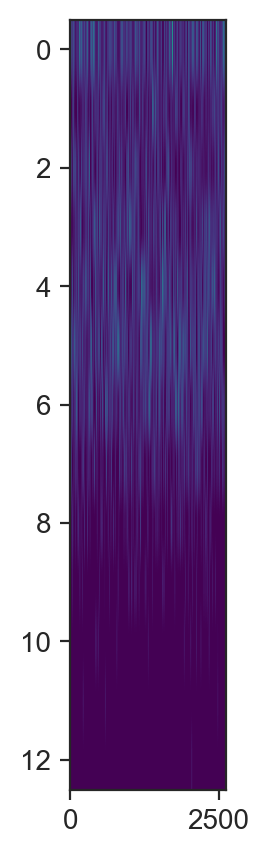

In [249]:
fig, ax = plt.subplots(1, 1, figsize = (7,5), dpi=200, sharex=True, sharey=True)

a = ax.imshow(trace[age_to_plot].titer_bins_per_event.sel(draw=0, chain=0), aspect='1000', cmap='viridis')

## Sensitivity Analysis: decay rate

> SF: The reconstruction of the infection curve assumes that the proportion reported remained fixed throughout the outbreak, that the incubation period and reporting delay is the same for each individual, and that the risk of infection is given by the population risk (ignoring e.g. geographical and household structure). I feel this should be mentioned somewhere (perhaps at the beginning of the section for the model is described in the methods, as it makes interpretation of the model/equations easier.  
> My main question in thinking about whether I believe the conclusions was whether the differences in reporting could be generated by different decay rates of antibodies in children/adults (which have fairly narrow priors). Did the Jones et al. study that a lot of the parameters/priors are drawn from include children and adults and investigate any difference? Or if not perhaps there is a way to look at this in sensitivity analysis?  


> AA: Basically what multiplier on decay rate in kids would you need to get a simliar case to infection ratio. This would help get a sense for how large the differences need to be

In [17]:
multipliers = np.concatenate((1/np.arange(2,11)[::-1], np.arange(1,11)))  # len is 19, from 1/10th to 10 times
trace_sens = {}
for spec_id in [0,8,9,13,17]: # indexes for ['0.1', '0.5', '1.0', '5.0', '9.0']
    file_path = f"from_longleaf_sensitivityanalysis/calib_Fit-hist/cc-Fit-hist_U5-mvDynamics_{spec_id}_ccfb742_2023-09-26/full_cc-Fit-hist_U5-mvDynamics_{spec_id}_ccfb742_2023-09-26.nc"
    this_mult=multipliers[spec_id]
    
    model_folder = "/".join(file_path.split("/")[:-1])
    model_id = "_".join(file_path.split("/")[-1].split("_")[1:]).split(".")[0]
    model_id.replace('adult', 'combined')
    trace_sens[str(this_mult)] = az.from_netcdf(filename=file_path.replace("adult", "U5")).posterior

In [18]:
multipliers = np.concatenate((1/np.arange(2,11)[::-1], np.arange(1,11)))  # len is 19, from 1/10th to 10 times
trace_sens_adult = {}
for spec_id in [0,8,9,13,17]:
    file_path = f"longleaf_review/sensitivity_rate/cc-Fit-hist_adult-mvDynamics_{spec_id}_52a430f_2024-01-28/full_cc-Fit-hist_adult-mvDynamics_{spec_id}_52a430f_2024-01-28.nc"
    this_mult=multipliers[spec_id]
    print(this_mult, spec_id)

    model_folder = "/".join(file_path.split("/")[:-1])
    model_id = "_".join(file_path.split("/")[-1].split("_")[1:]).split(".")[0]
    #model_id.replace('adult', 'combined')
    trace_sens_adult[str(this_mult)] = az.from_netcdf(filename=file_path).posterior

0.1 0
0.5 8
1.0 9
5.0 13
9.0 17


## Sensitivity Analysis: baseline titer

In [150]:

trace_lowbase025 = {}
file_path = f"longleaf-review-hist/cc-Fit-hist-review-lowbase_adult-mvDynamics_5b08fdd_2024-02-12_lowbase0.25/full_cc-Fit-hist-review-lowbase_adult-mvDynamics_5b08fdd_2024-02-12_lowbase0.25.nc"
trace_lowbase025['adult'] = az.from_netcdf(filename=file_path.replace("adult", "adult")).posterior
trace_lowbase025['U5'] = az.from_netcdf(filename=file_path.replace("adult", "U5")).posterior

In [151]:

trace_lowbase050 = {}
file_path = f"longleaf-review-hist/cc-Fit-hist-review-lowbase_adult-mvDynamics_5b08fdd_2024-02-12_lowbase0.5/full_cc-Fit-hist-review-lowbase_adult-mvDynamics_5b08fdd_2024-02-12_lowbase0.5.nc"
trace_lowbase050['adult'] = az.from_netcdf(filename=file_path.replace("adult", "adult")).posterior
trace_lowbase050['U5'] = az.from_netcdf(filename=file_path.replace("adult", "U5")).posterior

/Users/chadi/anaconda3/envs/haiti-sero_pymc4/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chadi/anaconda3/envs/haiti-sero_pymc4/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/chadi/anaconda3/envs/haiti-sero_pymc4/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chadi/anaconda3/envs/haiti-sero_pymc4/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na 

adult Inf to Rep Case ratio with a decay prior multiplied by .25 is 4.2 (95%CrI 4.0-4.4)
adult Inf to Rep Case ratio with a decay prior multiplied by .5 is 5.5 (95%CrI 5.3-5.7)
U5 Inf to Rep Case ratio with a decay prior multiplied by .25 is 1.3 (95%CrI 0.9-1.7)
U5 Inf to Rep Case ratio with a decay prior multiplied by .5 is 1.8 (95%CrI 1.3-2.2)


/Users/chadi/anaconda3/envs/haiti-sero_pymc4/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chadi/anaconda3/envs/haiti-sero_pymc4/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


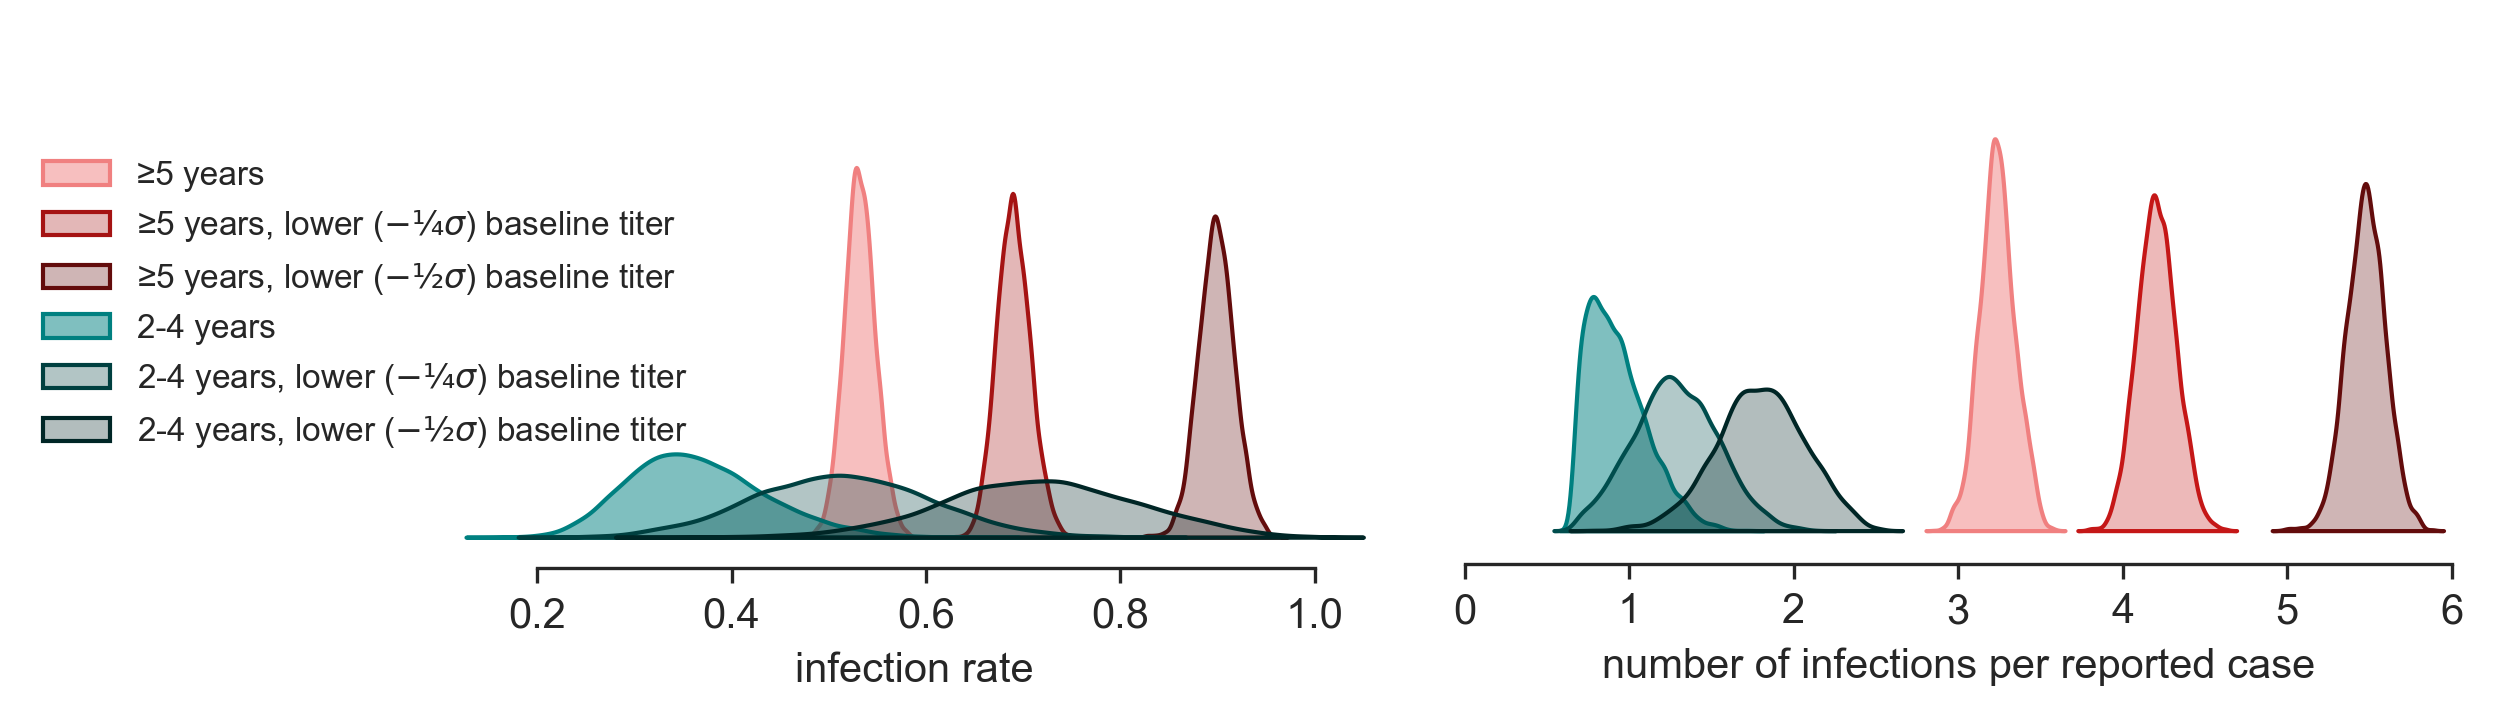

In [162]:
to_plot_on_this_graph = ["adult","U5"]
fig, axes = plt.subplots(1, 2, figsize = (8.5,2.5), dpi=300)


from matplotlib import cm
import matplotlib

#normalize item number values to colormap
norm = matplotlib.colors.Normalize(vmin=0, vmax=10)

#colormap possible values = viridis, jet, spectral

def get_color(mult):
    return cm.winter(norm(float(mult)))


#### INITIAL U5 sensitivty
ax = axes[1]
colors_age = {"adult": "lightcoral", "U5": "teal"}
#colors_age = {"adult": "lightcoral", "U5": "slategray"}
legend_age = {"adult": "≥5 years", "U5": "2-4 years", "all": "All ≥ 2 years"}


# Reporting rate
for age_to_plot in to_plot_on_this_graph:

        rho = 1/trace[age_to_plot]["rho"].values.ravel()
        sns.kdeplot(rho, 
            #density = True,  bins=30, 
            color=colors_age[age_to_plot],
            label=legend_age[age_to_plot], 
            ax=ax, 
            fill=True,
            alpha=.5,
            lw=1,
        )
        
        rho = 1/trace_lowbase025[age_to_plot]["rho"].values.ravel()
        print(f"{age_to_plot} Inf to Rep Case ratio with a decay prior multiplied by .25 is {rho.mean():.1f} (95%CrI {np.quantile(rho, q=0.05):.1f}-{np.quantile(rho, q=0.95):.1f})")
        sns.kdeplot(rho, 
            #density = True,  bins=30, 
                #color=colors_age[age_to_plot],
                color=adjust_lightness(colors_age[age_to_plot],.6), 
                label=f"{legend_age[age_to_plot]}, lower ($-¼\sigma$) baseline titer", 
                ax=ax, 
                fill=True,
                alpha=.3,
                lw=1,
            )

        rho = 1/trace_lowbase050[age_to_plot]["rho"].values.ravel()
        print(f"{age_to_plot} Inf to Rep Case ratio with a decay prior multiplied by .5 is {rho.mean():.1f} (95%CrI {np.quantile(rho, q=0.05):.1f}-{np.quantile(rho, q=0.95):.1f})")
        sns.kdeplot(rho, 
            #density = True,  bins=30, 
                #color=colors_age[age_to_plot],
                color=adjust_lightness(colors_age[age_to_plot],.3), 
                label=f"{legend_age[age_to_plot]}, lower ($-½\sigma$) baseline titer", 
                ax=ax, 
                fill=True,
                alpha=.3,
                lw=1,
            )
        

        
        


ax.set_xlim(.5,6)
ax.set_xticks(np.arange(0,6.5,1))
ax.set_ylim(-.5,5)
#ax.set_xlabel("number of infections per reported case")
ax.set_yticklabels("")
ax.set_ylabel("")
sns.despine(ax = ax,  offset = -4, left = True, trim = True)
ax.yaxis.set_ticks_position('none')
ax.set_xlabel("number of infections per reported case")



# Attack rate
ax = axes[0]
a = []
for k, age_to_plot in enumerate(to_plot_on_this_graph):
    cases_gt, serosurvey_gt, n_population,\
        cases_arr, n_sampled, cases_total,\
        n_days, observed_count = get_gt_data(age_to_plot)
    #ax.hist
    
    sns.kdeplot(trace[age_to_plot]["if_inf_reported"].values.sum(axis=2).ravel()/n_sampled, 
        #density = True, bins=15, 
        label=legend_age[age_to_plot],
        color=colors_age[age_to_plot], 
        fill=True,
        alpha=.5,
        lw=1,
        ax=ax)

    tp = trace_lowbase025[age_to_plot]["if_inf_reported"].values.sum(axis=2).ravel()/n_sampled
    sns.kdeplot(tp, 
        #density = True, bins=15, 
        label=f"{legend_age[age_to_plot]}, lower ($-¼\sigma$) baseline titer",
        color=adjust_lightness(colors_age[age_to_plot],.5), 
        fill=True,
        alpha=.3,
        lw=1,
        ax=ax)

    tp = trace_lowbase050[age_to_plot]["if_inf_reported"].values.sum(axis=2).ravel()/n_sampled
    sns.kdeplot(tp, 
        #density = True, bins=15, 
        label=f"{legend_age[age_to_plot]}, lower ($-½\sigma$) baseline titer",
        color=adjust_lightness(colors_age[age_to_plot],.3), 
        fill=True,
        alpha=.3,
        lw=1,
        ax=ax)

sns.despine(ax = ax, bottom=True, left = True)

#ax.set_xlabel("infection rate")
#ax.set_xticks(np.arange(.1,.71,0.1))
ax.set_yticklabels("")
ax.set_ylabel("")
#ax.set_xlim(0.0,0.8)
ax.set_ylim(-3,35)
sns.despine(ax = ax,  offset = -3, left = True, trim = True)
ax.yaxis.set_ticks_position('none')
#sns.despine(ax = ax, offset = 5, left = True, trim = True)
# add the ticks to the lower axes:
ax.set_xlabel("infection rate")
#ax.legend(loc="center right", frameon=False, bbox_to_anchor=(-.20,.5))
ax.legend(loc="center right", frameon=False, bbox_to_anchor=(0.3,.5), fontsize=8)



fig.tight_layout()

In [ ]:
trace["adult"]["if_inf_reported"].values.sum(axis=2).ravel()

## Calibration diagnostics checks

Number of divergences:

In [ ]:
# display the total number and percentage of divergent
divergent = np.array(trace_raw.sample_stats['diverging'])
print('Number of Divergent %d' % divergent.nonzero()[0].size)
divperc = divergent.nonzero()[0].size /trace_raw.sample_stats['diverging'].size * 100
print('Percentage of Divergent %.1f' % divperc)

In [37]:
summaries = {}
for age_to_plot in predictive_checks.keys():
    print(age_to_plot)
    summaries[age_to_plot] = az.summary(trace_raw[age_to_plot])

adult
all
U5


/Users/chadi/anaconda3/envs/haiti-sero_pymc4/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chadi/anaconda3/envs/haiti-sero_pymc4/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chadi/anaconda3/envs/haiti-sero_pymc4/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chadi/anaconda3/envs/haiti-sero_pymc4/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is 

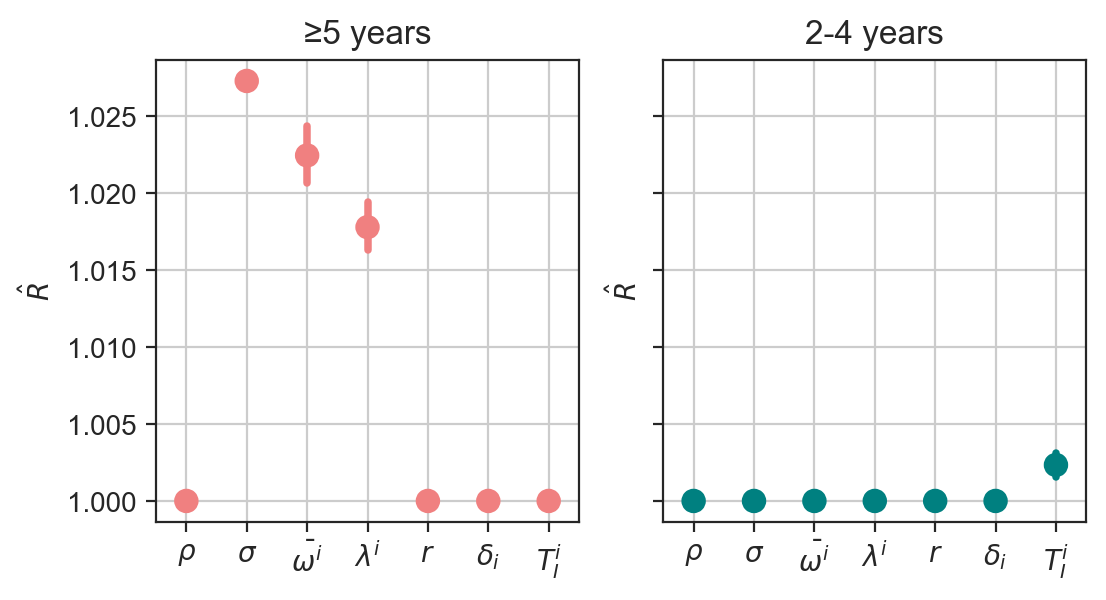

In [172]:
fig, axes = plt.subplots(1, 2, figsize = (6,3), dpi=200, sharey=True)

for i, age_to_plot in enumerate(["adult", "U5"]):
    s = summaries[age_to_plot].copy()
    s[s.index.str.contains('\[0\]')]
    if "parameter" in s.columns:
        s = s.drop("parameter", axis=1)

    s = s.reset_index(names=["parameter"])
    # collapse the multi-individual parameters
    s["parameter"] = s["parameter"].str.replace(r"\[(.*)\]","", regex=True)
    tp = s[["parameter", "r_hat"]].reset_index(drop=True).pivot(columns="parameter", values="r_hat")
    tp = tp[["rho", "sigma", "omega_p", "lambda", "delta", "if_inf_reported", "day_inf_reported"]]
    tp.columns = ["$\\rho$", "$\\sigma$","$\\bar{\\omega^i}$", "$\\lambda^i$", "$r$", "$\\delta_i$", "$T_I^i$"]

    ax =axes.flat[i]
    sns.pointplot(tp, ax=ax, color=colors_age[age_to_plot], linestyles="")
    ax.grid()

    #sns.despine(ax = axes,  offset = -3, left = True, trim = True)
    #axes.set_xticklabels(tp.columns,  rotation=90, fontdict={'fontsize': 'small'});
    ax.set_ylabel("$\\hat{R}$")
    ax.set_title(legend_age[age_to_plot])

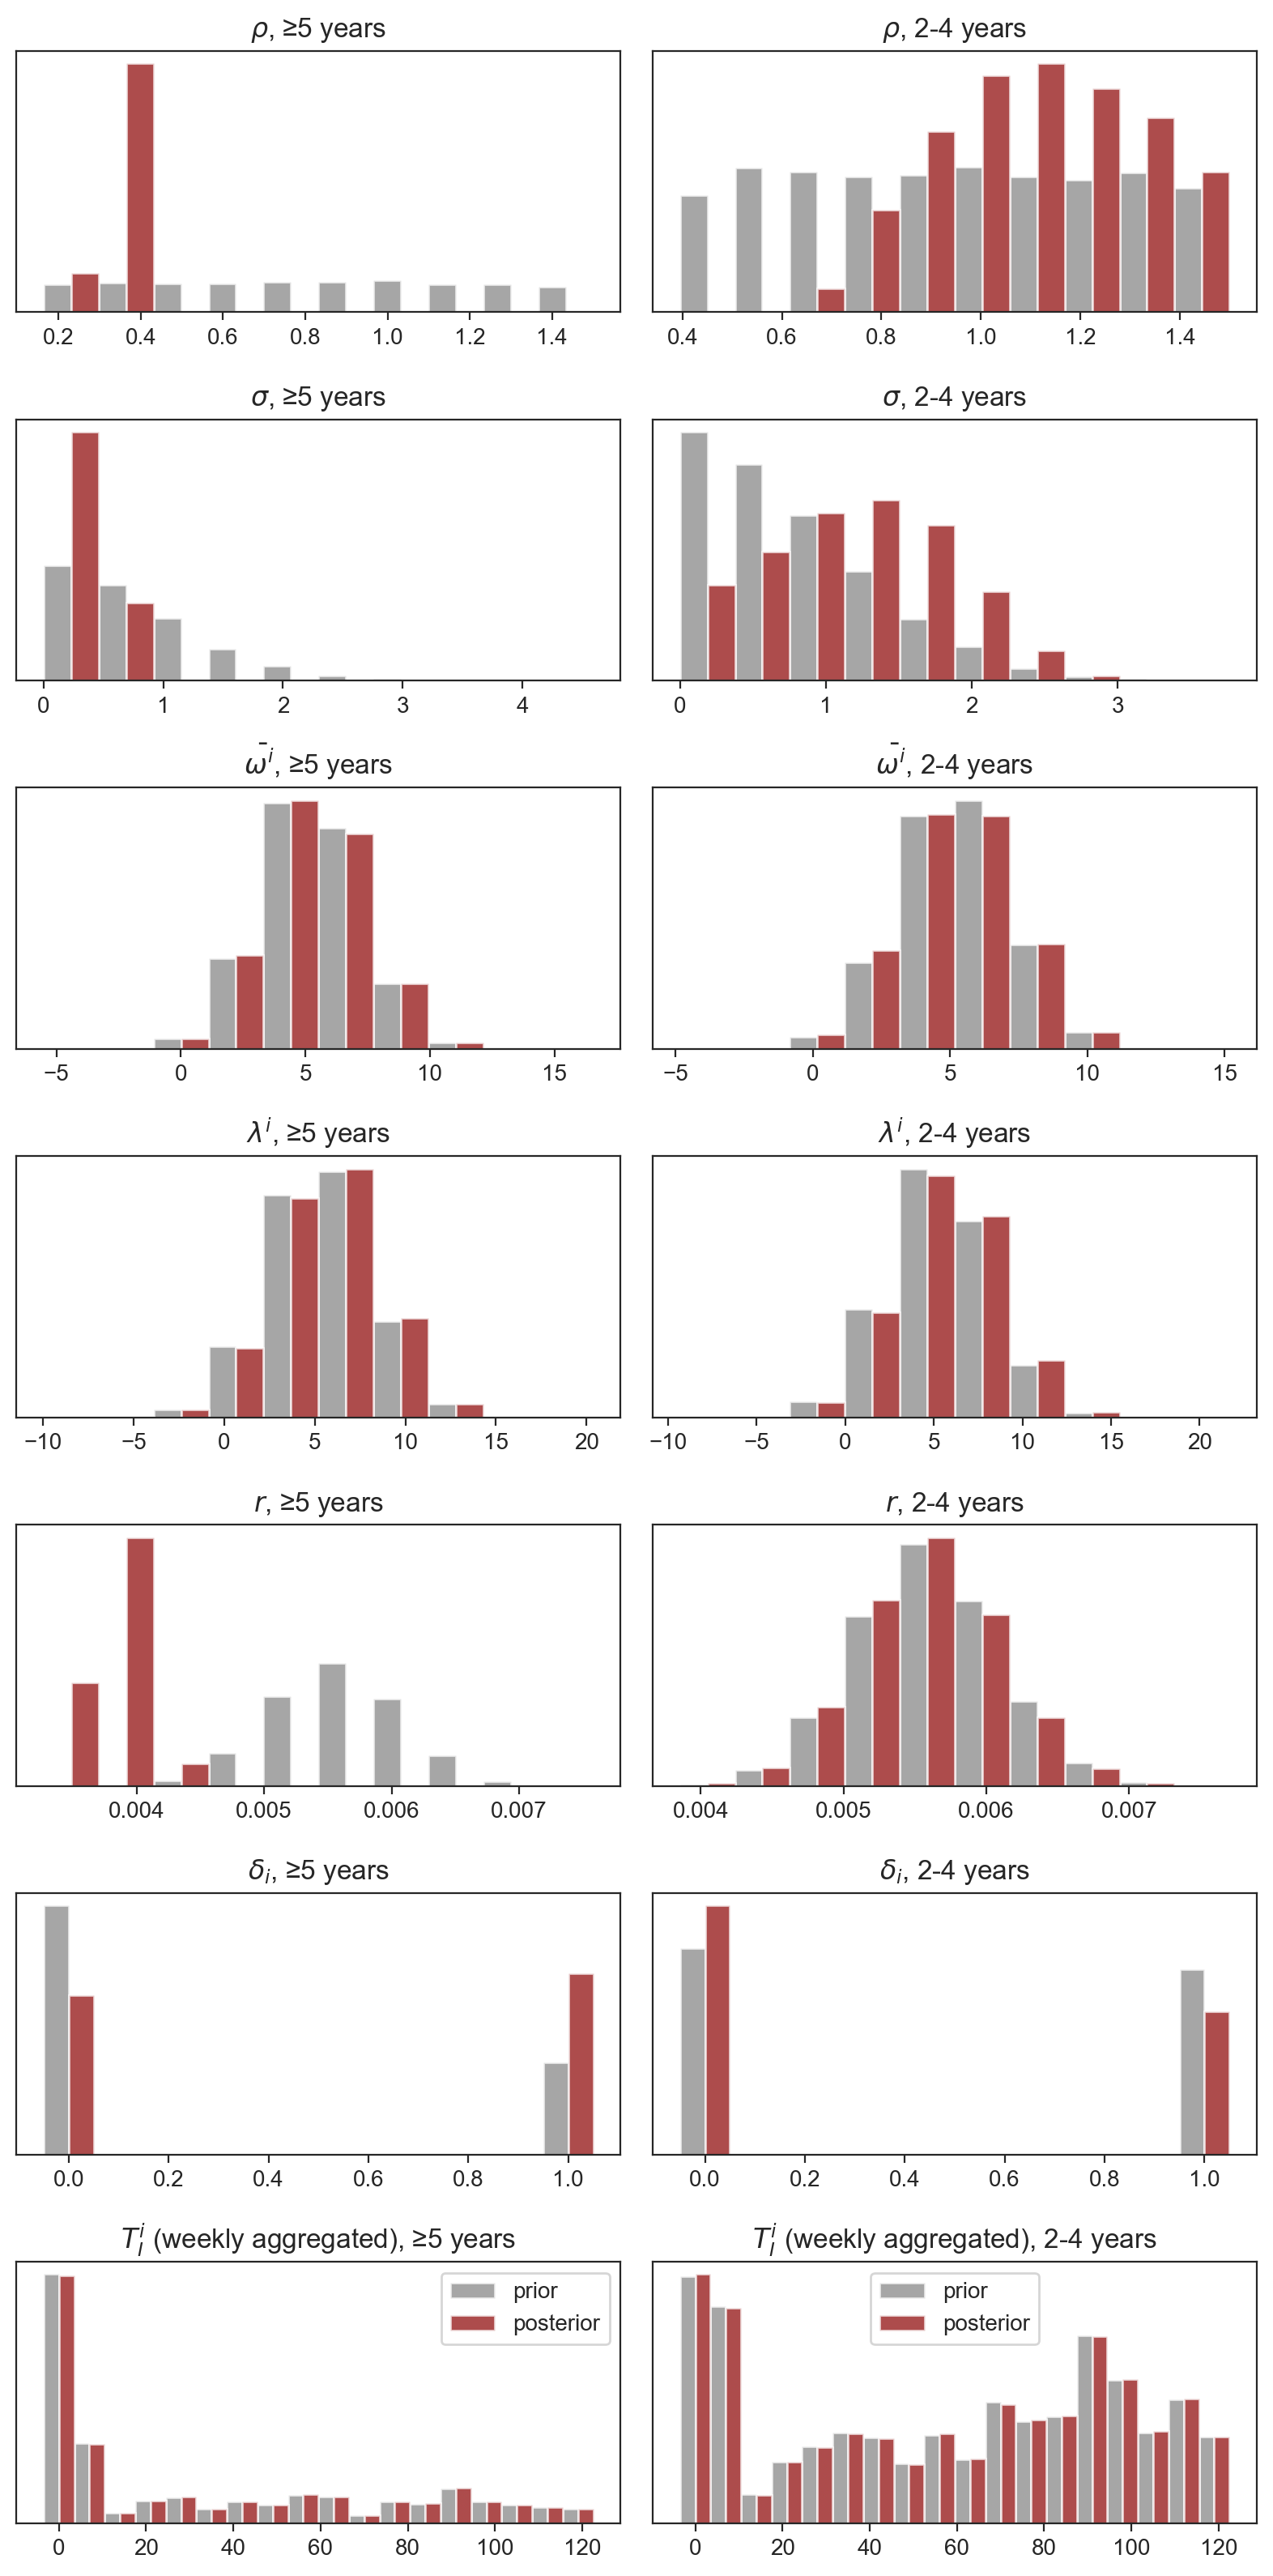

In [196]:
# "omega_p_t","lambda_t",
fig, axes = plt.subplots(7, 2, figsize = (8,16), dpi=200)
for j, age_to_plot in enumerate(["adult", "U5"]):
    
    names = ["$\\rho$", "$\\sigma$","$\\bar{\\omega^i}$", "$\\lambda^i$", "$r$", "$\\delta_i$", "$T_I^i$ (weekly aggregated)"]
    for i, var in enumerate(["rho", "sigma","omega_p_t", "lambda_t", "delta", "if_inf_reported", "day_inf_reported"]):
        ax = axes[i,j]
        #ax = axes.flat[i]
        ax.set_title(f"{names[i]}, {legend_age[age_to_plot]}")
        #sns.kdeplot(trace_raw[age_to_plot]["posterior"][var].values.flatten()[::10], ax=ax, color='r')
        #sns.kdeplot(trace_raw[age_to_plot]["prior"][var].values.flatten()[::10], ax=ax, color='k')
        #ax.hist(trace_raw[age_to_plot]["prior"][var].values.flatten(), color='black', histtype='stepfilled',
        #        alpha=0.4, label="prior", density=True)
        #ax.hist(trace_raw[age_to_plot]["posterior"][var].values.flatten(),color='darkred',histtype='stepfilled',
        #        alpha=0.4, label="posterior", density=True)
        #
        bins=None
        if i==5: bins= [-.05,.05, .95, 1.05]
        if i==6: bins=np.arange(130, step=7) - 3.5
        ax.hist([trace_raw[age_to_plot]["prior"][var].values.flatten(), trace_raw[age_to_plot]["posterior"][var].values.flatten()], 
                color=['grey','darkred'], 
                #histtype='stepfilled',
                alpha=.7, 
                label=["prior", "posterior"],
                rwidth=1,
                density=True, align="mid", bins=bins)
        
        
        ax.set_yticks([])
    ax.legend()
fig.tight_layout()

In [49]:
len(s[s["r_hat"]>1.1]["r_hat"])/len(s[s["r_hat"]<1.1]["r_hat"])

0.0

In [ ]:
s = summaries['adult']
print(s[s.index.str.contains('rho')])

See which variables have a Gelman Rubin (r_hat) statistic larger than 1.1, and check that the effective sample size is > 1000

In [ ]:
sns.violinplot(s["r_hat"].values)

In [ ]:
az.summary(trace_raw["adult"])

In [ ]:
az.rhat(trace)>1.1

Acceptance rate:

In [ ]:
accept = trace.sample_stats['acceptance_rate']
print(f"acceptance probability :", accept.mean().values)

Energy:

In [ ]:
az.plot_energy(trace)
plt.show()

BFMI: < 0.2 is bad

In [ ]:
pm.stats.bfmi(trace)

In [ ]:
az.plot_trace(trace,var_names=to_plot_vars);

In [ ]:
az.plot_posterior(trace, var_names=to_plot_vars);

In [ ]:
az.plot_pair(trace, var_names=to_plot_vars, kind='kde');

In [ ]:
az.plot_forest(trace, var_names = to_plot_vars);

In [ ]:
az.plot_autocorr(trace, var_names = to_plot_vars);